In [1]:
##
#     Libraries
####

import pandas as pd
import numpy as np
import os
import math
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import svm
from sklearn.cluster import DBSCAN
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
import copy
from matplotlib.pyplot import cm
import seaborn as sns
from sklearn.decomposition import PCA
from scipy import spatial
import numpy.matlib

pd.__version__

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
#read the brain section features file which is identified by mouseID, day, treatment, celltype, sectionID
#return a pd.dataframe containing a section's main features
def read_mouse_features_file(file,path="",delim="\t",boxsize=150,scale=1.5,threshold='paired_threshold',windows=False):
    sep=""
    if windows:
        if not (path[:-1] == "\\"):
            path += "\\"
    else:
        if not (path[:-1] == "/"):
            path += "/"
            
    f = f"{path}{sep}{file}"
    d = pd.read_csv(f,delimiter=delim)
    ms, day, cond, cell, sect, start = file.split("_")
    keyList = ["ID","Day","Treatment","Section","CellType","Boxsize","Scale",'Threshold']
    infoList = [ms,day,cond,sect,cell,boxsize,scale,threshold]
    for key, info in zip(keyList,infoList):
        d[key] = [info]*len(d)
        
    return d
    
def read_mouse_features(path="",delim="\t",boxsize=150,scale=1.5,threshold='paired_threshold',filetype="features",
                        id_list=[],day_list=[],treatment_list=[],sec_list=[],celltype_list=[]):
    mice = []
    files = os.listdir(path)
    if (id_list) or (day_list) or (treatment_list) or (sec_list) or (celltype_list):
        files = check_file_list(files,id_list=id_list,day_list=day_list,treatment_list=treatment_list,sec_list=sec_list,celltype_list=celltype_list)
        print(files)
    if filetype == "fractal":
        print("--- reading factal files ---")
        for f in files:
            print(f)
            mice.append(read_mouse_fractals2(f,path=path,delim=delim,boxsize=boxsize,scale=scale,threshold=threshold))
    elif filetype == "features":
        print("--- reading features files ---")
        for f in files:
            print(f)
            mice.append(read_mouse_features_file(f,path=path,delim=delim,boxsize=boxsize,scale=scale,threshold=threshold))
    allMice = pd.concat(mice,ignore_index=True)
    return allMice

def read_mouse_fractals(file,path="",delim="\t",boxsize=150,scale=1.5,threshold='paired_threshold',windows=False):
    sep=""
    if windows:
        if not (path[:-1] == "\\"):
            path += "\\"
    else:
        if not (path[:-1] == "/"):
            path += "/"
            
    f = f"{path}{sep}{file}"
    ms, day, cond, cell, sect, start = file.split("_")
    keyList = ["ID","Day","Treatment","Section","CellType","Boxsize","Scale",'Threshold']
    infoList = [ms,day,cond,sect,cell,boxsize,scale,threshold]
    
    d = pd.read_csv(f,delimiter=delim)
    fractals = d.loc[d["D"]>0,["BX","BY","D"]]
    #fractals.loc[:,["BX","BY"]] = d[["BX","BY"]].iloc[fractals.index - 1].values
    for key, info in zip(keyList,infoList):
        fractals.loc[:,key] = [info]*len(fractals)
    return fractals

def read_mouse_fractals2(file,path="",delim="\t",boxsize=150,scale=1.5,threshold='paired_threshold',windows=False):
    sep=""
    if windows:
        if not (path[:-1] == "\\"):
            path += "\\"
    else:
        if not (path[:-1] == "/"):
            path += "/"
            
    f = f"{path}{sep}{file}"
    ms, day, cond, cell, sect, start = file.split("_")
    keyList = ["ID","Day","Treatment","Section","CellType","Boxsize","Scale",'Threshold']
    infoList = [ms,day,cond,sect,cell,boxsize,scale,threshold]
    
    d = pd.read_csv(f,delimiter=delim)
    fractals = d.loc[d["D"]>0,["BX","BY","D"]]
    fractals.loc[:,["BX","BY"]] = d[["BX","BY"]].iloc[fractals.index - 1].values
    for key, info in zip(keyList,infoList):
        fractals.loc[:,key] = [info]*len(fractals)
    return fractals
     
def check_file_list(files,id_list=[],sec_list=[],day_list=[],treatment_list=[],celltype_list=[]):
    newFiles = []
    for f in files:
        include=True
        if len(f.split("_")) > 5:
            ms, day, cond, cell, sec, xtra = f.split("_")
        else:
            ms, day, cond, cell, sec = f.split("_")
            sec = sec[:-4]

        if day_list:
            include = include and (day in day_list)
        if id_list:
            print(ms,": ,",(ms in id_list))
            include = include and (ms in id_list) #(ms.upper() in map(lambda x:x.lower(),id_list))
        if treatment_list:
            include = include and (cond in treatment_list)
        if sec_list:
            print(sec,": ,",(sec in sec_list))
            print(sec_list)
            include = include and (sec in sec_list)
        if celltype_list:
            print(f"cell: {cell in celltype_list}")
            include = include and (cell in celltype_list)
        if include:
            newFiles.append(f)
        print(f,": ",f.split("_"),": ",include)
    return newFiles
    
def merge_feature_files(DF1,DF2, on =["BX","BY","ID","Day","Treatment","Section","CellType",'Boxsize','Threshold'],how="outer"):
    return pd.merge(DF1,DF2,on=on,how=how)

##
# 
# Iter through all sections as grouped by cell type and ID
#s if splitByTreatment: 
#        return a list of [untreated, treated] sections, order is not preserved, treatment determined by treatmentCol
#######
def iter_mice_sections(mice,cell="microglia",splitByTreatment=True,treatmentCol="Treatment",control="noFUS",treatment="FUS"):
    IDs = np.unique(mice.loc[mice["CellType"]==cell,["ID"]])
    for ID in IDs:
        secs = np.unique(mice.loc[( (mice["ID"]==ID) & (mice["CellType"]==cell) ),["Section"]])
        for s in secs:
            sec = mice.loc[( (mice["ID"] == ID) & (mice["Section"] == s) & (mice["CellType"] == cell) )]
            if splitByTreatment:
                sec = split_column(sec,col=treatmentCol,control=control,treatment=treatment)
            yield sec
            
def iter_mice_sections2(mice,cell="microglia",control="noFUS",treatment="FUS",treatmentCol="Treatment",splitByTreatment=True):
    mice = mice.set_index(["CellType","ID","Section","Treatment",'Boxsize','Threshold',"boxID"])
    x = mice.xs(cell,level="CellType",drop_level=False)
    for index, df in x.groupby(level=["ID","Section"]):
        print(index)
        treatments = df.index.get_level_values(treatmentCol)
        if ((control in treatments) and (treatment in treatments)):
            result = df.reset_index()
            if splitByTreatment:
                con = df.xs(control,level="Treatment",drop_level=False)
                trt = df.xs(treatment,level="Treatment",drop_level=False)
                result = [con.reset_index(), trt.reset_index()]
            yield result
        else:
            print('ITER PROBLEM')
        
        
def set_box_id(mice):
    mice.loc[:,"boxID"] = np.arange(0,len(mice))
    return mice

#returns a list of dataframes split from a larger dataframe over the values of a defined column
def split_column(df,col="Treatment",control="noFUS",treatment="FUS"):
    return df.loc[df[col]==control], df.loc[df[col]==treatment]

def round_digits(df,features=['BX','BY']):
    df.loc[:,features] = df[features].astype('float').round(1)
    return df


print('done')

done


In [3]:
import decimal
import itertools
decimal.getcontext().rounding = decimal.ROUND_DOWN


def add_grid_thresholds(to_add,mice,col='Threshold'):
    re=[]
    thresholds = mice[col].unique()
    for t in thresholds:
        _ = copy.copy(to_add)
        _.loc[:,col]=t
        re.append(_)
    return pd.concat(re)

def add_all_cell_data2(mice,boxsize=150,
                       path="F:\\lab_files\\imageJ_macro_working_directory\\Gfap_Iba1_ki67\\GFAP_Iba1_ki67_output\\output_whole\\microglia\\cell_counts\\counts\\",
                      nnd=True, id_list=[], day_list=[], treatment_list=[],sec_list=[], centers=['X','Y'], fill_nan=True, slide=2,
                      ):
    begin=time.time()
    files = os.listdir(path)
    if (id_list) or (day_list) or (treatment_list) or (sec_list):
        files = check_file_list(files,id_list=id_list,day_list=day_list,treatment_list=treatment_list,sec_list=sec_list)
        print(files)
    keys = ["ID","Day","Treatment","Section","CellType",'Boxsize']
    to_add = []
    for f in files:
        print(f)
        st = time.time()
        ms, day, cond, cell, sect = f.split("_")
        sec = pd.read_csv(path+f,"\t")
        sec = sec.rename(columns={" " : "cellID"})
        
        for k,t in zip(keys,[ms,day,cond,sect[:-4],cell,boxsize]):
            sec.loc[:,k] = t
        if nnd:
            nnd_df = construct_nnd_df(sec, xy=centers)
            sec = pd.merge(sec, nnd_df, on=centers)
            
            to_add.append(sec)
            
            
    to_add = pd.concat(to_add,ignore_index=True)
    to_add = add_grid_thresholds(to_add,mice) #add thresholds from mice to to_add(i.e. single_threshold / paired threshold)
    mice = add_cell_data2(mice,to_add,boxsize=boxsize, centers=centers, slide=slide)
    
    mice.loc[:,'ave_nnd'] = mice['sum_cell_nnd'] / mice['cell_counts']
    mice.loc[:,'ave_soma_size'] = mice['sum_cell_area'] / mice['cell_counts']
    mice.loc[:,'ave_soma_circularity'] = (4* np.pi * mice['sum_cell_area']) / (mice['sum_cell_perim_squared']) #4π × [Area] / [Perimeter]**2
    
    if fill_nan:
        fill = {}
        for c in ['ave_nnd','ave_soma_size','ave_soma_circularity','cell_counts']:
            fill[c] = 0
        mice.fillna(fill, inplace=True)
    
    print('total_time: ', time.time()-begin)
    return mice
       
def get_first_cat(x):
    return x.left

def align_cellfeats_index(cells,index_names,index,xy=['BX','BY'],decimals=3):
    for k, v in zip(index_names,index):
        cells.loc[:,k] = v
    #cells.loc[:,xy] = cells[xy],d
    return cells.set_index(index_names+xy)

def get_ranges(rangeinindex,xy,boxsize=150,scale=1.5,e=2.0,decimals=3, slide=2):
    range_ = np.unique(rangeinindex.index.get_level_values(xy))# already rounded to 3

    #allocate boxes into 1 of n=slide ranges depending on modulus, note: error of modulus will progressively increase on the order of the 3 decimal place.
    mod = float(round(decimal.Decimal(boxsize/scale),decimals))
    translation = float(round(decimal.Decimal(int(boxsize/slide)/scale),decimals)) # correct for bug where boxsizes start at int(boxsize/2)/scale instead of just boxsize/2/scale
    
    print(translation)
    print(range_)
    print(mod)
    
    stop
    print(np.abs(range_ - translation))
    print(mod)
    print(np.abs((range_ - translation)) % mod)
    stop
    
    range_1 = range_[np.argwhere((range_ % mod) < e)]
    range_2 = range_[np.argwhere(((range_ - translation) % mod) < e)]
    print(slide)
    print(range_1)
    print(range_2)
    stop
    range_1 = range_1.T[0]
    range_2 = range_2.T[0]
    range_1 = np.append(range_1,np.array(max(range_1)+ mod))
    range_2 = np.append(range_2,np.array(max(range_2)+ mod))
    return range_1,range_2
   
    
def get_ranges2(rangeinindex,xy,slide=2,slide_size=100):
    range_ = np.unique(rangeinindex.index.get_level_values(xy))
    ranges = []
    for i in range(0,slide):
        _ = np.arange(i,len(range_),slide)
        #for cut need to add one more upper boundary so the previous upper boundary is considered
        last = range_[_[-1]]
        grid = range_[_]
        '''
        if last % slide_size == 0: #add 0 as a lower bound into the correct range (i.e. the one defined by window_size * n)
            grid = np.append(np.array[0],grid)
        '''
        grid = np.append(grid,[last+slide_size])
        ranges.append(grid)
        
    return ranges
'''
input pandas series
Corrects a weird error with pd.cut which subtracts lower bound by 10**-decimal from only the first category
returns pandas series with 10**-decimal added back to first category.
'''
def correct_cut_error(listofarrays,listofxy=[],decimals=3):
    if listofxy:
        for ar, xy in zip(listofarrays,listofxy):
            minxy = np.nanmin(xy) - 10**(decimals*-1)
            if minxy in ar.values:
                ar = cut_correction(ar,decimals=decimals)
            yield ar
    else:
        for ar in listofarrays:
            yield cut_correction(ar,decimals=decimals)
            
def cut_correction(ar,decimals=3):
    _ = np.nanmin(ar.values)
    ar = pd.to_numeric(ar)
    ar.loc[ar==_] = ar.loc[ar==_] + 10**(decimals*-1)
    return ar

def correct_cut_error2(listofarrays,decimals=1):
    corrected = []
    for arr in listofarrays:
        corrected.append(arr.apply(lambda x: round(x, decimals)))
    return corrected

def add_cell_data2(main,add,nnd=True,indeces=['CellType','ID','Day','Treatment','Section','Boxsize','Threshold'],xy=['BX','BY'],centers=['X','Y'],boxsize=150,scale=1.5,overlapping_grid=True,slide=2,decimals=1,skipfirstlines=2):
    print('main length',len(main))
    main.loc[:,xy] = np.round(main[xy],decimals=decimals)
    main = main.set_index(indeces+xy) # mice DF categorized into boxes
    
    add.loc[:,'perim_squared'] = add['Perim.']**2
    add = add.set_index(indeces)[centers+['Area','Perim.','perim_squared','cellID','nnd']] #cells to add
    #main = main.sort_values(by=['Area'],ascending=False)
    #boxsize = boxsize/scale
    toadd = []
    
    # iter through cell box indexes...
    for indexes, df in add.groupby(level=indeces):
        
        print(f" processing section: {indexes}")
        ranges = main.xs(indexes,level=tuple(indeces)).sort_values(by=['Area'],ascending=False) # get the corresponding box indeces in the main mouse, sort by area to remove the background DFs
        ranges = ranges.iloc[skipfirstlines:]
        #print(ranges.loc[~((ranges['ground']=='foreground')||(ranges['ground']=='foreground'))])
        #ranges = main.loc[indexes,['BX','BY']]
        
        #one cell can be in multiple overlapping grids... therefore need to iter through grid ranges
        if overlapping_grid:
            xs = get_ranges2(ranges,xy[0],slide=slide)
            ys = get_ranges2(ranges,xy[1],slide=slide)
            '''
            stop
            
            a,b = get_ranges(ranges,xy[0],boxsize=boxsize,scale=scale,decimals=decimals,slide=slide)
            print(a)
            print(b)
            stop
            c,d = get_ranges(ranges,xy[1],boxsize=boxsize,scale=scale,decimals=decimals)
            '''
            # bin the data into equally spaced groups
            cut_x = []
            cut_y = []
            
            for x in xs:
                cut_x.append(pd.cut(df[centers[0]], x, include_lowest=True, retbins=False).apply(get_first_cat))
                
            for y in ys:
                cut_y.append(pd.cut(df[centers[1]], y, include_lowest=True, retbins=False).apply(get_first_cat))
            #x1 = pd.cut(df[centers[0]], xs[0], include_lowest=True, retbins=False).apply(get_first_cat) #,decimals=1)#.apply(round)
            #x2 = pd.cut(df[centers[0]], xs[1], include_lowest=True, retbins=False).apply(get_first_cat) #,decimals=1)#.apply(round)
            #y1 = pd.cut(df[centers[1]], c, include_lowest=True, retbins=False).apply(get_first_cat) #,decimals=1)#.apply(round)
            #y2 = pd.cut(df[centers[1]], d, include_lowest=True, retbins=False).apply(get_first_cat) #,decimals=1)#.apply(round)
            #x1,x2,y1,y2 = correct_cut_error([x1,x2,y1,y2],listofxy=[a,b,c,d])
            cut_x = correct_cut_error2(cut_x)
            cut_y = correct_cut_error2(cut_y)
            DFs = []
            #for x,y in zip([x1,x1,x2,x2],[y1,y2,y1,y2]):
            for x,y in list(itertools.product(cut_x, cut_y)):
                _ = df.groupby([x, y])[['cellID','Area','perim_squared','nnd']].agg({'cellID':'count',
                                                                             'Area': 'sum',
                                                                             'perim_squared': 'sum',
                                                                             'nnd': 'sum'})
                DFs.append(_.reset_index())
            grouped_cells = pd.concat(DFs)
            grouped_cells = grouped_cells.rename(columns = {centers[0] : xy[0], 
                                                            centers[1] : xy[1], 
                                                            'cellID' : 'cell_counts',
                                                            'Area':'sum_cell_area', 
                                                            'perim_squared' : 'sum_cell_perim_squared',
                                                           'nnd': 'sum_cell_nnd'})
            grouped_cells = align_cellfeats_index(grouped_cells,indeces,indexes)
            toadd.append(grouped_cells)
    #'''
    toadd = pd.concat(toadd)
    for col in toadd.columns.values:
        st = time.time()
        main.loc[toadd.index,col] = toadd[col]
        print('time per col: ', time.time()-st)
        #stop
    #'''
    print(main.columns.values)
    print('post merge main length',len(main))
    print(time.time()-st)
    return main.reset_index()

def do_kdtree(xy,points):
    mytree = spatial.cKDTree(xy)
    return mytree.query(points,k=2) # dist, index
    
def get_nnd(xy):
    dist, ind = do_kdtree(xy,xy)
    point1=xy
    point2=xy[ind[:,1]]
    distances=dist[:,1]
    return point1, point2, distances

def construct_nnd_df(df,xy=['X','Y']):
    p1, p2, d = get_nnd(df[xy].values)
    comb = np.column_stack((p1,d))
    return pd.DataFrame(comb,columns=xy+['nnd'])

print('done')

done


In [74]:
####
#    LOAD 7D ITER BOXES
################################

import gc
import copy


#'''
features = []
fractals = []
branches = []

_dir = 'E'


_set = 'Iba1_set2'
_slide = 2
#'''
for t in ['single_threshold']:
    for boxsize in [150]:
        #feature_path = _dir+":/lab_files/imageJ_macro_working_directory/Gfap_Iba1_ki67/microglia_astrocyte_7D_output/feature_files/"+t+"/features/"+str(boxsize)+"/"
        #fractal_path = _dir+":/lab_files/imageJ_macro_working_directory/Gfap_Iba1_ki67/microglia_astrocyte_7D_output/feature_files/"+t+"/fractal_dimension/datafiles/"+str(boxsize)+"/"
        
        feature_path = f"{_dir}:/lab_files/imageJ_macro_working_directory/Iba1_ML_re/Iba1_set1_19-3-23/output/{_set}/feature_files/{t}/features/{boxsize}"
        fractal_path = f"{_dir}:/lab_files/imageJ_macro_working_directory/Iba1_ML_re/Iba1_set1_19-3-23/output/{_set}/feature_files/{t}/fractal_dimension/datafiles/{boxsize}/"
        branch_path = f"{_dir}:/lab_files/imageJ_macro_working_directory/Iba1_ML_re/Iba1_set1_19-3-23/output/{_set}/feature_files/{t}/branch_features/{boxsize}/"
        
        
        features.append(read_mouse_features(path=feature_path,filetype='features',boxsize=boxsize,threshold=t,id_list=['JS12','JS13','JS14','JS16','JS17v2'], celltype_list=['microglia']))
        fractals.append(read_mouse_features(path=fractal_path,filetype='fractal',boxsize=boxsize,threshold=t,id_list=['JS12','JS13','JS14','JS16','JS17v2'], celltype_list=['microglia']))
        branches.append(read_mouse_features(path=branch_path,boxsize=boxsize,threshold=t,filetype='features',treatment_list=[],id_list=['JS12','JS13','JS14','JS16','JS17v2'],celltype_list=['microglia'],sec_list=[]))
        
features = round_digits(pd.concat(features))
fractals = round_digits(pd.concat(fractals))
branches = round_digits(pd.concat(branches))

print(features[["BX","BY","ID","Day","Treatment","Section","CellType","Boxsize","Scale",'Threshold']])
print(fractals[["BX","BY","ID","Day","Treatment","Section","CellType","Boxsize","Scale",'Threshold']])
        
mice_7d = merge_feature_files(features,fractals,on=["BX","BY","ID","Day","Treatment","Section","CellType","Boxsize","Scale",'Threshold'])
mice_7d = merge_feature_files(mice_7d, branches, on=["BX","BY","ID","Day","Treatment","Section","CellType","Boxsize","Scale",'Threshold'])

#mice_7d_backup = copy.copy(mice_7d)
#'''
'''

#print(mice_7d.loc[mice_7d['CellType']=='astrocyte'])
#'''

#mice_7d = copy.copy(mice_7d_backup)[['D','Mean','IntDen','Area','Perim.',"CellType","ID","Section","Treatment",'Boxsize','Threshold','Day','BX','BY','Scale']]
#print(mice_7d.head())


#'''
#mice_7d = mice_7d.loc[(mice_7d['Threshold']=='single_threshold') & (mice_7d['Section']=='sec6') & (mice_7d['Treatment']=='noFUS') & (mice_7d['ID']=='JS16')]
#print(mice_7d)
#mice_7d =  mice_7d.loc[(mice_7d['Threshold']=='single_threshold')]
#'''

for boxsize in [150]:
    #mice_7d = add_all_cell_data2(mice_7d,boxsize=boxsize,id_list=['JS12','JS13','JS14','JS16','JS17v2'],sec_list=[],nnd=True,
    #                   path="F:\\lab_files\\imageJ_macro_working_directory\\Gfap_Iba1_ki67\\GFAP_Iba1_ki67_output\\output_whole\\astrocyte\\cell_counts\\counts\\",
    #                  nnd_path = 'F:\\lab_files\\imageJ_macro_working_directory\\Gfap_Iba1_ki67\\GFAP_Iba1_ki67_output\\output_whole\\astrocyte\\NND\\')
    mice_7d = add_all_cell_data2(mice_7d,boxsize=boxsize,id_list=['JS12','JS13','JS14','JS16','JS17v2'],nnd=True,slide=_slide,
                       path=f"{_dir}:/lab_files/imageJ_macro_working_directory/Iba1_ML_re/Iba1_set1_19-3-23/output/Iba1_set2/feature_files/single_threshold/count_data/counts/")
    gc.collect()
#'''

#mice_7d.to_csv('F:\\lab_files\\imageJ_macro_working_directory\\Gfap_Iba1_ki67\\microglia_astrocyte_7D_output\\feature_files\\dataframes\\mice_7d_microglia_astrocyte_100-125-150_single-paired_thresh.csv')
#mice_7d.to_csv('C:\\Users\\joey\\OneDrive\\LabWork\\mice_7d_microglia_astrocyte_100-125-150_single-paired_thresh.csv')

#print(mice_7d.loc[mice_7d['ave_soma_circularity'] > 0])


print('done')

JS12 : , True
cell: True
JS12_7D_noFUS_microglia_sec8_150X150.txt :  ['JS12', '7D', 'noFUS', 'microglia', 'sec8', '150X150.txt'] :  True
JS12 : , True
cell: True
JS12_7D_FUS_microglia_sec6_150X150.txt :  ['JS12', '7D', 'FUS', 'microglia', 'sec6', '150X150.txt'] :  True
JS12 : , True
cell: True
JS12_7D_noFUS_microglia_sec6_150X150.txt :  ['JS12', '7D', 'noFUS', 'microglia', 'sec6', '150X150.txt'] :  True
JS12 : , True
cell: True
JS12_7D_FUS_microglia_sec2_150X150.txt :  ['JS12', '7D', 'FUS', 'microglia', 'sec2', '150X150.txt'] :  True
JS12 : , True
cell: True
JS12_7D_FUS_microglia_sec4_150X150.txt :  ['JS12', '7D', 'FUS', 'microglia', 'sec4', '150X150.txt'] :  True
JS12 : , True
cell: True
JS12_7D_noFUS_microglia_sec4_150X150.txt :  ['JS12', '7D', 'noFUS', 'microglia', 'sec4', '150X150.txt'] :  True
JS12 : , True
cell: True
JS12_7D_noFUS_microglia_sec2_150X150.txt :  ['JS12', '7D', 'noFUS', 'microglia', 'sec2', '150X150.txt'] :  True
JS13 : , True
cell: True
JS13_7D_FUS_microglia_sec4_1

JS16_7D_FUS_microglia_sec6_150X150.txt
JS16_7D_FUS_microglia_sec4_150X150.txt
JS16_7D_FUS_microglia_sec2_150X150.txt
JS12_7D_FUS_microglia_sec8_150X150.txt
JS17v2_untreated_L_microglia_sec2_150X150.txt
JS17v2_untreated_L_microglia_sec4_150X150.txt
JS17v2_untreated_L_microglia_sec6_150X150.txt
JS17v2_untreated_L_microglia_sec8_150X150.txt
JS17v2_untreated_R_microglia_sec2_150X150.txt
JS17v2_untreated_R_microglia_sec4_150X150.txt
JS17v2_untreated_R_microglia_sec6_150X150.txt
JS17v2_untreated_R_microglia_sec8_150X150.txt
JS12 : , True
cell: True
JS12_7D_noFUS_microglia_sec8_0-0.txt :  ['JS12', '7D', 'noFUS', 'microglia', 'sec8', '0-0.txt'] :  True
JS12 : , True
cell: True
JS12_7D_noFUS_microglia_sec8_0-75.txt :  ['JS12', '7D', 'noFUS', 'microglia', 'sec8', '0-75.txt'] :  True
JS12 : , True
cell: True
JS12_7D_noFUS_microglia_sec8_75-0.txt :  ['JS12', '7D', 'noFUS', 'microglia', 'sec8', '75-0.txt'] :  True
JS12 : , True
cell: True
JS12_7D_noFUS_microglia_sec8_75-75.txt :  ['JS12', '7D', 'no

JS16 : , True
cell: True
JS16_7D_FUS_microglia_sec6_0-0.txt :  ['JS16', '7D', 'FUS', 'microglia', 'sec6', '0-0.txt'] :  True
JS16 : , True
cell: True
JS16_7D_FUS_microglia_sec6_0-75.txt :  ['JS16', '7D', 'FUS', 'microglia', 'sec6', '0-75.txt'] :  True
JS16 : , True
cell: True
JS16_7D_FUS_microglia_sec6_75-0.txt :  ['JS16', '7D', 'FUS', 'microglia', 'sec6', '75-0.txt'] :  True
JS16 : , True
cell: True
JS16_7D_FUS_microglia_sec6_75-75.txt :  ['JS16', '7D', 'FUS', 'microglia', 'sec6', '75-75.txt'] :  True
JS16 : , True
cell: True
JS16_7D_FUS_microglia_sec4_0-0.txt :  ['JS16', '7D', 'FUS', 'microglia', 'sec4', '0-0.txt'] :  True
JS16 : , True
cell: True
JS16_7D_FUS_microglia_sec4_0-75.txt :  ['JS16', '7D', 'FUS', 'microglia', 'sec4', '0-75.txt'] :  True
JS16 : , True
cell: True
JS16_7D_FUS_microglia_sec4_75-0.txt :  ['JS16', '7D', 'FUS', 'microglia', 'sec4', '75-0.txt'] :  True
JS16 : , True
cell: True
JS16_7D_FUS_microglia_sec4_75-75.txt :  ['JS16', '7D', 'FUS', 'microglia', 'sec4', '75-7

JS12_7D_FUS_microglia_sec6_0-75.txt
JS12_7D_FUS_microglia_sec6_75-0.txt
JS12_7D_FUS_microglia_sec6_75-75.txt
JS12_7D_noFUS_microglia_sec6_0-0.txt
JS12_7D_noFUS_microglia_sec6_0-75.txt
JS12_7D_noFUS_microglia_sec6_75-0.txt
JS12_7D_noFUS_microglia_sec6_75-75.txt
JS12_7D_FUS_microglia_sec2_0-0.txt
JS12_7D_FUS_microglia_sec2_0-75.txt
JS12_7D_FUS_microglia_sec2_75-0.txt
JS12_7D_FUS_microglia_sec2_75-75.txt
JS12_7D_FUS_microglia_sec4_0-0.txt
JS12_7D_FUS_microglia_sec4_0-75.txt
JS12_7D_FUS_microglia_sec4_75-0.txt
JS12_7D_FUS_microglia_sec4_75-75.txt
JS12_7D_noFUS_microglia_sec4_0-0.txt
JS12_7D_noFUS_microglia_sec4_0-75.txt
JS12_7D_noFUS_microglia_sec4_75-0.txt
JS12_7D_noFUS_microglia_sec4_75-75.txt
JS12_7D_noFUS_microglia_sec2_0-0.txt
JS12_7D_noFUS_microglia_sec2_0-75.txt
JS12_7D_noFUS_microglia_sec2_75-0.txt
JS12_7D_noFUS_microglia_sec2_75-75.txt
JS13_7D_FUS_microglia_sec4_0-0.txt
JS13_7D_FUS_microglia_sec4_0-75.txt
JS13_7D_FUS_microglia_sec4_75-0.txt
JS13_7D_FUS_microglia_sec4_75-75.txt
JS1

JS16_7D_noFUS_microglia_sec8_75-0.txt
JS16_7D_noFUS_microglia_sec8_75-75.txt
JS16_7D_noFUS_microglia_sec6_0-0.txt
JS16_7D_noFUS_microglia_sec6_0-75.txt
JS16_7D_noFUS_microglia_sec6_75-0.txt
JS16_7D_noFUS_microglia_sec6_75-75.txt
JS16_7D_noFUS_microglia_sec4_0-0.txt
JS16_7D_noFUS_microglia_sec4_0-75.txt
JS16_7D_noFUS_microglia_sec4_75-0.txt
JS16_7D_noFUS_microglia_sec4_75-75.txt
JS16_7D_noFUS_microglia_sec2_0-0.txt
JS16_7D_noFUS_microglia_sec2_0-75.txt
JS16_7D_noFUS_microglia_sec2_75-0.txt
JS16_7D_noFUS_microglia_sec2_75-75.txt
JS16_7D_FUS_microglia_sec8_0-0.txt
JS16_7D_FUS_microglia_sec8_0-75.txt
JS16_7D_FUS_microglia_sec8_75-0.txt
JS16_7D_FUS_microglia_sec8_75-75.txt
JS16_7D_FUS_microglia_sec6_0-0.txt
JS16_7D_FUS_microglia_sec6_0-75.txt
JS16_7D_FUS_microglia_sec6_75-0.txt
JS16_7D_FUS_microglia_sec6_75-75.txt
JS16_7D_FUS_microglia_sec4_0-0.txt
JS16_7D_FUS_microglia_sec4_0-75.txt
JS16_7D_FUS_microglia_sec4_75-0.txt
JS16_7D_FUS_microglia_sec4_75-75.txt
JS16_7D_FUS_microglia_sec2_0-0.txt


JS12 : , True
JS12_7D_noFUS_microglia_sec8.txt :  ['JS12', '7D', 'noFUS', 'microglia', 'sec8.txt'] :  True
JS12 : , True
JS12_7D_FUS_microglia_sec6.txt :  ['JS12', '7D', 'FUS', 'microglia', 'sec6.txt'] :  True
JS12 : , True
JS12_7D_noFUS_microglia_sec6.txt :  ['JS12', '7D', 'noFUS', 'microglia', 'sec6.txt'] :  True
JS12 : , True
JS12_7D_FUS_microglia_sec2.txt :  ['JS12', '7D', 'FUS', 'microglia', 'sec2.txt'] :  True
JS12 : , True
JS12_7D_FUS_microglia_sec4.txt :  ['JS12', '7D', 'FUS', 'microglia', 'sec4.txt'] :  True
JS12 : , True
JS12_7D_noFUS_microglia_sec4.txt :  ['JS12', '7D', 'noFUS', 'microglia', 'sec4.txt'] :  True
JS12 : , True
JS12_7D_noFUS_microglia_sec2.txt :  ['JS12', '7D', 'noFUS', 'microglia', 'sec2.txt'] :  True
JS13 : , True
JS13_7D_FUS_microglia_sec4.txt :  ['JS13', '7D', 'FUS', 'microglia', 'sec4.txt'] :  True
JS13 : , True
JS13_7D_noFUS_microglia_sec4.txt :  ['JS13', '7D', 'noFUS', 'microglia', 'sec4.txt'] :  True
JS13 : , True
JS13_7D_FUS_microglia_sec2.txt :  ['JS1

 processing section: ('microglia', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold')
 processing section: ('microglia', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold')
 processing section: ('microglia', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold')
 processing section: ('microglia', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold')
 processing section: ('microglia', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold')
 processing section: ('microglia', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold')
 processing section: ('microglia', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold')
 processing section: ('microglia', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold')
 processing section: ('microglia', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold')
 processing section: ('microglia', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold')
 processing section: ('microglia', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold')
 proces

In [116]:
display(mice_7d)

,CellType,ID,Day,Treatment,Section,Boxsize,Threshold,BX,BY,,...,nQuad,maxBranch,totalBranchLength,cell_counts,sum_cell_area,sum_cell_perim_squared,sum_cell_nnd,ave_nnd,ave_soma_size,ave_soma_circularity
0,microglia,JS12,7D,noFUS,sec8,150,single_threshold,14.7,106.7,1.0,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.000000,0.000000,0.000000
1,microglia,JS12,7D,noFUS,sec8,150,single_threshold,14.7,106.7,2.0,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.000000,0.000000,0.000000
2,microglia,JS12,7D,noFUS,sec8,150,single_threshold,500.0,100.0,3.0,...,0.0,7.219,11.933,1.0,21.333,373.030596,17.635803,17.635803,21.333000,0.718650
3,microglia,JS12,7D,noFUS,sec8,150,single_threshold,600.0,100.0,4.0,...,0.0,104.036,2081.664,1.0,217.778,5126.273604,12.111041,12.111041,217.778000,0.533853
4,microglia,JS12,7D,noFUS,sec8,150,single_threshold,700.0,100.0,5.0,...,0.0,61.341,1354.040,1.0,85.778,2315.823129,40.808038,40.808038,85.778000,0.465458
5,microglia,JS12,7D,noFUS,sec8,150,single_threshold,800.0,100.0,6.0,...,1.0,89.645,1379.520,2.0,85.778,1649.681389,54.775379,27.387689,42.889000,0.653410
6,microglia,JS12,7D,noFUS,sec8,150,single_threshold,900.0,100.0,7.0,...,1.0,87.369,1738.413,2.0,101.333,3352.338234,93.573656,46.786828,50.666500,0.379851
7,microglia,JS12,7D,noFUS,sec8,150,single_threshold,1000.0,100.0,8.0,...,1.0,89.417,2364.218,0.0,NaN,NaN,NaN,0.000000,0.000000,0.000000
8,microglia,JS12,7D,noFUS,sec8,150,single_threshold,1100.0,100.0,9.0,...,0.0,123.054,4411.182,3.0,89.333,1332.260894,102.028341,34.009447,29.777667,0.842621
9,microglia,JS12,7D,noFUS,sec8,150,single_threshold,1200.0,100.0,10.0,...,0.0,166.024,5900.906,1.0,58.667,1050.926724,75.354721,75.354721,58.667000,0.701506


In [8]:
####
#    LOAD 7D ITER BOXES -- GFAP NESTIN EXPERIMENT
################################

#'''

set_ = "gfap"

base_path = f"E:/lab_files/imageJ_macro_working_directory/Gfap_S100b_Nestin/output/{set_}/feature_files"
boxsizes = [150]
thresholds = ['single_threshold']

feature_dfs = []
branch_feature_dfs = []
fractal_dfs = []
for t in thresholds:
    for b in boxsizes:
        full_feat_path = base_path + f"/{t}/features/{b}/"
        full_fractal_path = base_path + f"/{t}/fractal_dimension/datafiles/{b}/"
        full_branch_path = base_path + f"/{t}/branch_features/{b}/"
        feature_dfs.append(read_mouse_features(path=full_feat_path,boxsize=b,threshold=t,filetype='features',treatment_list=[],id_list=[],celltype_list=['gfap'],sec_list=[])) #path="",delim="\t",boxsize=150,scale=1.5,threshold='paired_threshold',filetype="features",id_list=[],day_list=[],treatment_list=[],sec_list=[],celltype_list=[]
        branch_feature_dfs.append(read_mouse_features(path=full_branch_path,boxsize=b,threshold=t,filetype='features',treatment_list=[],id_list=[],celltype_list=['gfap'],sec_list=[])) #path="",delim="\t",boxsize=150,scale=1.5,threshold='paired_threshold',filetype="features",id_list=[],day_list=[],treatment_list=[],sec_list=[],celltype_list=[]
        fractal_dfs.append(read_mouse_features(path=full_fractal_path,boxsize=b,threshold=t,filetype='fractal',treatment_list=[],id_list=[],celltype_list=['gfap'],sec_list=[]))
        
feat_df = round_digits(pd.concat(feature_dfs))
fract_df = round_digits(pd.concat(fractal_dfs))
branch_df = round_digits(pd.concat(branch_feature_dfs))

#'''
print(feat_df.columns.values)
print(fract_df.columns.values)
print(branch_df.columns.values)
#'''


#'''
df_gfap = merge_feature_files(feat_df, fract_df,on=["BX","BY","ID","Day","Treatment","Section","CellType","Boxsize","Scale",'Threshold'])
df_gfap = merge_feature_files(df_gfap, branch_df, on=["BX","BY","ID","Day","Treatment","Section","CellType","Boxsize","Scale",'Threshold'])
#'''



#dataframe_path = "/home/joey/__python_notebooks/gliosis_machine_learning/dataframes/"
#df_gfap.to_csv(dataframe_path+'18-20-23__7D_untr_gfap__nestin_exp.txt',sep='\t')

#df_gfap = pd.read_csv(dataframe_path+'18-20-22__7D_untr_gfap__nestin_exp.txt',sep='\t')

#'''
untr_df_gfap = df_gfap.loc[(df_gfap['Day']=='untreated')]
trt_df_gfap = df_gfap.loc[(df_gfap['Day'] == "7D")]
#basicTest = df_gfap.loc[(df_gfap['Day']=='untreatedBASIC')]
#zeissTest = df_gfap.loc[(df_gfap['Day']=='untreatedZeiss')]
#'''

cell: True
JS12v3_7D_noFUS_gfap_sec8_150x150.txt :  ['JS12v3', '7D', 'noFUS', 'gfap', 'sec8', '150x150.txt'] :  True
cell: True
JS12v3_7D_noFUS_gfap_sec6_150x150.txt :  ['JS12v3', '7D', 'noFUS', 'gfap', 'sec6', '150x150.txt'] :  True
cell: True
JS12v3_7D_noFUS_gfap_sec4_150x150.txt :  ['JS12v3', '7D', 'noFUS', 'gfap', 'sec4', '150x150.txt'] :  True
cell: True
JS12v3_7D_noFUS_gfap_sec2_150x150.txt :  ['JS12v3', '7D', 'noFUS', 'gfap', 'sec2', '150x150.txt'] :  True
cell: True
JS12v3_7D_FUS_gfap_sec8_150x150.txt :  ['JS12v3', '7D', 'FUS', 'gfap', 'sec8', '150x150.txt'] :  True
cell: True
JS12v3_7D_FUS_gfap_sec6_150x150.txt :  ['JS12v3', '7D', 'FUS', 'gfap', 'sec6', '150x150.txt'] :  True
cell: True
JS12v3_7D_FUS_gfap_sec4_150x150.txt :  ['JS12v3', '7D', 'FUS', 'gfap', 'sec4', '150x150.txt'] :  True
cell: True
JS12v3_7D_FUS_gfap_sec2_150x150.txt :  ['JS12v3', '7D', 'FUS', 'gfap', 'sec2', '150x150.txt'] :  True
cell: True
JS13v3_7D_noFUS_gfap_sec6_150x150.txt :  ['JS13v3', '7D', 'noFUS', 'g

JS14v3_7D_noFUS_gfap_sec8_150x150.txt
JS14v3_7D_noFUS_gfap_sec6_150x150.txt
JS14v3_7D_noFUS_gfap_sec4_150x150.txt
JS14v3_7D_noFUS_gfap_sec2_150x150.txt
JS14v3_7D_FUS_gfap_sec8_150x150.txt
JS14v3_7D_FUS_gfap_sec6_150x150.txt
JS14v3_7D_FUS_gfap_sec4_150x150.txt
JS14v3_7D_FUS_gfap_sec2_150x150.txt
JS16v3_7D_noFUS_gfap_sec8_150x150.txt
JS16v3_7D_noFUS_gfap_sec6_150x150.txt
JS16v3_7D_noFUS_gfap_sec4_150x150.txt
JS16v3_7D_noFUS_gfap_sec2_150x150.txt
JS16v3_7D_FUS_gfap_sec8_150x150.txt
JS16v3_7D_FUS_gfap_sec6_150x150.txt
JS16v3_7D_FUS_gfap_sec4_150x150.txt
JS16v3_7D_FUS_gfap_sec2_150x150.txt
JS59v3_untreated_R_gfap_sec8_150x150.txt
JS59v3_untreated_R_gfap_sec6_150x150.txt
JS59v3_untreated_R_gfap_sec4_150x150.txt
JS59v3_untreated_R_gfap_sec2_150x150.txt
JS59v3_untreated_L_gfap_sec8_150x150.txt
JS59v3_untreated_L_gfap_sec6_150x150.txt
JS59v3_untreated_L_gfap_sec2_150x150.txt
JS59v3_untreated_L_gfap_sec4_150x150.txt
JS67v3_untreated_R_gfap_sec8_150x150.txt
JS67v3_untreated_L_gfap_sec2_150x150.tx

cell: True
JS67v3_untreated_L_gfap_sec4_0-0.txt :  ['JS67v3', 'untreated', 'L', 'gfap', 'sec4', '0-0.txt'] :  True
cell: True
JS67v3_untreated_L_gfap_sec4_0-75.txt :  ['JS67v3', 'untreated', 'L', 'gfap', 'sec4', '0-75.txt'] :  True
cell: True
JS67v3_untreated_L_gfap_sec4_75-0.txt :  ['JS67v3', 'untreated', 'L', 'gfap', 'sec4', '75-0.txt'] :  True
cell: True
JS67v3_untreated_L_gfap_sec4_75-75.txt :  ['JS67v3', 'untreated', 'L', 'gfap', 'sec4', '75-75.txt'] :  True
cell: True
JS67v3_untreated_L_gfap_sec6_0-0.txt :  ['JS67v3', 'untreated', 'L', 'gfap', 'sec6', '0-0.txt'] :  True
cell: True
JS67v3_untreated_L_gfap_sec6_0-75.txt :  ['JS67v3', 'untreated', 'L', 'gfap', 'sec6', '0-75.txt'] :  True
cell: True
JS67v3_untreated_L_gfap_sec6_75-0.txt :  ['JS67v3', 'untreated', 'L', 'gfap', 'sec6', '75-0.txt'] :  True
cell: True
JS67v3_untreated_L_gfap_sec6_75-75.txt :  ['JS67v3', 'untreated', 'L', 'gfap', 'sec6', '75-75.txt'] :  True
cell: True
JS67v3_untreated_L_gfap_sec8_0-0.txt :  ['JS67v3', 'u

JS59v3_untreated_L_gfap_sec4_0-0.txt
JS59v3_untreated_L_gfap_sec4_0-75.txt
JS59v3_untreated_L_gfap_sec4_75-0.txt
JS59v3_untreated_L_gfap_sec4_75-75.txt
JS59v3_untreated_L_gfap_sec6_0-0.txt
JS59v3_untreated_L_gfap_sec6_0-75.txt
JS59v3_untreated_L_gfap_sec6_75-0.txt
JS59v3_untreated_L_gfap_sec6_75-75.txt
JS59v3_untreated_L_gfap_sec8_0-0.txt
JS59v3_untreated_L_gfap_sec8_0-75.txt
JS59v3_untreated_L_gfap_sec8_75-0.txt
JS59v3_untreated_L_gfap_sec8_75-75.txt
JS59v3_untreated_R_gfap_sec2_0-0.txt
JS59v3_untreated_R_gfap_sec2_0-75.txt
JS59v3_untreated_R_gfap_sec2_75-0.txt
JS59v3_untreated_R_gfap_sec2_75-75.txt
JS59v3_untreated_R_gfap_sec4_0-0.txt
JS59v3_untreated_R_gfap_sec4_0-75.txt
JS59v3_untreated_R_gfap_sec4_75-0.txt
JS59v3_untreated_R_gfap_sec4_75-75.txt
JS59v3_untreated_R_gfap_sec6_0-0.txt
JS59v3_untreated_R_gfap_sec6_0-75.txt
JS59v3_untreated_R_gfap_sec6_75-0.txt
JS59v3_untreated_R_gfap_sec6_75-75.txt
JS59v3_untreated_R_gfap_sec8_0-0.txt
JS59v3_untreated_R_gfap_sec8_0-75.txt
JS59v3_untrea

JS67v3_untreated_R_gfap_sec6_75-0.txt :  ['JS67v3', 'untreated', 'R', 'gfap', 'sec6', '75-0.txt'] :  True
cell: True
JS67v3_untreated_R_gfap_sec6_75-75.txt :  ['JS67v3', 'untreated', 'R', 'gfap', 'sec6', '75-75.txt'] :  True
cell: True
JS67v3_untreated_R_gfap_sec8_0-0.txt :  ['JS67v3', 'untreated', 'R', 'gfap', 'sec8', '0-0.txt'] :  True
cell: True
JS67v3_untreated_R_gfap_sec8_0-75.txt :  ['JS67v3', 'untreated', 'R', 'gfap', 'sec8', '0-75.txt'] :  True
cell: True
JS67v3_untreated_R_gfap_sec8_75-0.txt :  ['JS67v3', 'untreated', 'R', 'gfap', 'sec8', '75-0.txt'] :  True
cell: True
JS67v3_untreated_R_gfap_sec8_75-75.txt :  ['JS67v3', 'untreated', 'R', 'gfap', 'sec8', '75-75.txt'] :  True
['JS59v3_untreated_L_gfap_sec2_0-0.txt', 'JS59v3_untreated_L_gfap_sec2_0-75.txt', 'JS59v3_untreated_L_gfap_sec2_75-0.txt', 'JS59v3_untreated_L_gfap_sec2_75-75.txt', 'JS59v3_untreated_L_gfap_sec4_0-0.txt', 'JS59v3_untreated_L_gfap_sec4_0-75.txt', 'JS59v3_untreated_L_gfap_sec4_75-0.txt', 'JS59v3_untreated_L_

JS59v3_untreated_L_gfap_sec2_75-75.txt
JS59v3_untreated_L_gfap_sec4_0-0.txt
JS59v3_untreated_L_gfap_sec4_0-75.txt
JS59v3_untreated_L_gfap_sec4_75-0.txt
JS59v3_untreated_L_gfap_sec4_75-75.txt
JS59v3_untreated_L_gfap_sec6_0-0.txt
JS59v3_untreated_L_gfap_sec6_0-75.txt
JS59v3_untreated_L_gfap_sec6_75-0.txt
JS59v3_untreated_L_gfap_sec6_75-75.txt
JS59v3_untreated_L_gfap_sec8_0-0.txt
JS59v3_untreated_L_gfap_sec8_0-75.txt
JS59v3_untreated_L_gfap_sec8_75-0.txt
JS59v3_untreated_L_gfap_sec8_75-75.txt
JS59v3_untreated_R_gfap_sec2_0-0.txt
JS59v3_untreated_R_gfap_sec2_0-75.txt
JS59v3_untreated_R_gfap_sec2_75-0.txt
JS59v3_untreated_R_gfap_sec2_75-75.txt
JS59v3_untreated_R_gfap_sec4_0-0.txt
JS59v3_untreated_R_gfap_sec4_0-75.txt
JS59v3_untreated_R_gfap_sec4_75-0.txt
JS59v3_untreated_R_gfap_sec4_75-75.txt
JS59v3_untreated_R_gfap_sec6_0-0.txt
JS59v3_untreated_R_gfap_sec6_0-75.txt
JS59v3_untreated_R_gfap_sec6_75-0.txt
JS59v3_untreated_R_gfap_sec6_75-75.txt
JS59v3_untreated_R_gfap_sec8_0-0.txt
JS59v3_untre

In [5]:
for df in [feat_df,fract_df, branch_df]:
    dupl = df.duplicated(subset=['BX','BY','ID','Day','Treatment','Section','CellType','Boxsize'],keep=False)
    print(len(df.loc[dupl,['BX','BY','ID','Day','Treatment','Section','CellType','Boxsize','Mean','Area','D','aveBranch']]))

80
0
0


C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\pandas\core\indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [10]:
def subtract_section_background(sec,cut=True,background_correct=True):
    '''
    #sec.loc[:,"analyze"] = [0]*len(sec)
    sec = sec.sort_values(by="Area",ascending=False)
    #print(sec[["Area","Mean"]])
    bg_row = sec.iloc[0]
    bg = bg_row["Mean"]
    #rm = data.iloc[2:]  #remove the background means.
    '''
    bg_row = sec.loc[sec['ground']=='background']
    bg = bg_row["Mean"].values[0]
    sec = sec.loc[~(sec['ground']=='background') & ~(sec['ground']=='foreground')]
    
    
    #print(f'background value: {bg}')
    #print(f"length of sec {len(sec)}")
    rmindex = sec.loc[sec["Mean"]>=bg].index
    sec.loc[rmindex,"analyze"] = [1]*len(rmindex)
    sec.loc[:,"analyze"] = sec["analyze"].fillna(0)
    #print(f"length of sec {len(sec)}")
    
    sec = correct_intden(sec,bg)
    if cut:
        sec = sec.loc[sec["analyze"]==1]
        #print(f"length of sec {len(sec)}")
    return sec

def correct_intden(X,bg):
    X.loc[:,"CTCF"] = X["IntDen"]-(bg*X["Area"])
    X.loc[:,"normMean"] = X["CTCF"] / X["Area"]
    return X

def standard_scale(train, test, features=["Mean","IntDen","Area"],dropna=True,newcols=True, scale='standard'):
    if newcols:
        for f in features:
            newFeat = f+"_raw"
            train.loc[:,newFeat] = train.loc[:,f]
            test.loc[:,newFeat] = test.loc[:,f]
    if dropna:
        train = train.dropna(subset=features)
        test = test.dropna(subset=features)
    print(f"length of con: {len(train)}, length of trt: {len(test)}")
    
    if scale == 'standard':
        print('standard scaler')
        scaler = StandardScaler()
    elif scale == 'minmax':
        print('minmax scaler')
        scaler = MinMaxScaler()
    print("scale")
    scaler.fit(train[features])
    print("fit")
    train.loc[:,features]=scaler.transform(train[features])
    test.loc[:,features]=scaler.transform(test[features])
    return train, test

def trim(X,feature="Mean",gt=True,threshold=-1):
    if gt:
        re = X.loc[X[feature] > threshold]
    else:
        re = X.loc[X[feature] < threshold]
    return re

def trim_fast(X,feature="Mean",gt=True,threshold=-1):
    X = X.set_index(feature)

def one_class_SVM(train, test, features=["Mean","IntDen","Area"], gamma=0.1, nu=0.1, kernel='rbf',train_predict=False):
    #print("model parameters: gamma: %s, nu: %s, kernel: %s" %(gamma,nu,kernel))
    estimator = svm.OneClassSVM(nu=nu,gamma=gamma,kernel=kernel)
    estimator.fit(train[features])
    test_outliers = estimator.predict(test[features])
    test.loc[:,"outlier"] = test_outliers
    if train_predict:
        train_outliers = estimator.predict(train[features])
        train.loc[:,"outlier"] = train_outliers
        return train, test
    else:
        return test

def dbscan_cluster(data,features=["BX","BY"], minN=20, eps=None, label="proximal_clusters", return_labels=False,boxsize=150):
    #print(len(data))
    if eps == None:
        eps = math.sqrt((2.0*boxsize**2)+1)/1.5
    #print('minN: ',minN, 'epsilon: ',eps)
    clusterer=DBSCAN(min_samples=minN,eps=eps)
    clusters = clusterer.fit_predict(data[features])
    #print(clusters[clusters > -1])
    #print('...clustering...')
    #print(clusters)
    if return_labels:
        result = clusters
    else:
        data[label] = clusters
        result = data
    return result

def get_focal_threshold(data,feature="IntDen",subsetby="outlier",cluster_name="proximal_clusters",default_threshold=99):
    threshold = default_threshold
    x = data
    if subsetby == "outlier":
        x = data.loc[data["outlier"] == -1]
    elif subsetby == cluster_name:
        x = data.loc[data[cluster_name]>-1]
    if len(x) > 0:
        x = x.sort_values(by=feature,ascending=True)
        threshold = scan_elbow(x[feature],default_threshold=default_threshold)
    return threshold

def find_elbow(curve):
    nPoints = len(curve)
    #print(curve)
    allCoord = np.vstack((range(nPoints), curve)).T
    np.array([range(nPoints), curve])
    firstPoint = allCoord[0]
    lineVec = allCoord[-1] - allCoord[0]
    lineVecNorm = lineVec / np.sqrt(np.sum(lineVec**2))   #b^
    vecFromFirst = allCoord - firstPoint
    scalarProduct = np.sum(vecFromFirst * np.matlib.repmat(lineVecNorm, nPoints, 1), axis=1)
    vecFromFirstParallel = np.outer(scalarProduct, lineVecNorm)
    distFromFirstParallel = np.sqrt(np.sum(vecFromFirstParallel ** 2, axis=1))
    vecToLine = vecFromFirst - vecFromFirstParallel
    distToLine = np.sqrt(np.sum(vecToLine ** 2, axis=1))
    idxOfBestPoint = np.argmax(distToLine)
    angle = np.arctan(distToLine[idxOfBestPoint]/distFromFirstParallel[idxOfBestPoint])
    #print("elbow point: %s, parallel dist: %s, perpendicular dist: %s, angle: %s" %(idxOfBestPoint,distFromFirstParallel[idxOfBestPoint],distToLine[idxOfBestPoint],angle))
    return idxOfBestPoint,curve[idxOfBestPoint],distToLine[idxOfBestPoint]

def scan_elbow(c,penalty=0.05,min_curve_distance=0.5,default_threshold=99):
    sub = int(penalty * len(c))
    if sub == 0:
        sub = 1
    nIters = int(len(c)/sub)
    elbows = []
    elbow_distance = []
    for i in range(0,nIters):
        start = sub*i
        elbow = find_elbow(c.iloc[start:].values)
        elbows.append(elbow[1])
        elbow_distance.append(elbow[2])
        #print(elbow)
    thresh = stats.mode(elbows).mode[0]
    threshindex = np.where(elbows==thresh)[0][0] # get first index where mode elbow point i.e. threshold value is reached.
    #print("elbow dist is: ", elbow_distance[threshindex])
    if(elbow_distance[threshindex] < min_curve_distance): # assess curvature at this point
        #print(elbow_distance[threshindex])
        thresh = default_threshold
    return thresh

def process_proximal_cluster(con,trt,features=["Mean","IntDen","D"],control="noFUS",treatment="FUS",extra_scalers=["IntDen"],scale='standard',
                             gamma=0.1, nu=0.1, kernel='rbf',train_predict=True,
                             minN=20,eps=None):
    st = time.time()
    #print('pre subtract length, ', len(con),len(trt))
    #'''
    try:
        st = time.time()
        if train_predict:
            con, trt = one_class_SVM(con,trt,features=features,gamma=gamma,nu=nu,train_predict=train_predict)
            boxsize = con["Boxsize"].iloc[0]
            con_out = con.loc[con["outlier"] == -1]
            trt_out = trt.loc[trt["outlier"] == -1]
            con_out_trim = trim(con_out,feature="IntDen",threshold=-1)
            trt_out_trim = trim(trt_out,feature="IntDen",threshold=-1)
            con.loc[con_out_trim.index,"proximal_clusters"] = dbscan_cluster(con_out_trim,minN=minN,eps=eps,boxsize=boxsize,return_labels=True)
            trt.loc[trt_out_trim.index,"proximal_clusters"] = dbscan_cluster(trt_out_trim,minN=minN,eps=eps,boxsize=boxsize,return_labels=True)
            con.loc[:,"proximal_clusters"] = con.loc[:,"proximal_clusters"].fillna(-1)
            trt.loc[:,"proximal_clusters"] = trt.loc[:,"proximal_clusters"].fillna(-1)
        else:
            trt = one_class_SVM(con,trt,features=features,gamma=gamma,nu=nu,train_predict=train_predict)
            boxsize = con["Boxsize"].iloc[0]
            trt_out = trt.loc[trt["outlier"] == -1]
            trt_out_trim = trim(trt_out,feature="IntDen",threshold=-1)
            trt.loc[trt_out_trim.index,"proximal_clusters"] = dbscan_cluster(trt_out_trim,minN=minN,eps=eps,boxsize=boxsize,return_labels=True)
            trt.loc[:,"proximal_clusters"] = trt.loc[:,"proximal_clusters"].fillna(-1)
    except ValueError:
        print("no values found for this section..")
    
    print('features: ',features,' control: ',control, ' treatment: ',treatment, ' gamma: ',gamma, ' nu: ',nu,' minN: ',minN, 'len control: ', len(con), 'len treatment', len(trt))
    return con, trt

def process_focal_cluster(trt,control="noFUS",treatment="FUS",
                         focal_cluster=True,focal_minN=5,focal_feature="IntDen",focal_thresh=None,return_thresh=False):
    
    if focal_thresh == None:
        focal_thresh = get_focal_threshold(trt,feature=focal_feature,subsetby="proximal_clusters")
    print("focal threshold: ", focal_thresh)
    trt_f = trim(trt,feature=focal_feature,gt=True,threshold=focal_thresh)
    if len(trt_f) > 0:
        trt.loc[trt_f.index, "focal_clusters"] = dbscan_cluster(trt_f,minN=focal_minN,return_labels=True)
        trt.loc[:,"focal_clusters"] = trt["focal_clusters"].fillna(-1)
    else:
        trt.loc[:,"focal_clusters"] = -1
        
    if return_thresh:
        re = [trt,focal_thresh]
    else:
        re = trt
    return re

'''
main clustering function.
'''    
def iter_all(mice,cells=["microglia","astrocyte"],features=["Mean","IntDen","D"],control="noFUS",treatment="FUS",extra_scalers=["IntDen",'Circ.'],scale='standard',
            proximal_cluster=True,gamma=0.1, nu=0.1, kernel='rbf',train_predict=True,minN=20,eps=None,
            focal_cluster=True,focal_minN=5,focal_feature="IntDen",
            pca=False, n_comps=2, return_pca_model=False):
    print('features: ',features)
    pd.options.mode.chained_assignment = None  # default='warn'
    #print('control: ',control, 'treatment: ',treatment)
    mice=copy.copy(mice)
    result = []
    pcas = []
    for cell in cells:
        for con, trt in iter_mice_sections2(mice,cell=cell,treatmentCol="Treatment",splitByTreatment=True,control=control,treatment=treatment):
            print('section: ', trt['Section'].unique())
            
            con = subtract_section_background(con,cut=True)
            trt = subtract_section_background(trt,cut=True)
            #'''
            print('post subtract length, ',len(con),len(trt))
            try:
                con, trt = standard_scale(con,trt,features=features+extra_scalers, scale=scale)
                print(f"control len {len(con)}, treatment len {len(trt)}")
                
                input_features = features
                if pca:
                    if return_pca_model:
                        con,trt, pca = pca_section(con,trt,n_comps=n_comps,features=features, return_pca_model=return_pca_model)
                        pcas.append(pca)
                    else:
                        con,trt = pca_section(con,trt,n_comps=n_comps,features=features, return_pca_model=return_pca_model)
                    c = np.array(['pca_']*n_comps)
                    pca_features = list(np.core.defchararray.add(c , np.arange(n_comps).astype(str)))
                    input_features = pca_features

                if proximal_cluster:
                    con, trt = process_proximal_cluster(con,trt,features=input_features,control=control,treatment=treatment,extra_scalers=extra_scalers,scale=scale,
                                             gamma=gamma,nu=nu,kernel=kernel,train_predict=train_predict,minN=minN, eps=eps)
                #print("... proximal cluster ...")
                    if focal_cluster:
                        if train_predict:
                            #print('...treat...')
                            trt, thresh = process_focal_cluster(trt,control=control,treatment=treatment,
                                                       focal_minN=focal_minN, focal_feature=focal_feature,return_thresh=True)
                            #print('...con...')
                            con = process_focal_cluster(con,control=control,treatment=treatment,
                                                       focal_minN=focal_minN, focal_feature=focal_feature,focal_thresh=thresh)
                        else:
                            #print('...treat...')
                            trt,thresh = process_focal_cluster(trt,control=control,treatment=treatment,
                                                       focal_minN=focal_minNpca, focal_feature=focal_feature,return_thresh=True)
                        #con, trt = process_focal_cluster(con,trt,features=features,control=control,treatment=treatment,
                        #                               focal_minN=focal_minN, focal_feature=focal_feature)
                #print("... focal cluster ...")
                    #print("... pca ...")
                result.append(con)
                result.append(trt)
                
            except ValueError:
                print('error.....    no results found...')
    if return_pca_model:
        return pd.concat(result), pcas
    else:
        return pd.concat(result)

def relabel_clusters2(df,clusters=["proximal_clusters","focal_clusters"]):
    df = df.reset_index()
    for cl in clusters:
        f = lambda x: 1 if x > -1 else -1
        df.loc[:,cl] = df[cl].apply(f)
    return df
    #return df

def col_to_numeric(df,col):
    if type(col) is list:
        for c in col:
            df.loc[:,c]= pd.to_numeric(df[c])
    else:
        df.loc[:,col]= pd.to_numeric(df[col])
    return df

def count_focal_clusters(mice):
    mice = mice.set_index(["CellType","ID","Day","Section","Treatment","BX","BY","boxID"])
    for indexes, df in mice.groupby(level=["ID","Day","Treatment","CellType","Section"]):
        print(indexes)
        print(len(df.loc[df["focal_clusters"]>-1]))

def combine_clusters(mice,baseline="proximal_clusters",add="focal_clusters",label="combined_clusters"):
    mice.loc[:,label] = mice[baseline]
    mice = mice.set_index(["CellType","ID","Day","Section","Treatment","BX","BY","boxID"])
    for indexes, df in mice.groupby(level=["ID","Day","Treatment","CellType","Section"]):
        print(indexes)
        toadd = df.reset_index().set_index(["CellType","ID","Day","Section","Treatment","BX","BY","boxID",baseline,add])
        if 1 in toadd.index.get_level_values(add):
            toadd = toadd.xs((-1,1),level=(baseline,add))
            if len(toadd) > 0:
                print(len(toadd))
                mice.loc[toadd.index,label] = 1
    return mice.reset_index()

def subtract_clusters(mice,baseline="proximal_clusters",subtract="focal_clusters",label="subtracted_clusters"):
    mice.loc[:,label] = mice[baseline]
    mice = mice.set_index(["CellType","ID","Day","Section","Treatment","BX","BY","boxID"])
    for indexes, df in mice.groupby(level=["ID","Day","Treatment","CellType","Section"]):
        print(indexes)
        tosub = df.reset_index().set_index(["CellType","ID","Day","Section","Treatment","BX","BY","boxID",subtract])
        if 1 in tosub.index.get_level_values(subtract):
            tosub = tosub.xs(1,level=subtract)
            mice.loc[tosub.index,label] = -1
            print("length proximal:",len(mice.loc[mice[baseline]==1]),
                  "length of subtract:",len(tosub),
                  "length of result", len(mice.loc[mice[label]==1]))
    return mice.reset_index()

def assign_unclustered(mice,label="unclustered",cluster="combined_clusters"):
    index = mice.loc[mice["analyze"] == 1].index
    mice.loc[index,label] = mice[cluster]*-1
    mice.loc[:,label] = mice[label].fillna(-1)
    return mice
    
def write_cluster_file(df,file,path=""):
    boxes = (df["BX"]*df["Scale"]).astype(str) + "-" + (df["BY"]*df["Scale"]).astype(str) + "-" + (df["Boxsize"]).astype(str) + "="   #(df["Boxsize"]*df["Scale"]).astype(str)
    #boxes = df.BX.astype(str) + "-" + df.BY.astype(str) + "-" + df.Boxsize.astype(str) + "="
    boxes = boxes.tolist()
    str1 = ''.join(boxes)
    str1 = str1[:-1]
    with open(path+"/"+file, 'w') as w:
        w.write(str1)
    
def write_all_cluster_files(df,clusters=["proximal_clusters","focal_clusters"],cell="microglia",
                            path="F:\\lab_files/imageJ_macro_working_directory/Gfap_Iba1_ki67/GFAP_Iba1_ki67_output/input_cluster_files/novel_outlier",
                           subdir="", write_unclustered=True, unclustered_reference = 'combined_clusters', unclustered_output="unclustered"):
    mice = df.set_index(["CellType","ID","Day","Section","Treatment"]+clusters)
    unclustered_path = f"{path}/{subdir}/{unclustered_output}/"
    for c in clusters:
        print(c)
        for indexes, df in mice.groupby(level=["ID","Day","Treatment","CellType","Section"])["BX","BY","Boxsize"]:
            file = "_"
            file = file.join(list(indexes))+".txt"
            '''
            for v in indexes:
                file += v+"_"
            file = file[0:-1]+".txt"
            '''
            print(file)
            
            try:
                x = df.xs(1, level=c,drop_level=False)
                write_cluster_file(x,file,path=path+"/"+subdir+"/"+c.replace("_clusters",""))
            except KeyError:
                print(indexes, "no clusters")
                if write_unclustered:
                    if c == unclustered_reference:
                        with open(unclustered_path+file,'w') as w:
                            print("wrote unclustered")
                            w.write("")
                        
                    
                
                
    '''
    if write_unclustered:
        unclustered = df.reset_index()
        print(unclustered.columns.values)
        print("==================")
        for cl in all_clusters:
            unclustered = unclustered.loc[(~unclustered[cl]>-1)]
        for indexes, df in unclustered.groupby(["ID","Day","Treatment","CellType","Section"])['BX','BY']:
            print(indexes)
            file = "_"
            file = file.join(list(indexes))+".txt"
            unclustered_path = f"{path}/{subdir}/{unclustered_output}/"
            with open(unclustered_path+file,'w') as w:
                w.write("")
    '''
                
#mice = pd.read_csv("F:\\lab_files\\imageJ_macro_working_directory\\Gfap_Iba1_ki67\\GFAP_Iba1_ki67_output\\gliosis_SPM_in_dataframe\\gliosis_microglia_astrocyte_dataframe.txt",sep="\t")

def write_cluster_files_groupby_boxsize_threshold(data,cell='microglia',path="F:\\lab_files\\imageJ_macro_working_directory\\Gfap_Iba1_ki67\\microglia_astrocyte_7D_output\\cluster_files\\cluster_datafiles\\"
                                                  ,clusters=['proximal_clusters','focal_clusters']):
    for index, df in data.groupby(['Threshold','Boxsize']):
        subdir = str(index[0]) + "/" + str(index[1]) + "/"
        print(subdir)
        write_all_cluster_files(df,clusters=clusters,cell=cell,path=path,subdir=subdir)


def assign_components(df,pca):
    for i in range(0,len(pca[0])):
        col="pca_"+str(i)
        df.loc[:,col]=pca[:,i]
    return df

#input a section, outputs PCA transformed nf and f data in the section
def pca_section(con,trt, n_comps=3,features=["Mean","Area","D"], return_pca_model=False):
    pca=PCA(n_components=n_comps).fit(con[features])
    con = assign_components(con, pca.transform(con[features]))
    trt = assign_components(trt, pca.transform(trt[features]))
    print(pca.explained_variance_ratio_, 'explains: ',pca.explained_variance_ratio_.sum())
    if return_pca_model:
        return con, trt, pca
    
    else:
        return con, trt

print('done')

done


In [11]:
#'''
#mice = pd.read_csv("F:\\lab_files\\imageJ_macro_working_directory\\Gfap_Iba1_ki67\\GFAP_Iba1_ki67_output\\gliosis_SPM_in_dataframe\\gliosis_microglia_astrocyte_dataframe.txt",sep="\t")
#mice = set_box_id(mice)
#print(mice["boxID"])

#test_mice = mice.loc[mice["Day"]!="untreated"]
#'''

#test_mice = ast_7d

def cluster_microglia(test_mice,cells=['microglia'],features=["Mean","D","ave_soma_size","ave_nnd"],extra_scalers=["IntDen",'Circ.'],scale='standard',
                      control='noFUS',treatment='FUS',
                      gamma=0.1,nu=0.1,minN=20,
                      focal_cluster=True, focal_minN=5, focal_feature='IntDen',
                     pca=False,set_boxid=True, return_pca_model=False,n_pca=5):
    if set_boxid:
        test_mice = set_box_id(test_mice)
    microglia_clusters=iter_all(test_mice,cells=cells,features=features,control=control,treatment=treatment,extra_scalers=extra_scalers,scale=scale,
                                gamma=gamma,nu=nu,minN=minN,
                                focal_cluster=focal_cluster,focal_minN=focal_minN,focal_feature=focal_feature,
                               pca=pca, n_comps=n_pca, return_pca_model = return_pca_model)
    if return_pca_model:
        pca_models = microglia_clusters[1]
        microglia_clusters = microglia_clusters[0]
    microglia_clusters_re = relabel_clusters2(copy.copy(microglia_clusters))
    microglia_clusters_re = combine_clusters(microglia_clusters_re)
    microglia_clusters_re = subtract_clusters(microglia_clusters_re)
    microglia_clusters_re = assign_unclustered(microglia_clusters_re)
    if return_pca_model:
        return microglia_clusters_re, pca_models
    else:
        return microglia_clusters_re

def cluster_astrocytes(test_mice,cells=["astrocyte"],features=["D",'Mean','Area'],extra_scalers=["IntDen",'Circ.'],scale='standard',
                       control='noFUS',treatment='FUS',
                       gamma=0.1,nu=0.1,minN=20,
                       focal_cluster=False, pca=False,set_boxid=True,return_pca_model=False,n_pca=5):
    if set_boxid:
        test_mice = set_box_id(test_mice)
    astrocyte_clusters=iter_all(test_mice,cells=cells,features=features,control=control,treatment=treatment,extra_scalers=extra_scalers,scale=scale,
                                gamma=gamma,nu=nu,minN=minN,
                            focal_cluster=focal_cluster, 
                                pca=pca, n_comps=n_pca, return_pca_model = return_pca_model)
    if return_pca_model:
        pca_models = astrocyte_clusters[1]
        astrocyte_clusters = astrocyte_clusters[0]
    astrocyte_clusters_re = relabel_clusters2(copy.copy(astrocyte_clusters),clusters=['proximal_clusters'])  # change all clusters to 1
    astrocyte_clusters_re = assign_unclustered(astrocyte_clusters_re,cluster='proximal_clusters') # establish non-clusters as 'unclustered'
    
    if return_pca_model:
        return astrocyte_clusters_re, pca_models
    else:
        return astrocyte_clusters_re

        
    

    
    
    
#print(microglia_clusters.loc[microglia_clusters["focal_clusters"]>-1,"focal_clusters"])



#write_all_cluster_files(microglia_clusters_re,clusters=["proximal_clusters","focal_clusters","combined_clusters","subtracted_clusters"])
#write_all_cluster_files(astrocyte_clusters_re,clusters=["proximal_clusters"])


print("done")



done


In [226]:
#'''
#D7_100_single = mice_7d.loc[(mice_7d['Boxsize'] == 100) & (mice_7d['Threshold']=='single_threshold') & ~(mice_7d['Day']=='untreated')]
#D7_100_paired = mice_7d.loc[(mice_7d['Boxsize'] == 100) & (mice_7d['Threshold']=='paired_threshold') & ~(mice_7d['Day']=='untreated')]
#D7_125_single = mice_7d.loc[(mice_7d['Boxsize'] == 125) & (mice_7d['Threshold']=='single_threshold') & ~(mice_7d['Day']=='untreated')]
#D7_125_paired = mice_7d.loc[(mice_7d['Boxsize'] == 125) & (mice_7d['Threshold']=='paired_threshold') & ~(mice_7d['Day']=='untreated')]
D7_150_single = mice_7d.loc[(mice_7d['Boxsize'] == 150) & (mice_7d['Threshold']=='single_threshold') & ~(mice_7d['Day']=='untreated')]
#D7_150_paired = mice_7d.loc[(mice_7d['Boxsize'] == 150) & (mice_7d['Threshold']=='paired_threshold') & ~(mice_7d['Day']=='untreated')]
D7_150_single_untr = mice_7d.loc[(mice_7d['Boxsize'] == 150) & (mice_7d['Threshold']=='single_threshold') & (mice_7d['Day']=='untreated')]
#D7_150_paired_untr = mice_7d.loc[(mice_7d['Boxsize'] == 150) & (mice_7d['Threshold']=='paired_threshold') & (mice_7d['Day']=='untreated')]
#'''


con = 'noFUS'
trt = 'FUS'
#'''
micro_clusters = []
micro_pca_models = []
#for df in [D7_150_single,D7_150_paired]:
#for df in [D7_150_paired]:


print(D7_150_single.columns.values)



#all_features = ['D', 'Mean', 'IntDen', 'Area'] #'cell_counts', 'ave_nnd','ave_soma_size', 'ave_soma_circularity']

all_candidate_features = ['Area', 'Mean','IntDen', 'D', 'cell_counts','ave_nnd', 'ave_soma_size', 'ave_soma_circularity','nJunctions','nBranches','nTriple','totalBranchLength'] #'nJuncVoxels', #'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'nTriple', 'aveBranch',

#all_candidate_features = ['AR', 'Round']

#for df in [D7_100_paired,D7_100_single,D7_125_paired,D7_125_single,D7_150_paired,D7_150_single]:

return_pca_model=True
for df in [D7_150_single]:
    
    #micro_clusters.append(cluster_microglia(df,control=con,treatment=trt,gamma=0.1,nu=0.1,minN=18,features=['Mean','Area','D'])) #"D","ave_soma_size","ave_nnd",IntDen #gamma=0.1,nu=0.1,minN=20
    #clusters = cluster_microglia(df,control=con,treatment=trt,gamma=0.1,nu=0.12,minN=16,features=all_candidate_features, pca=True, n_pca=8, return_pca_model=return_pca_model, focal_feature='IntDen')
    clusters = cluster_microglia(df,control=con,treatment=trt,gamma=0.1,nu=0.08,minN=14,features=all_candidate_features, pca=True, n_pca=8, return_pca_model=return_pca_model, focal_feature='IntDen')
    #clusters = cluster_microglia(df,control=con,treatment=trt,gamma=0.1,nu=0.06,minN=36,features=all_candidate_features, pca=True, n_pca=11, return_pca_model=return_pca_model,focal_minN=8, focal_feature='IntDen')

    if return_pca_model:
        micro_pca_models.append(clusters[1])
        clusters = clusters[0]
        
    micro_clusters.append(clusters)
    #astro_clusters.append(cluster_astrocytes(df,control=con,treatment=trt,features=["D",'Mean','Area']))
    
micro_clusters = pd.concat(micro_clusters)
#astro_clusters = pd.concat(astro_clusters)
#'''



#micro_untreated = cluster_microglia(D7_150_single_untr,control='L',treatment='R',gamma=0.1,nu=0.12,minN=16,features=all_candidate_features, pca=True, n_pca=8, return_pca_model=False)
micro_untreated = cluster_microglia(D7_150_single_untr,control='L',treatment='R',gamma=0.1,nu=0.08,minN=14,features=all_candidate_features, pca=True, n_pca=8, return_pca_model=False)

#micro_untreated = cluster_microglia(D7_150_single_untr,control='L',treatment='R',gamma=0.1,nu=0.06,minN=36,features=all_candidate_features, pca=True, n_pca=11, focal_minN=8, return_pca_model=False)

#write_cluster_files_groupby_boxsize_threshold(micro_clusters,cell='microglia', clusters=['focal_clusters','proximal_clusters','combined_clusters','subtracted_clusters'])

#write_cluster_files_groupby_boxsize_threshold(astro_clusters,cell='astrocyte',clusters=['proximal_clusters'])

print(micro_pca_models)
print('done')


['CellType' 'ID' 'Day' 'Treatment' 'Section' 'Boxsize' 'Threshold' 'BX'
 'BY' ' ' 'Area' 'Mean' 'StdDev' 'Mode' 'Min' 'Max' 'X' 'Y' 'XM' 'YM'
 'Perim.' 'Width' 'Height' 'Major' 'Minor' 'Angle' 'Circ.' 'Feret'
 'IntDen' 'Median' 'Skew' 'Kurt' '%Area' 'RawIntDen' 'FeretX' 'FeretY'
 'FeretAngle' 'MinFeret' 'AR' 'Round' 'Solidity' 'MinThr' 'MaxThr'
 'ground' 'Scale' 'D' 'nBranches' 'nJunctions' 'nEnds' 'nJuncVoxels'
 'nSlab' 'aveBranch' 'nTriple' 'nQuad' 'maxBranch' 'totalBranchLength'
 'cell_counts' 'sum_cell_area' 'sum_cell_perim_squared' 'sum_cell_nnd'
 'ave_nnd' 'ave_soma_size' 'ave_soma_circularity']
features:  ['Area', 'Mean', 'IntDen', 'D', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity', 'nJunctions', 'nBranches', 'nTriple', 'totalBranchLength']
('JS12', 'sec2')
section:  ['sec2']
post subtract length,  2133 1912
length of con: 2129, length of trt: 1908
standard scaler
scale
fit
control len 2129, treatment len 1908
[0.59388789 0.11949602 0.07483853 0.06791708 0.05

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in true_divide


features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.08  minN:  14 len control:  1783 len treatment 2030
focal threshold:  99
focal threshold:  99
('JS13', 'sec6')
section:  ['sec6']
post subtract length,  884 944
length of con: 883, length of trt: 943
standard scaler
scale
fit
control len 883, treatment len 943
[0.57686755 0.127682   0.08852694 0.0731247  0.05719738 0.02587805
 0.0244282  0.01570718] explains:  0.9894119788304784
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.08  minN:  14 len control:  883 len treatment 943
focal threshold:  3.6749466124380223
focal threshold:  3.6749466124380223
('JS13', 'sec8')
section:  ['sec8']
post subtract length,  789 906
length of con: 785, length of trt: 904
standard scaler
scale
fit
control len 785, treatment len 904
[0.61158056 0.11822361 0.08824169 0.06560422 0.05

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in double_scalars
D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in true_divide


focal threshold:  99
('JS16', 'sec4')
section:  ['sec4']
post subtract length,  821 869
length of con: 818, length of trt: 866
standard scaler
scale
fit
control len 818, treatment len 866
[0.59838647 0.12997415 0.0743799  0.06937554 0.06216245 0.02577903
 0.01665017 0.01414662] explains:  0.9908543426503983
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.08  minN:  14 len control:  818 len treatment 866
focal threshold:  99
focal threshold:  99
('JS16', 'sec6')
section:  ['sec6']
post subtract length,  748 777
length of con: 748, length of trt: 775
standard scaler
scale
fit
control len 748, treatment len 775
[0.60655646 0.12121057 0.07699436 0.06557572 0.05969501 0.02715344
 0.01940906 0.01435477] explains:  0.9909493988501142
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.08  minN:  14 len control:  748 l

In [174]:
untr_df_gfap = df_gfap.loc[(df_gfap['Day']=='untreated')]
trt_df_gfap = df_gfap.loc[(df_gfap['Day'] == "7D")]

#untr_150_single = copy.copy(untr_df_gfap.loc[(untr_df_gfap['Boxsize'] == 150) & (untr_df_gfap['Threshold']=='single_threshold') & (untr_df_gfap['Day']=='untreated')]) #(untr_df_gfap['ID'] !='JS67')
#D7_150_single = copy.copy(trt_df_gfap.loc[(trt_df_gfap['Boxsize'] == 150) & (trt_df_gfap['Threshold']=='single_threshold') ]) #& (trt_df_gfap['ID']=='JS12')



boxsize = 150

untr_100_single = copy.copy(untr_df_gfap.loc[(untr_df_gfap['Boxsize'] == boxsize) & (untr_df_gfap['Threshold']=='single_threshold') & (untr_df_gfap['Day']=='untreated')]) #(untr_df_gfap['ID'] !='JS67')
D7_100_single = copy.copy(trt_df_gfap.loc[(trt_df_gfap['Boxsize'] == boxsize) & (trt_df_gfap['Threshold']=='single_threshold') ]) #& (trt_df_gfap['ID']=='JS12')


con='L'
trt = 'R'



all_scalar_features_old = ['IntDen',"D",'totalBranchLength','StdDev','Area','Circ.','AR','Round','Skew','Median','Mean','Mode','nBranches','nJunctions','nEnds','nJuncVoxels','nSlab','aveBranch','nTriple','nQuad','maxBranch']

all_scalar_features = ['IntDen',"D",'totalBranchLength','Area','Mean','nBranches','nJunctions','nEnds','nSlab','aveBranch','nTriple','nQuad','maxBranch']  #'Circ.','AR','Round'


feature_set2 = ['IntDen','D','totalBranchLength','Area','Mean','nBranches','nJunctions','nEnds','nSlab','aveBranch','nTriple','maxBranch','Perim.','nQuad', 'nJuncVoxels'] #'nQuad',

print(f"lenght of all features: {len(all_scalar_features)}")


#gfap_clusters, pca_models = cluster_astrocytes(untr_150_single,control=con,treatment=trt,scale='standard',features=all_scalar_features,cells=['gfap'],n_pca=7,pca=True,return_pca_model=True,nu=0.14,minN=16,extra_scalers=['StdDev','Area','Circ.','IntDen','Round','Median','Mean','Mode','nBranches','nJunctions','nEnds','nJuncVoxels','nSlab','aveBranch','nTriple','nQuad','maxBranch','totalBranchLength','FeretX','FeretY'])
#gfap_clusters, pca_models = cluster_astrocytes(untr_100_single,control=con,treatment=trt,scale='standard',features=all_scalar_features,cells=['gfap'],n_pca=8,pca=True,return_pca_model=True,nu=0.1,minN=16,extra_scalers=['StdDev','Area','Circ.','IntDen','Round','Median','Mean','Mode','nBranches','nJunctions','nEnds','nJuncVoxels','nSlab','aveBranch','nTriple','nQuad','maxBranch','totalBranchLength','FeretX','FeretY'])

gfap_clusters, pca_models = cluster_astrocytes(untr_100_single,control=con,treatment=trt,scale='standard',features=feature_set2,cells=['gfap'],n_pca=7,pca=True,return_pca_model=True,nu=0.14, minN=16,extra_scalers=['StdDev','Area','Circ.','IntDen','Round','Median','Mean','Mode','nBranches','nJunctions','nEnds','nJuncVoxels','nSlab','aveBranch','nTriple','nQuad','maxBranch','totalBranchLength','FeretX','FeretY'])


#gfap_clusters= cluster_astrocytes(untr_150_single,control=con,treatment=trt,features=['Mean'],cells=['gfap'],nu=0.12,minN=18,extra_scalers=['StdDev','Area','IntDen','Round','Circ.','Median','Mean','Mode'])


#zeiss_clusters= cluster_astrocytes(zeissTest,control=con,treatment=trt,features=['nEnds','D','Area','Mean'],cells=['gfap'],nu=0.1,minN=20,extra_scalers=['StdDev','Area','IntDen','Round','Circ.','Median','Mean','Mode','nBranches','nJunctions','nEnds','nJuncVoxels','nSlab','aveBranch','nTriple','nQuad','maxBranch','totalBranchLength'])
#basic_clusters= cluster_astrocytes(basicTest,control=con,treatment=trt,features=['nEnds','D','Area','Mean'],cells=['gfap'],nu=0.1,minN=20,extra_scalers=['StdDev','Area','IntDen','Round','Circ.','Median','Mean','Mode','nBranches','nJunctions','nEnds','nJuncVoxels','nSlab','aveBranch','nTriple','nQuad','maxBranch','totalBranchLength'])


con='noFUS'
trt = 'FUS'
#gfap_clusters_treat, pca_models = cluster_astrocytes(D7_150_single,control=con,treatment=trt,scale='standard',features=all_scalar_features,cells=['gfap'],n_pca=7,pca=True,return_pca_model=True, gamma=0.14, nu=0.10,minN=16,extra_scalers=['StdDev','Area','Circ.','IntDen','Round','Median','Mean','Mode','nBranches','nJunctions','nEnds','nJuncVoxels','nSlab','aveBranch','nTriple','nQuad','maxBranch','totalBranchLength','FeretX','FeretY'])
#gfap_clusters_treat, pca_models = cluster_astrocytes(D7_100_single,control=con,treatment=trt,scale='standard',features=all_scalar_features,cells=['gfap'],n_pca=8,pca=True,return_pca_model=True, gamma=0.10, nu=0.1,minN=16,extra_scalers=['StdDev','Area','Circ.','IntDen','Round','Median','Mean','Mode','nBranches','nJunctions','nEnds','nJuncVoxels','nSlab','aveBranch','nTriple','nQuad','maxBranch','totalBranchLength','FeretX','FeretY'])

gfap_clusters_treat, pca_models = cluster_astrocytes(D7_100_single,control=con,treatment=trt,scale='standard',features=feature_set2,cells=['gfap'],n_pca=7,pca=True,return_pca_model=True, gamma=0.1, nu=0.14,minN=16,extra_scalers=['StdDev','Area','Circ.','IntDen','Round','Median','Mean','Mode','nBranches','nJunctions','nEnds','nJuncVoxels','nSlab','aveBranch','nTriple','nQuad','maxBranch','totalBranchLength','FeretX','FeretY'])

#gfap_clusters_treat= cluster_astrocytes(D7_150_single,control=con,treatment=trt,features=['Mean'],cells=['gfap'],nu=0.12,minN=18,extra_scalers=['StdDev','Area','IntDen','Round','Circ.','Median','Mean','Mode'])


lenght of all features: 13
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec2')
section:  ['sec2']
post subtract length,  381 585
length of con: 380, length of trt: 582
standard scaler
scale
fit
control len 380, treatment len 582
[0.73768418 0.07973676 0.06240749 0.04890567 0.043549   0.01068152
 0.0070397 ] explains:  0.9900043219888051
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  16 len control:  380 len treatment 582
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.68020126 0.1289645  0.06605293 0.04645226 0.04346882 0.01250761
 0.0096073 ] explains:  0.9872546811160563
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4'

('JS14v3', 'sec4')
section:  ['sec4']
post subtract length,  1124 1255
length of con: 1120, length of trt: 1253
standard scaler
scale
fit
control len 1120, treatment len 1253
[0.67157048 0.15214968 0.06568704 0.04353021 0.03515101 0.01142629
 0.00887411] explains:  0.9883888322317463
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.14  minN:  16 len control:  1120 len treatment 1253
('JS14v3', 'sec6')
section:  ['sec6']
post subtract length,  945 967
length of con: 945, length of trt: 962
standard scaler
scale
fit
control len 945, treatment len 962
[0.65775384 0.15706893 0.06771037 0.04434884 0.03724196 0.01372042
 0.0096568 ] explains:  0.987501172157969
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.14  minN:  16 len control:  945 len treatment 962
('JS14v3', 'sec8')
section:  ['sec8']
post subtract length,  809 844
length

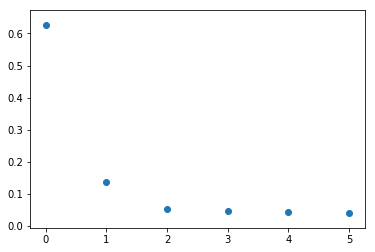

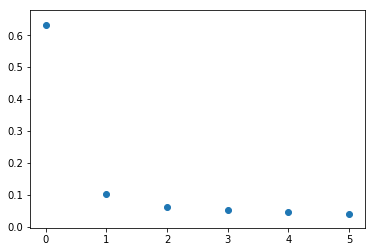

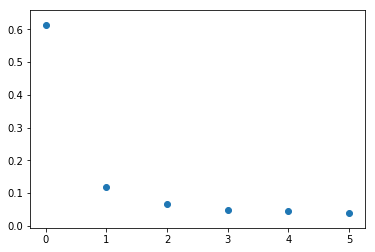

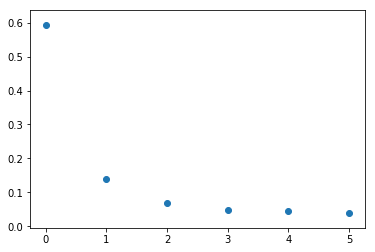

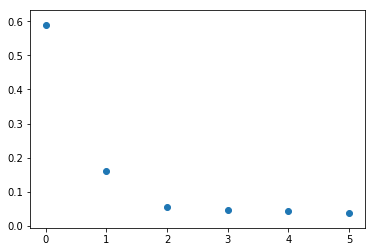

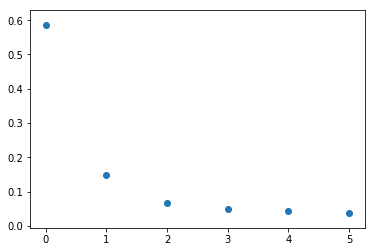

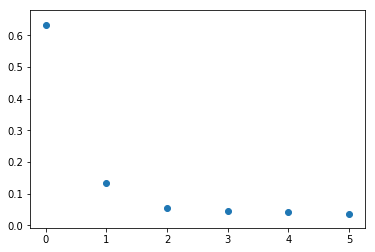

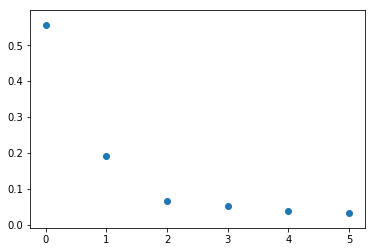

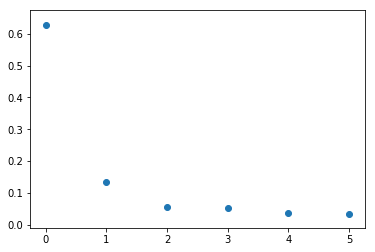

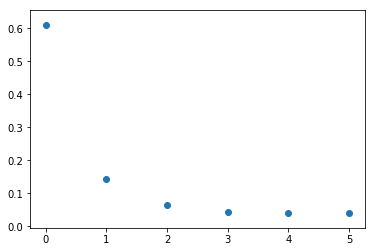

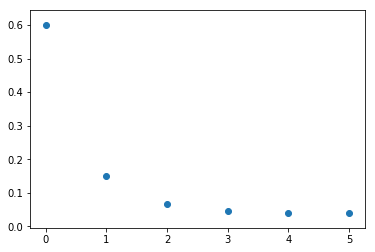

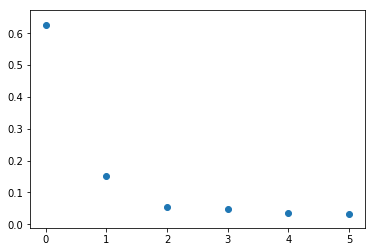

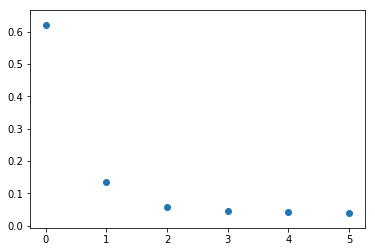

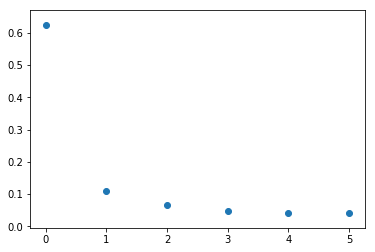

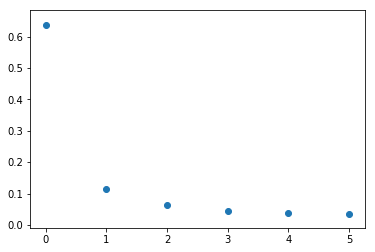

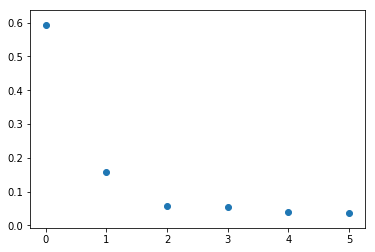

In [96]:
import matplotlib.pyplot as plt

for model in pca_models:
    xs = np.arange(0,len(model.explained_variance_ratio_),1)
    ys = model.explained_variance_ratio_
    plt.scatter(xs, ys)

    plt.show()

In [81]:
for model in micro_pca_models[0]:
    df = pd.DataFrame(model.components_, columns=all_candidate_features)#all_scalar_features)
    display(df)
    
    loadings = model.components_.T * np.sqrt(model.explained_variance_ratio_)
    df2 = pd.DataFrame(list(zip(*loadings)), columns=all_candidate_features)#all_scalar_features)
    display(df2.sum().abs())
    
    print(loadings.shape)
    
    
    stop

,Area,Mean,IntDen,D,nBranches,nJunctions,nEnds,nJuncVoxels,nSlab,aveBranch,nTriple,nQuad,maxBranch,totalBranchLength,cell_counts,ave_nnd,ave_soma_size,ave_soma_circularity
0,-0.281283,-0.196908,-0.278871,-0.127104,-0.296339,-0.277242,-0.277939,-0.270812,-0.290787,-0.238957,-0.272389,-0.190645,-0.247080,-0.262902,-0.178916,-0.094420,-0.175395,-0.137328
1,-0.056549,0.404768,0.218342,0.000510,-0.006731,0.054823,-0.079444,0.065159,-0.019573,-0.208109,0.039952,0.102290,-0.208897,-0.127608,0.434509,-0.521165,0.048554,-0.439592
2,0.067028,0.012745,0.039864,-0.215177,0.018642,0.222882,-0.235675,0.242276,0.081367,-0.435551,0.207673,0.213360,-0.384054,-0.339546,-0.006780,0.404433,0.163050,0.212669
3,0.078440,-0.436268,-0.132348,-0.067454,0.142207,0.218161,0.018992,0.247067,0.092293,-0.069652,0.189706,0.294185,-0.067411,0.066821,-0.175302,-0.336675,-0.588219,-0.131291
4,0.023942,0.023397,0.032750,-0.957083,0.012211,-0.021490,0.052194,-0.025609,0.046972,0.151000,-0.014094,-0.038109,0.145847,0.098329,0.006839,-0.025740,0.073651,-0.118641
5,0.019657,-0.091604,-0.003702,0.105251,0.045615,0.065947,0.015544,0.070392,-0.003571,-0.000575,0.059311,0.096692,-0.010695,0.053313,-0.552842,0.086754,0.460231,-0.653984
6,-0.146445,0.064179,-0.076413,-0.008891,-0.061669,-0.181110,0.036665,-0.069991,-0.108853,0.086625,-0.348650,0.872151,0.054959,0.064114,0.052065,0.066740,0.068487,0.071595
7,-0.397434,0.261698,-0.198034,-0.053090,0.118260,0.137032,0.084851,0.141229,-0.197090,-0.060243,0.153080,-0.024678,-0.097671,0.184467,-0.360216,-0.428826,0.246677,0.432475
8,-0.489395,0.334832,-0.160345,0.001792,0.097088,0.122520,0.049949,0.106253,-0.143595,0.018595,0.140497,-0.053149,-0.018803,0.257426,0.093842,0.488869,-0.381426,-0.284620
9,0.174385,0.537297,0.314385,-0.006255,-0.126504,-0.054069,-0.203860,-0.076967,0.176657,0.028271,-0.062002,0.054703,0.131700,-0.155727,-0.532180,-0.012733,-0.384294,0.064163


Area                    0.314884
Mean                    0.024963
IntDen                  0.211113
D                       0.361200
nBranches               0.194926
nJunctions              0.070739
nEnds                   0.336397
nJuncVoxels             0.033714
nSlab                   0.195996
aveBranch               0.324186
nTriple                 0.107747
nQuad                   0.178030
maxBranch               0.311083
totalBranchLength       0.246147
cell_counts             0.226890
ave_nnd                 0.180371
ave_soma_size           0.141361
ave_soma_circularity    0.335531
dtype: float64

(18, 11)


NameError: name 'stop' is not defined

In [23]:
write_cluster_files_groupby_boxsize_threshold(gfap_clusters_treat,cell='gfap',path="E:/lab_files/imageJ_macro_working_directory/Gfap_S100b_Nestin/output/gfap/cluster_files/cluster_coordinates"
                                                  ,clusters=['proximal_clusters'])

single_threshold\150\
proximal_clusters
JS12v3_7D_FUS_gfap_sec2.txt
proximal
JS12v3_7D_FUS_gfap_sec4.txt
proximal
JS12v3_7D_FUS_gfap_sec6.txt
proximal
JS12v3_7D_FUS_gfap_sec8.txt
proximal
JS12v3_7D_noFUS_gfap_sec2.txt
proximal
JS12v3_7D_noFUS_gfap_sec4.txt
proximal
JS12v3_7D_noFUS_gfap_sec6.txt
proximal
JS12v3_7D_noFUS_gfap_sec8.txt
proximal
JS13v3_7D_FUS_gfap_sec2.txt
proximal
JS13v3_7D_FUS_gfap_sec4.txt
proximal
JS13v3_7D_FUS_gfap_sec6.txt
proximal
JS13v3_7D_FUS_gfap_sec8.txt
proximal
JS13v3_7D_noFUS_gfap_sec2.txt
proximal
JS13v3_7D_noFUS_gfap_sec4.txt
proximal
JS13v3_7D_noFUS_gfap_sec6.txt
proximal
JS13v3_7D_noFUS_gfap_sec8.txt
proximal
JS14v3_7D_FUS_gfap_sec2.txt
proximal
JS14v3_7D_FUS_gfap_sec4.txt
proximal
JS14v3_7D_FUS_gfap_sec6.txt
proximal
JS14v3_7D_FUS_gfap_sec8.txt
proximal
JS14v3_7D_noFUS_gfap_sec2.txt
proximal
JS14v3_7D_noFUS_gfap_sec4.txt
proximal
JS14v3_7D_noFUS_gfap_sec6.txt
proximal
JS14v3_7D_noFUS_gfap_sec8.txt
proximal
JS16v3_7D_FUS_gfap_sec2.txt
proximal
JS16v3_7D_F

In [240]:
#write microglia cluster files
_set = 'Iba1_set2'
write_cluster_files_groupby_boxsize_threshold(micro_clusters,cell='microglia',path=f"E:/lab_files/imageJ_macro_working_directory/Iba1_ML_re/Iba1_set1_19-3-23/output/{_set}/cluster_files/cluster_coordinates/"
                                                  ,clusters=['proximal_clusters','focal_clusters','subtracted_clusters','combined_clusters'])

single_threshold/150/
proximal_clusters
JS12_7D_FUS_microglia_sec2.txt
JS12_7D_FUS_microglia_sec4.txt
JS12_7D_FUS_microglia_sec6.txt
JS12_7D_FUS_microglia_sec8.txt
('JS12', '7D', 'FUS', 'microglia', 'sec8') no clusters
JS12_7D_noFUS_microglia_sec2.txt
('JS12', '7D', 'noFUS', 'microglia', 'sec2') no clusters
JS12_7D_noFUS_microglia_sec4.txt
('JS12', '7D', 'noFUS', 'microglia', 'sec4') no clusters
JS12_7D_noFUS_microglia_sec6.txt
('JS12', '7D', 'noFUS', 'microglia', 'sec6') no clusters
JS12_7D_noFUS_microglia_sec8.txt
('JS12', '7D', 'noFUS', 'microglia', 'sec8') no clusters
JS13_7D_FUS_microglia_sec2.txt
JS13_7D_FUS_microglia_sec4.txt
('JS13', '7D', 'FUS', 'microglia', 'sec4') no clusters
JS13_7D_FUS_microglia_sec6.txt
JS13_7D_FUS_microglia_sec8.txt
('JS13', '7D', 'FUS', 'microglia', 'sec8') no clusters
JS13_7D_noFUS_microglia_sec2.txt
('JS13', '7D', 'noFUS', 'microglia', 'sec2') no clusters
JS13_7D_noFUS_microglia_sec4.txt
('JS13', '7D', 'noFUS', 'microglia', 'sec4') no clusters
JS13_7D

wrote unclustered
JS16_7D_FUS_microglia_sec2.txt
JS16_7D_FUS_microglia_sec4.txt
('JS16', '7D', 'FUS', 'microglia', 'sec4') no clusters
wrote unclustered
JS16_7D_FUS_microglia_sec6.txt
('JS16', '7D', 'FUS', 'microglia', 'sec6') no clusters
wrote unclustered
JS16_7D_FUS_microglia_sec8.txt
('JS16', '7D', 'FUS', 'microglia', 'sec8') no clusters
wrote unclustered
JS16_7D_noFUS_microglia_sec2.txt
('JS16', '7D', 'noFUS', 'microglia', 'sec2') no clusters
wrote unclustered
JS16_7D_noFUS_microglia_sec4.txt
('JS16', '7D', 'noFUS', 'microglia', 'sec4') no clusters
wrote unclustered
JS16_7D_noFUS_microglia_sec6.txt
('JS16', '7D', 'noFUS', 'microglia', 'sec6') no clusters
wrote unclustered
JS16_7D_noFUS_microglia_sec8.txt
('JS16', '7D', 'noFUS', 'microglia', 'sec8') no clusters
wrote unclustered


In [23]:
micro_clusters

,CellType,ID,Day,Section,Treatment,BX,BY,boxID,index,Boxsize,...,pca_6,pca_7,pca_8,pca_9,outlier,proximal_clusters,focal_clusters,combined_clusters,subtracted_clusters,unclustered
0,microglia,JS12,7D,sec2,noFUS,1800.0,100.0,6759,2,150,...,0.177283,-0.022890,-0.603625,-0.153079,1,-1,-1,-1,-1,1
1,microglia,JS12,7D,sec2,noFUS,1900.0,100.0,6760,3,150,...,0.051855,-0.305000,0.396862,0.119113,1,-1,-1,-1,-1,1
2,microglia,JS12,7D,sec2,noFUS,2000.0,100.0,6761,4,150,...,0.494073,0.761983,0.685581,0.003669,1,-1,-1,-1,-1,1
3,microglia,JS12,7D,sec2,noFUS,2100.0,100.0,6762,5,150,...,0.210133,-0.894482,0.352566,-0.099691,1,-1,-1,-1,-1,1
4,microglia,JS12,7D,sec2,noFUS,2200.0,100.0,6763,6,150,...,-0.625982,0.034028,0.259073,0.116534,1,-1,-1,-1,-1,1
5,microglia,JS12,7D,sec2,noFUS,2300.0,100.0,6764,7,150,...,0.068233,0.802557,0.331693,-0.254499,1,-1,-1,-1,-1,1
6,microglia,JS12,7D,sec2,noFUS,2400.0,100.0,6765,8,150,...,-0.350956,-0.294253,-0.057598,-0.073741,1,-1,-1,-1,-1,1
7,microglia,JS12,7D,sec2,noFUS,2500.0,100.0,6766,9,150,...,0.024875,-0.223862,0.058650,0.078107,1,-1,-1,-1,-1,1
8,microglia,JS12,7D,sec2,noFUS,1600.0,200.0,6767,10,150,...,0.034802,0.077740,0.266441,1.468139,-1,-1,-1,-1,-1,1
9,microglia,JS12,7D,sec2,noFUS,1700.0,200.0,6768,11,150,...,0.120571,-0.006808,0.743699,0.413676,1,-1,-1,-1,-1,1


In [14]:
def plot_mice(sec,features=["BX","BY"],colour_features=["proximal_clusters"],density_plot=False,xlabel=None,ylabel=None,
              colours=None,size=None,labels=None):
    if sec is type(list):
        print("not implemented")
    else:
        if density_plot:
            sec = set_colours(sec,colour_features=colour_features)
            fig, ax = plt.subplots()
            if colours:
                cmaps = iter(colours)
            else:
                cmaps = iter(['Reds','Blues','Greens','Purples'])
            for indexes, df in sec.groupby(["colour_label","colour_categories"]):
                Xs=df[features[0]]
                Ys=df[features[1]]
                sns.kdeplot(Xs, Ys, cmap=next(cmaps), shade=False, bw=.15)
        else:
            fig = plt.figure()
            ax1 = plt.subplot(111)
            ax1.set_xlabel(xlabel)
            ax1.set_ylabel(ylabel)
            sec = set_colours(sec,colour_features=colour_features)
            print(sec)
            n = len(np.unique(sec["colour_categories"]))
            if colours:
                colours = iter(colours)
            else:
                colours=iter(cm.rainbow(np.linspace(0,1,n)))
            if labels:
                labels = iter(labels)
            for indexes, df in sec.groupby(["colour_label","colour_categories"]):
                Xs=df[features[0]]
                Ys=df[features[1]]
                c = next(colours)
                if labels:
                    label = next(labels)
                else:
                    label = indexes[0]
                ax1.scatter(Xs,Ys,c=c,label=label)
        plt.legend()
        plt.show()
                
def plot_biplot(sec,features=["BX","BY"],
                colour_features=["proximal_clusters","unclustered"],
                label_clusters=True,
                plot_features=False,
                control="noFUS",treatment="FUS",
                cmap='viridis',vmin=None,vmax=None):
    
    fig = plt.figure()
    
    ax1 = plt.subplot(121)
    ax2 = plt.subplot(122)
    #fig.gca().invert_yaxis()
    if label_clusters:
        sec = set_colours2(sec,colour_features=colour_features)
        n = len(np.unique(sec["colour_categories"]))
        colours = iter(cm.rainbow(np.linspace(0,1,n)))
        
    p1 = sec.loc[sec["Treatment"]==control]
    p2 = sec.loc[sec["Treatment"]==treatment]
    ID_sec = sec[['ID','Section']].iloc[0].values
    graph_title = ID_sec[0]+"_"+ID_sec[1]
    
    if plot_features:
        print('only 3D')
        for ax, p in zip([ax1,ax2],[p1,p2]):
            p = p[features]
            pivot = p.pivot(features[0],features[1],features[2])
            #print(pivot)
            sns.heatmap(pivot,annot=False,ax=ax,cmap=cmap,vmin=vmin,vmax=vmax)
                
    else:
        for ax, p in zip([ax1,ax2],[p1,p2]):
            #p = set_colours(p,colour_features=colour_features)
            for indexes, df in p.groupby(["colour_categories"]):
                #print(indexes)
                #print(p['Treatment'].unique())
                #print(p['colour_label'].unique())
                Xs=df[features[0]]
                Ys=df[features[1]]
                c = next(colours)
                print(df['colour_label'].unique())
                ax.scatter(Xs,Ys,c=c,label=df['colour_label'].unique()[0])
                ax.legend()
    plt.suptitle(graph_title)
    plt.show()
        

def set_colours2(sec,colour_features=['proximal_clusters','unclustered'],treatment_col='Treatment'):
    sec = sec.set_index(colour_features+[treatment_col])
    cat = 0
    levels =colour_features+[treatment_col]
    for index, df in sec.groupby(level = levels):
        #print(index)
        sec.loc[index,'colour_categories'] = cat
        cat_label = index[-1]
        _ = np.array(index[:-1])
        if 1 in _:
            cat_label += "_" + levels[np.where(_ == 1)[0][0]]
        else:
            cat_label += "_" + levels[np.where(_ == -1)[0][0]]
        sec.loc[index,'colour_label'] = " ".join(map(str,index))
        cat+=1
    return sec.reset_index()

def get_section(mice,ID,sec):
    return mice.loc[(mice["ID"]==ID) & (mice["Section"]==sec)]

print('done')


done


In [22]:
###
# plot clusters
#################
ctrl='L'
trt='R'

ctrl = 'noFUS'
trt = 'FUS'
#thresh='single_threshold'
boxsize=150

#test = branch_df[branch_df['ID']=='JS12']


#for cluster in [gfap_clusters]:
#for cluster in [gfap_clusters_treat]:
#    for ID in ['JS12v3','JS13v3','JS14v3','JS16v3']:


for cluster in [ micro_clusters ]:
#for cluster in [micro_untreated]:
    for ID in ['JS13']:
    #for ID in ['JS17v2']:
        
        print(np.unique(cluster['Section']))
        print(list(np.unique(cluster['Section'])))
        #for sec in ['sec4','sec2']:
        #for sec in ['sec2re']:
        for sec in list(np.unique(cluster['Section'])):
            for thresh in ['single_threshold']:
                s = get_section(cluster,ID,sec)
                s = s.loc[s['Threshold']==thresh]
                s = s.loc[s['Boxsize']==boxsize]
                '''
                for i in ['L','R']:
                    x=s.loc[s['Treatment']==i,'ave_nnd'].dropna()
                    plt.hist(x, normed=True, bins=15)
                    plt.show()
                '''
                f = 'ave_soma_circularity'
                plot_biplot(s,features=['BX','BY',f],colour_features=['proximal_clusters','focal_clusters'],control=ctrl,treatment=trt,plot_features=False,vmin=-2,vmax=2,label_clusters=True)
                
#['Area', 'Mean','IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds','nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'totalBranchLength',
#'cell_counts','ave_nnd', 'ave_soma_size', 'ave_soma_circularity']

NameError: name 'micro_clusters' is not defined

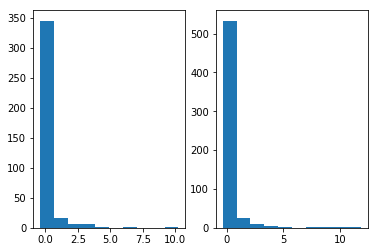

In [27]:
def plot_histograms(df,ID='JS59v3',day='untreated',sec='sec2',measure='Circ.'):
    fig = plt.figure()
    
    ax1 = plt.subplot(121)
    ax2 = plt.subplot(122)
    plots = [ax1,ax2]
    
    ind = 0
    df_sec = df.loc[(df['ID']==ID) & (df['Day']==day) & (df['Section']==sec)]
    for trt, data in df_sec.groupby('Treatment'):
        plots[ind].hist(data[measure])
        ind += 1
    
    plt.show()
    
plot_histograms(gfap_clusters)
        

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


['sec2' 'sec4' 'sec6' 'sec8']
['sec2', 'sec4', 'sec6', 'sec8']
['-1 noFUS']
['-1 FUS']
['1 FUS']


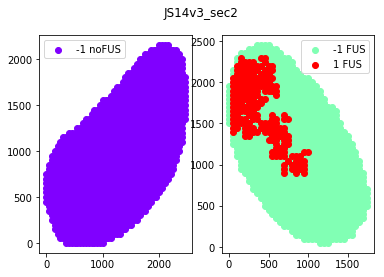

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


['-1 noFUS']
['-1 FUS']
['1 FUS']


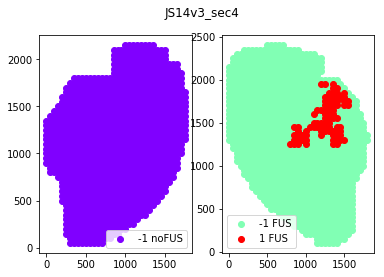

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


['-1 noFUS']
['-1 FUS']
['1 FUS']


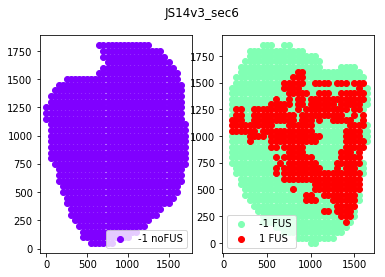

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


['-1 noFUS']
['-1 FUS']
['1 FUS']


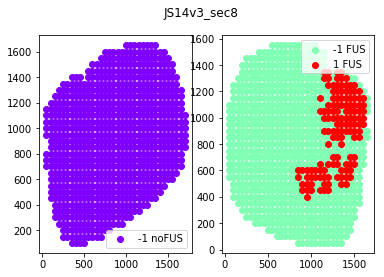

In [176]:
#ctrl='L'
#trt='R'

ctrl = 'noFUS'
trt = 'FUS'
#thresh='single_threshold'
boxsize=150

#test = branch_df[branch_df['ID']=='JS12']


#for cluster in [gfap_clusters]:
#for cluster in [gfap_clusters_treat]:
#    for ID in ['JS12v3','JS13v3','JS14v3','JS16v3']:
    
for cluster in [gfap_clusters_treat]:
    for ID in ['JS14v3']: #'JS13v3','JS12v3','JS16v3',
    #for ID in ['JS14v3']:
    #for ID in ['JS59v3', 'JS67v3']:
        
        print(np.unique(cluster['Section']))
        print(list(np.unique(cluster['Section'])))
        #for sec in ['sec4','sec2']:
        #for sec in ['sec2re']:
        for sec in list(np.unique(cluster['Section'])):
            for thresh in ['single_threshold']:
                s = get_section(cluster,ID,sec)
                s = s.loc[s['Threshold']==thresh]
                s = s.loc[s['Boxsize']==boxsize]
                '''
                for i in ['L','R']:
                    x=s.loc[s['Treatment']==i,'ave_nnd'].dropna()
                    plt.hist(x, normed=True, bins=15)
                    plt.show()
                '''
                f = 'nJuncVoxels'
                plot_biplot(s,features=['BX','BY',f],colour_features=['proximal_clusters'],control=ctrl,treatment=trt,plot_features=False,vmin=-2,vmax=2,label_clusters=True)
                
                
#['IntDen',"D",'totalBranchLength','Area','Mean','nBranches','nJunctions','nEnds','nSlab','aveBranch','nTriple','nQuad','maxBranch']

6
(1.0, 0.0)


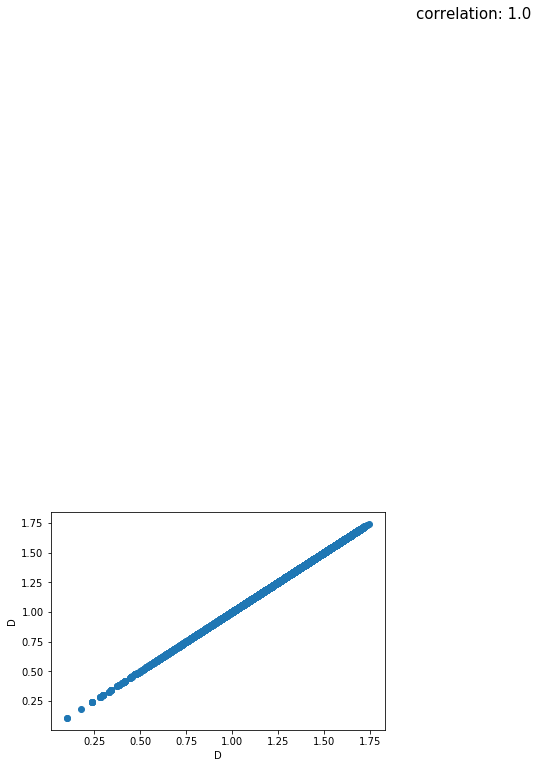

(0.3999214079690627, 0.0)


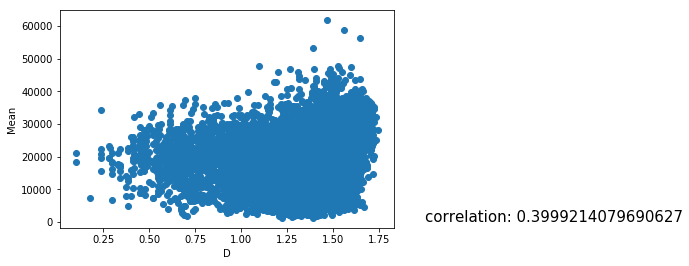

(0.522172995906277, 0.0)


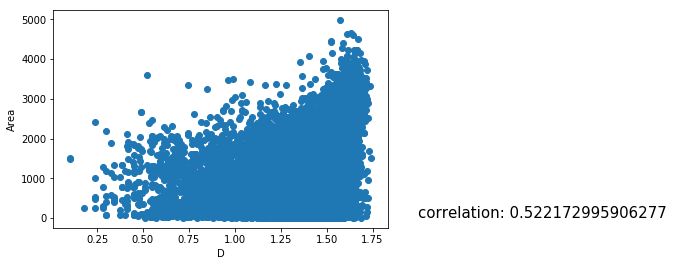

(0.46629848291095555, 0.0)


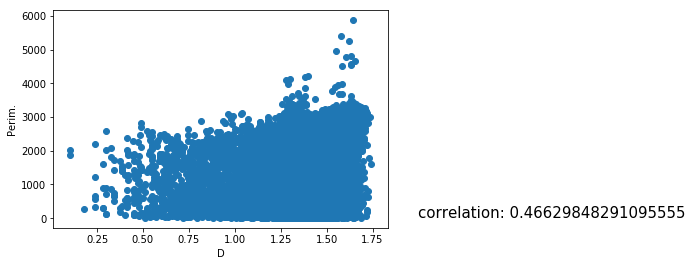

(0.3592345024569481, 0.0)


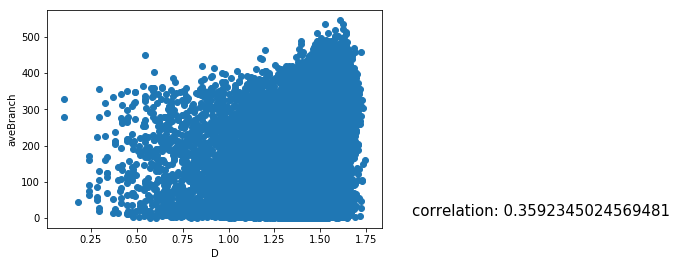

(0.4926171245997051, 0.0)


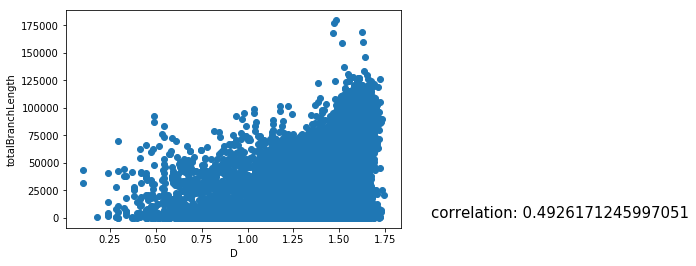

(0.3999214079690627, 0.0)


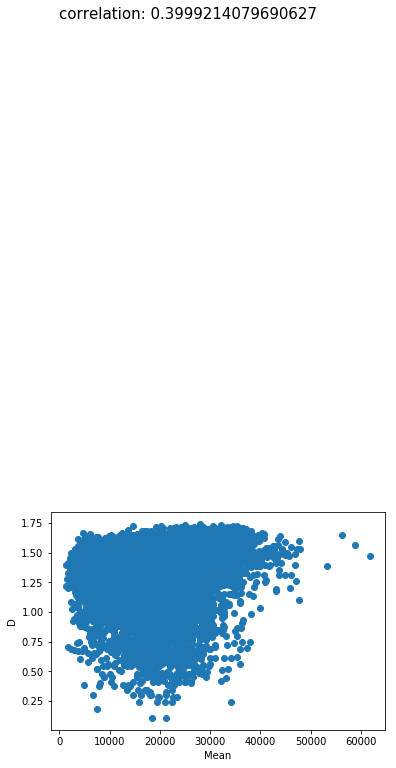

(1.0, 0.0)


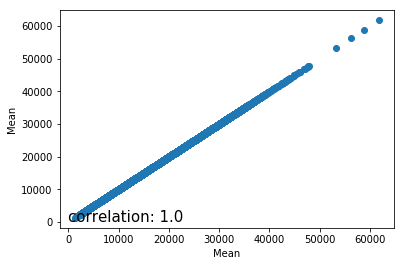

(0.6132631032505317, 0.0)


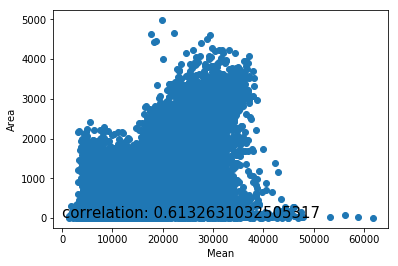

(0.3423628223592748, 0.0)


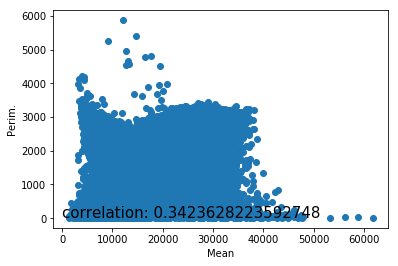

(0.17253013712695978, 0.0)


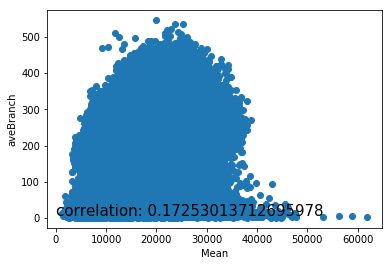

(0.3815797155501312, 0.0)


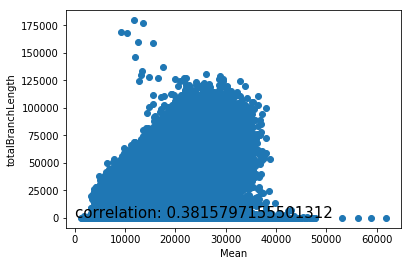

(0.522172995906277, 0.0)


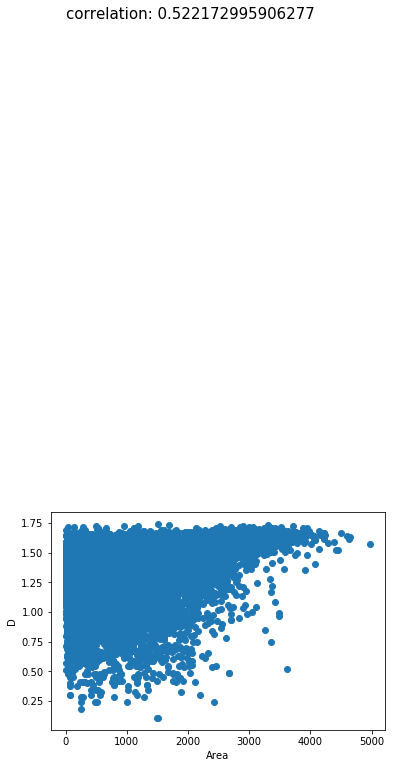

(0.6132631032505317, 0.0)


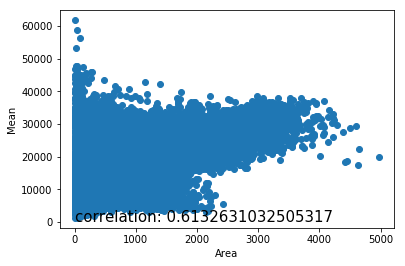

(1.0, 0.0)


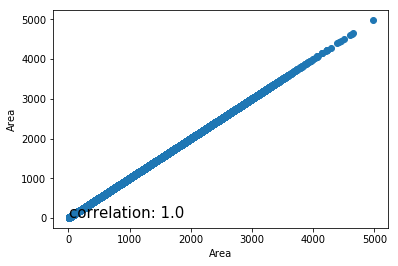

(0.8979530840467668, 0.0)


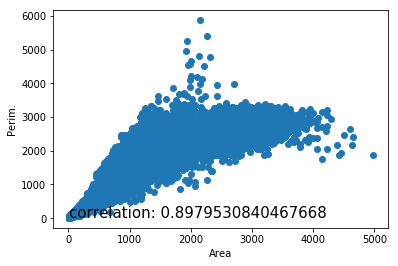

(0.6888278102745716, 0.0)


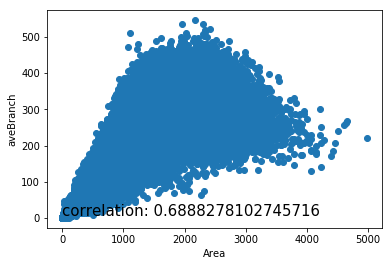

(0.8523754710348137, 0.0)


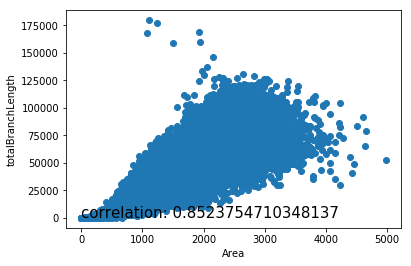

(0.46629848291095555, 0.0)


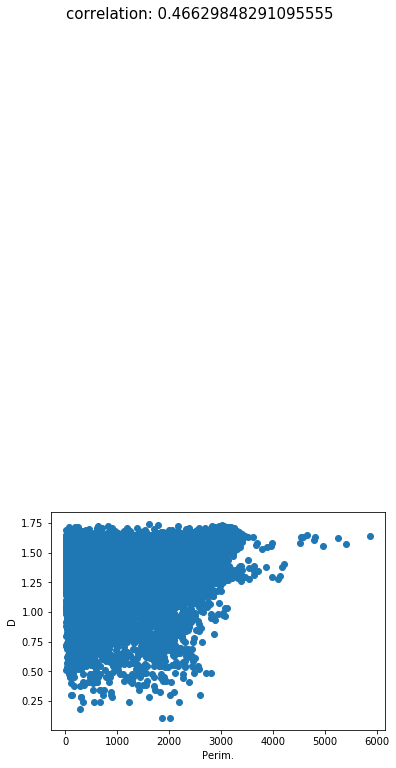

(0.3423628223592748, 0.0)


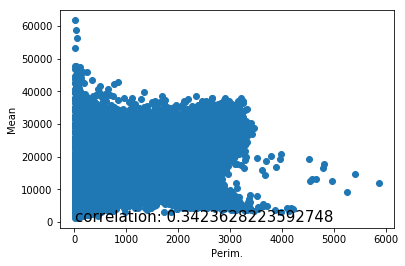

(0.8979530840467668, 0.0)


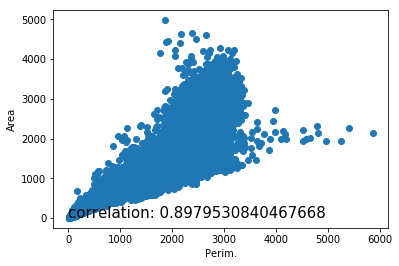

(1.0, 0.0)


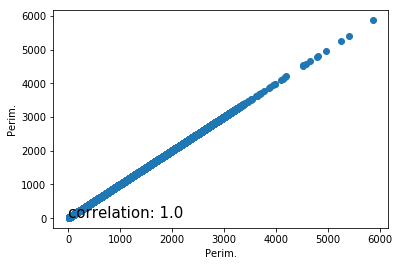

(0.8698762908170191, 0.0)


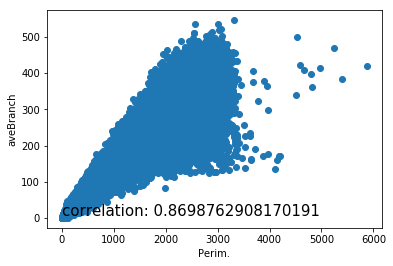

(0.9163651021854, 0.0)


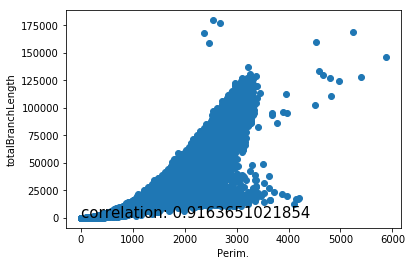

(0.3592345024569481, 0.0)


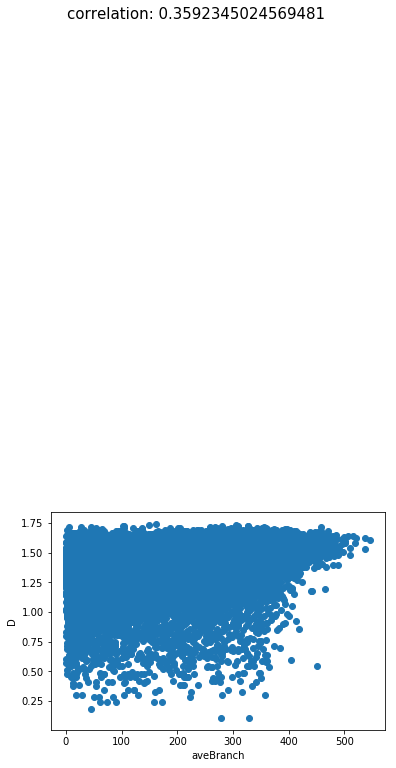

(0.17253013712695978, 0.0)


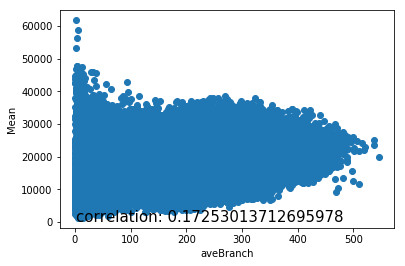

(0.6888278102745716, 0.0)


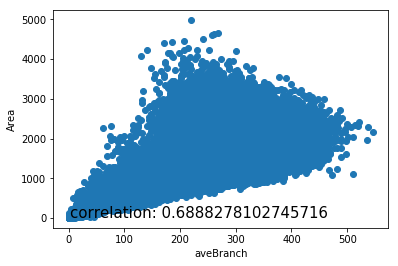

(0.8698762908170191, 0.0)


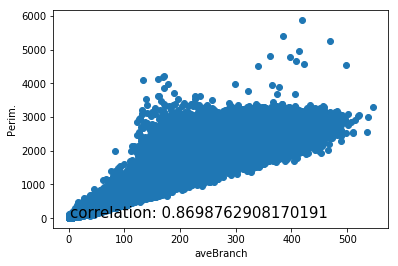

(1.0, 0.0)


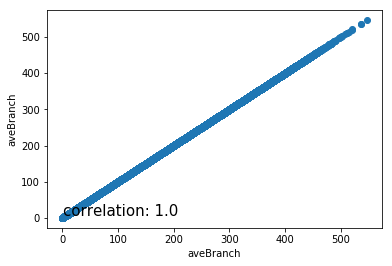

(0.875361803728503, 0.0)


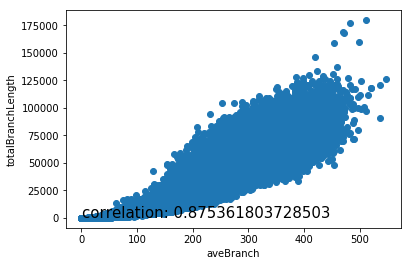

(0.4926171245997051, 0.0)


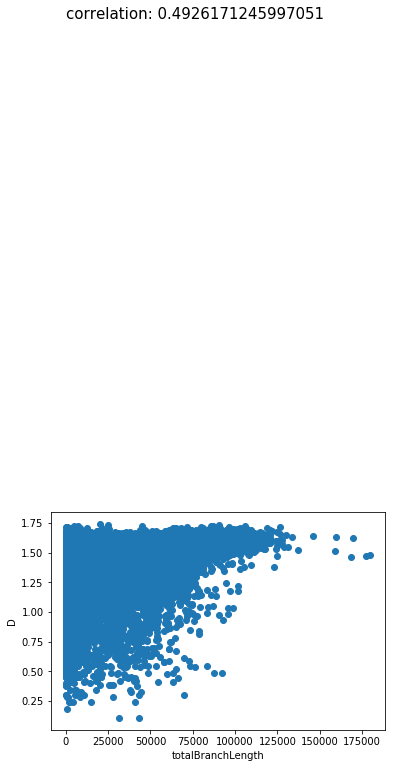

(0.3815797155501312, 0.0)


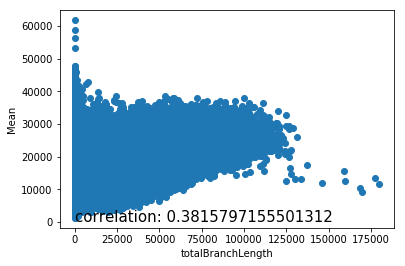

(0.8523754710348137, 0.0)


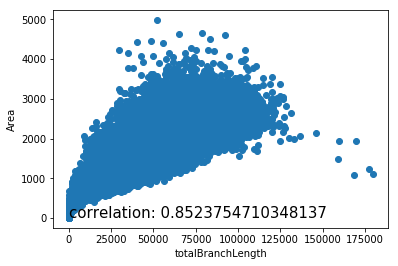

(0.9163651021854, 0.0)


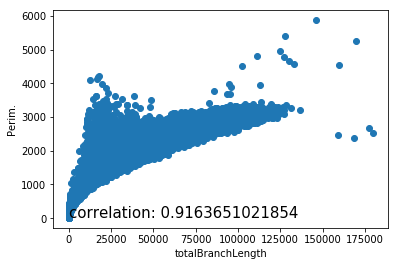

(0.875361803728503, 0.0)


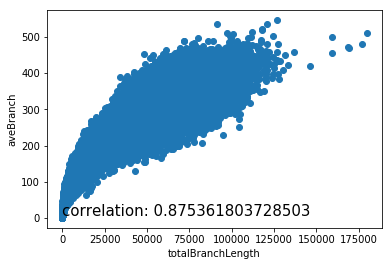

(1.0, 0.0)


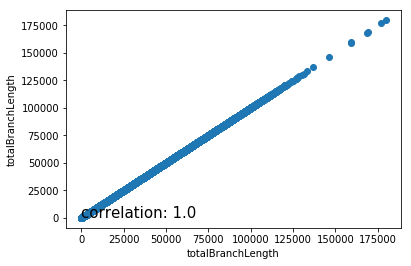

In [230]:
import scipy.stats as sp

#'nBranches','nJunctions','nEnds','nJuncVoxels','nSlab','aveBranch','nTriple','maxBranch','totalBranchLength','Mean'
#all_feats = ['D','Median','Mean','IntDen','aveBranch','totalBranchLength','Area']
#all_feats = ['nEnds','Area','D']

all_feats = ['D','Mean','Area','Perim.','aveBranch','totalBranchLength']
plots = []
ind = 0
fig = plt.figure()

print(len(all_feats))

test = df_gfap[all_feats].dropna()

for i in range(1,len(all_feats)+1):
    for j in range(1,len(all_feats)+1):
        
        
        f1 = all_feats[i-1]
        f2 = all_feats[j-1]
        
        
        
        '''
        print(f1)
        print(f2)
        #feat1 = 'totalBranchLength'
        #feat2 = 'nTriple'
        corr = sp.pearsonr(test[f1],test[f2])
        print(corr)  
        pos = (i)*100 + len(all_feats)*10 + j
        print(pos)
        plots.append(fig.add_subplot(pos))
        plots[ind].scatter(test[feat1],test[feat2])
        plots[ind].text(2, 6, f'correlation: {corr[0]}', fontsize=15)
        '''
        corr = sp.pearsonr(test[f1],test[f2])
        
        print(corr)
        plt.scatter(test[f1],test[f2])
        plt.text(2, 6, f'correlation: {corr[0]}', fontsize=15)
       
        
        plt.xlabel(f1)
        plt.ylabel(f2)
        #ind += 1
        plt.show()

In [105]:
###
# microglia_cluster PCA PLOT
#################
#'''

'''
start = time.time()
con = microglia_clusters_re.loc[microglia_clusters_re['Treatment'] == 'noFUS']
trt = microglia_clusters_re.loc[microglia_clusters_re['Treatment'] == 'FUS']
end = time.time()
'''

def plot_cluster_pca_density(_clusters,threshold='paired_threshold',ID='JS12',sec='sec2',cell='microglia',
                             control='noFUS',treatment='FUS',
                             colour_features=["focal_clusters","subtracted_clusters","unclustered"],
                             labels=['focal','proximal','distal','untreated'],
                            colours=['Reds','Blues','Greens','Purples'],
                            density_plot=True):
    con = _clusters.loc[(_clusters['Treatment'] == control) & (_clusters['Threshold'] == threshold)] #single_paired
    trt = _clusters.loc[(_clusters['Treatment'] == treatment) & (_clusters['Threshold'] == threshold)] #single_paired
    print(con.head())
    con, trt = pca_section(con,trt,n_comps=2,features=["Mean","D","ave_soma_size","ave_nnd"])
    pca_sec = pd.concat([con,trt],ignore_index=True)
    plot_pca = pca_sec.loc[~((pca_sec['Treatment']=='noFUS')&(pca_sec['subtracted_clusters']==1))]

    _sec = plot_pca.loc[(pca_sec['ID'] == ID) & (pca_sec['Section'] == sec)]
    '''
    plot_mice(micro_sec,features=["pca_1","pca_2"],colour_features=["focal_clusters","subtracted_clusters","unclustered"],
              xlabel='pca component 1', ylabel = 'pca component 2', colours=['red','orange','blue','gray'],labels=['focal','proximal','distal','untreated'])
    '''
    plot_mice(_sec,features=["pca_1","pca_2"],colour_features=colour_features,
              xlabel='pca component 1', ylabel = 'pca component 2',labels=labels,density_plot=density_plot)

    '''
    ID = 'JS6'
    sec = 'sec2'

    astro_sec = astrocyte_clusters_re.loc[(astrocyte_clusters_re['ID'] == ID) & (astrocyte_clusters_re['Section'] == sec)]
    test_astros = astrocyte_clusters_re.loc[~((astrocyte_clusters_re['Treatment']=='noFUS')&(astrocyte_clusters_re['proximal_clusters']==1))]
    plot_mice(astro_sec,features=['Mean','D'],
              colour_features=['proximal_clusters','unclustered'],xlabel='Mean',ylabel='Fractal Complexity',
             colours=['orange','blue','gray'], labels=['proximal','distal','untreated'])

    '''
#_clusters = 
plot_cluster_pca_density(micro_clusters,threshold='single_threshold',sec='sec4',density_plot=True)


AttributeError: 'list' object has no attribute 'loc'

In [168]:
from sklearn.model_selection import ParameterGrid


def setup_grid_ranges(gamma_range=[0.05,0.15,0.05],nu_range=[0.05,0.2,0.05],minN_range=[10,25,2], nfeat=None):
    gammas = np.arange(gamma_range[0],gamma_range[1],gamma_range[2])
    nus = np.arange(nu_range[0],nu_range[1],nu_range[2])
    minNs = np.arange(minN_range[0],minN_range[1],minN_range[2])
    
    #order gammas > nus > minNs > nfeats 
    param_grid = {'nu' : nus,
             'minN' : minNs,
             'gamma' : gammas}
    
    if nfeat:
        nfeats = np.arange(nfeat[0],nfeat[1],nfeat[2])
        param_grid['nPCs'] = nfeats
        
    print(param_grid)
    '''
    nu_repeat = np.repeat(nus, len(minNs))
    nu_tile = np.tile(nu_repeat,len(gammas))
    minN_repeat = np.tile(minNs, len(nus))
    minN_tile = np.tile(minN_repeat,len(gammas))
    gamma_repeat = np.repeat(gammas,len(nu_repeat))
    
    re = pd.DataFrame(list(zip(gamma_repeat,nu_tile,minN_tile)),columns=['gamma','nu','minN'])
    '''
    
    take2 = pd.DataFrame(list(ParameterGrid(param_grid)), columns=param_grid.keys())
    return take2


def grid_search2(mice,cell="microglia",features=[],control="L",treatment="R",reciprocal=False,
               kernel='rbf', gamma_range=[0.05,0.11,0.05],nu_range=[0.06,0.17,0.02], minN_range=[14,26,2],
                 pca=False, n_pca_range = [6,13,3],
               focal_cluster=False,focal_minN=5,focal_feature="IntDen",
               train_predict=False):
    
    mice = set_box_id(mice)
    
    print('... setting up grid ranges ...')
    
    if pca:
        grids = setup_grid_ranges(gamma_range = gamma_range, nu_range=nu_range, minN_range = minN_range, nfeat=n_pca_range)
    else:
        grids = setup_grid_ranges(gamma_range = gamma_range, nu_range=nu_range, minN_range = minN_range)
    
    grids.loc[:,'cluster_size'] = 0
    grids.loc[:,'num_outliers'] = 0
    
    
    iterations = 0
    num_iterations = len(grids)
    print(f"----- number of iterations: {num_iterations} -----")
    
    clusters = []
    
    levels=['gamma','nu','minN']
    if pca:
        grids = grids.set_index(['gamma','nu','minN','nPCs'])
        levels=['gamma','nu','minN','nPCs']
    else:
        grids = grids.set_index(['gamma','nu','minN'])
        levels=['gamma','nu','minN']
        
    for indexes, df in grids.groupby(level=levels):
        st = time.time()
        g = indexes[0]
        n = indexes[1]
        m = indexes[2]
        if pca:
            nfeat = indexes[3]
        clust = iter_all(mice,cells=[cell],features=features,control=control,treatment=treatment,
                         kernel=kernel,gamma=g,nu=n,minN=m,pca=pca,n_comps=nfeat,return_pca_model=False,
                         focal_cluster=focal_cluster, focal_minN=focal_minN, focal_feature=focal_feature,
                         train_predict=train_predict)
        
        clust.loc[:,'gamma'] = g
        clust.loc[:,'nu'] = n
        clust.loc[:,'min'] = m
        if pca:
            clust.loc[:,'nPCs'] = nfeat
            
        clusters.append(clust)
        
        if reciprocal:
        
            clust = iter_all(mice,cells=[cell],features=features,control=treatment,treatment=control,
                                    kernel=kernel,gamma=g,nu=n,minN=m,pca=pca,n_comps=nfeat,
                                   focal_cluster=focal_cluster,focal_minN=focal_minN,focal_feature=focal_feature,
                            train_predict=train_predict)
            clust_size = len(clust.loc[clust['proximal_clusters'] > -1])
            clust.loc[:,'gamma'] = g
            clust.loc[:,'nu'] = n
            clust.loc[:,'min'] = m
            clusters.append(clust)   
            
        iterations += 1
        if (iterations % 50) == 0:
            print(f"progress.. {iterations}/{num_iterations}")
        print(f"===== TIME FOR ITERATION {time.time()-st} =====")
    return pd.concat(clusters)

      
def plot_grid(grids,splitby='gamma',x='minN',y='nu',z='cluster_size',cmap='spectral',vmin=0,vmax=None):
    splits = grids.index.get_level_values(splitby).unique()
    fig = plt.figure()
    grids = grids[z]
    print(grids)
    for plc, s in zip(range(len(splits)),splits):
        grid = grids.xs(s,level=splitby)
        grid = grid.reset_index()
        sub = 100 + len(splits)*10 + 1 +plc
        ax = fig.add_subplot(sub)
        #ax.title = s
        grid = grid.pivot(x, y, z)
        ax = sns.heatmap(grid,cmap=cmap,vmin=vmin,vmax=vmax)
    plt.show()

def rank_feats(grid,features=["Mean","IntDen","D"],target_feature="proximal_clusters"):
    corrs = {}
    target = grid[target_feature].convert_objects(convert_numeric=True)
    for f in features:
        result = stats.pointbiserialr(grid[f], target)
        corrs[f] = result
    return corrs

def find_top_parameters(sumgrid,control="noFUS",treatment="FUS",maxTreat=True,top=5):
    con_zeroes = sumgrid.loc[(sumgrid["clusters"]==0) & (sumgrid["Treatment"]==control)].set_index(["gamma","nu","minN"])
    treat = sumgrid.loc[(sumgrid["Treatment"]==treatment)].set_index(["gamma","nu","minN"])
    treat_cut = treat.loc[con_zeroes.index,:]
    return treat_cut.sort_values(by="clusters",ascending=not(maxTreat)).iloc[0:top]

def find_best_combo(sumgrids):
    re = pd.concat(sumgrids,axis=1)
    print(re)

def grid_search_cell_boxsize_threshold2(untr_mice,cells=['microglia','astrocyte'],features = {'microglia' : [["IntDen","D","ave_soma_size","ave_nnd"]],
                                                                                            'astrocyte' : [['Mean','Area','D']],
                                                                                            'gfap' : [['Mean','IntDen','D']]},
                                        pca=False,
                                      gamma_range=[0.05,0.16,0.05],nu_range=[0.04,0.17,0.02],minN_range=[8,27,2], n_pca_range=[4,14,2],
                                       control='L', treatment='R', reciprocal=True):
    results = []
    cell_features = []
    for cell in cells:
        cell_features.append(features[cell])
    for thresh_type in pd.unique(untr_mice['Threshold']):
        print(f"thresh_type: {thresh_type}")
        for boxsize in pd.unique(untr_mice['Boxsize']):
            print(f"boxsize: {boxsize}")
            for cell,feats in zip(cells,cell_features):
                for f in feats:
                    print('feats',feats)
                    print('feats',f)

                    #print(cell,feats)
                    togrid = untr_mice.loc[(untr_mice['Threshold']==thresh_type) & (untr_mice['Boxsize']==boxsize)]
                    print('\n')
                    print(thresh_type,boxsize,cell,feats)
                    print(len(togrid))
                    print("======================================================")
                    print("======================================================")
                    re = grid_search2(togrid,features=f,control=control,treatment=treatment,cell=cell,train_predict=False,reciprocal=reciprocal,gamma_range=gamma_range,nu_range=nu_range,minN_range=minN_range,pca=pca, n_pca_range = n_pca_range)
                    joined_feats = '+'.join(f)
                    for key, val in zip(['Threshold','Boxsize','CellType','Features'],[thresh_type,boxsize,cell,joined_feats]):
                        print(key)
                        print(val)
                        re.loc[:,key] = val
                    results.append(re)
    clusters = pd.concat(results)
    return clusters


def summarize_cluster_grids(clusters,keys=['gamma','nu','min','Threshold','Boxsize','CellType','Treatment','Features'],cluster_types=['proximal_clusters']):
    #summary = clusters.loc[clusters['proximal_clusters']>-1,keys+cluster_types]
    #'''
    for cl in cluster_types:
        clusters.loc[clusters[cl]>-1,cl] = 1
        clusters.loc[clusters[cl]==-1,cl] = 0
    #'''
    summary = clusters[keys+cluster_types]
    summary = summary.loc[summary['proximal_clusters']>-1]
    
    '''
    summary = summary.pivot_table(index=keys[0], 
                     columns=keys[1:], 
                     values=cluster_types[0],
                     fill_value=0, 
                     aggfunc='count').unstack()
    '''
    '''
    count=0
    for index, df in summary.groupby(keys):
        print(index)
        _ = df.loc[df['proximal_clusters']>0]
        print(_)
        print(df.count())
        print(_.count())
        print(df.sum())
        print(_.sum())
        count+=1
        
        if count == 5:
            stop
    ''' 
    summary = summary.groupby(keys)[cluster_types].sum()
    return summary

print('done')
    
        
        
    

done


In [169]:
print(untr_df_gfap.head())

#out_dir = "F:\\lab_files\\imageJ_macro_working_directory\\Gfap_Iba1_ki67\\GFAP_Iba1_ki67_output\\cluster_grid_search\\"

#all_scalar_features = ['IntDen',"D",'totalBranchLength','StdDev','Area','Circ.','AR','Round','Skew','IntDen','Round','Median','Mean','Mode','nBranches','nJunctions','nEnds','nJuncVoxels','nSlab','aveBranch','nTriple','nQuad','maxBranch','totalBranchLength']


feature_set1 = ['IntDen',"D",'totalBranchLength','Area','Mean','nBranches','nJunctions','nEnds','nSlab','aveBranch','nTriple','nQuad','maxBranch']  #'Circ.','AR','Round'
feature_set2 = ['IntDen',"D",'totalBranchLength','Area','Mean','nBranches','nJunctions','nEnds','nSlab','aveBranch','nTriple','nQuad','maxBranch', 'Circ.','AR','Round']

feature_set3 = ['IntDen','D','totalBranchLength','Area','Mean','nBranches','nJunctions','nEnds','nSlab','aveBranch','nTriple','maxBranch','Perim.','nQuad','nJuncVoxels']


dataframe_path = "/home/joey/__python_notebooks/gliosis_machine_learning/dataframes/"
#df_gfap.to_csv(dataframe_path+'18-20-22__7D_untr_gfap__nestin_exp.txt',sep='\t')


boxsize=150


untr_gfap_singleThr = untr_df_gfap.loc[(untr_df_gfap['Boxsize']==boxsize) & (untr_df_gfap['Threshold'] == 'single_threshold') & (untr_df_gfap['Section'] != 'sec2')]

print(np.unique(untr_gfap_singleThr['Section']))
print(np.unique(untr_gfap_singleThr['ID']))


#'''
cluster_grid = grid_search_cell_boxsize_threshold2(untr_gfap_singleThr,cells=['gfap'],features={'gfap': [feature_set3]},
                                          gamma_range=[0.1,0.11,0.05],nu_range=[0.06,0.17,0.02],minN_range=[10,28,2], pca=True, n_pca_range=[7,8,2])#,gamma_range=[0.1,0.12,0.05],nu_range=[0.1,0//////.12,0.05],minN_range=[20,22,5])#
#'''



#print(grids)







'''


grids.to_csv(dataframe_path+'18-10-22__untreated_grid_150_paired_threshold_gfap.csv')


grids = pd.read_csv(out_dir+'untreated_grid_150_paired_threshold_gfap.csv')
#grids

grids = grids.set_index(['gamma','nu','minN'])
print(grids.loc[grids['Threshold']=='single_threshold'])

print(grids)
plot_grid(grids.loc[(grids['Threshold']=='single_threshold') & (grids['CellType']=='gfap') & (grids['Boxsize'] == 150)])
'''

                   Area       Mean     StdDev     Mode      Min      Max  \
35753  1.0  1814062.222   3008.268   2588.357      0.0      0.0  12850.0   
35754  2.0   103119.556  23021.701  11279.677  65120.0  13107.0  65534.0   
35755  3.0      321.778   7740.714   4101.759   4745.0   2993.0  25669.0   
35756  4.0      446.667  13445.636   9356.626   5734.0   4874.0  61312.0   
35757  5.0      612.000  13413.557  11130.287  65157.0   3673.0  65300.0   

             X        Y       XM        ...          nBranches  nJunctions  \
35753  932.708  830.300  913.949        ...                NaN         NaN   
35754  922.138  827.270  940.228        ...                NaN         NaN   
35755   73.279   92.455   74.244        ...               16.0         5.0   
35756   59.232   86.844   61.156        ...               29.0         9.0   
35757   62.906   82.533   71.295        ...               40.0        14.0   

       nEnds  nJuncVoxels  nSlab  aveBranch  nTriple  nQuad  maxBranch  \


C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.68813298 0.12175532 0.06844132 0.0490187  0.03806152 0.01250531
 0.00945527] explains:  0.987370419484446
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.06  minN:  10 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.66569458 0.12531861 0.07260758 0.04877342 0.04357399 0.01793329
 0.01234326] explains:  0.9862447365138001
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  contr

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 6.4780871868133545 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.68020126 0.1289645  0.06605293 0.04645226 0.04346882 0.01250761
 0.0096073 ] explains:  0.9872546811160565
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.06  minN:  12 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.6672225  0.12523967 0.070652   0.05252179 0.03909364 0.01746141
 0.01389897] explains:  0.9860899895265959
features:  ['pca_0', 'pca_1', 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.68813298 0.12175532 0.06844132 0.0490187  0.03806152 0.01250531
 0.00945527] explains:  0.9873704194844467
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.06  minN:  12 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.66569458 0.12531861 0.07260758 0.04877342 0.04357399 0.01793329
 0.01234326] explains:  0.9862447365138004
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  cont

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 6.581918239593506 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.68020126 0.1289645  0.06605293 0.04645226 0.04346882 0.01250761
 0.0096073 ] explains:  0.9872546811160564
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.06  minN:  14 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.6672225  0.12523967 0.070652   0.05252179 0.03909364 0.01746141
 0.01389897] explains:  0.9860899895265957
features:  ['pca_0', 'pca_1', '

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.68813298 0.12175532 0.06844132 0.0490187  0.03806152 0.01250531
 0.00945527] explains:  0.9873704194844466
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.06  minN:  14 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.66569458 0.12531861 0.07260758 0.04877342 0.04357399 0.01793329
 0.01234326] explains:  0.9862447365138001
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  cont

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 6.580363988876343 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.68020126 0.1289645  0.06605293 0.04645226 0.04346882 0.01250761
 0.0096073 ] explains:  0.9872546811160567
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.06  minN:  16 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.6672225  0.12523967 0.070652   0.05252179 0.03909364 0.01746141
 0.01389897] explains:  0.9860899895265971
features:  ['pca_0', 'pca_1', '

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.68813298 0.12175532 0.06844132 0.0490187  0.03806152 0.01250531
 0.00945527] explains:  0.9873704194844467
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.06  minN:  16 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.66569458 0.12531861 0.07260758 0.04877342 0.04357399 0.01793329
 0.01234326] explains:  0.9862447365138
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 5.767176866531372 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.68020126 0.1289645  0.06605293 0.04645226 0.04346882 0.01250761
 0.0096073 ] explains:  0.9872546811160566
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.06  minN:  18 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.6672225  0.12523967 0.070652   0.05252179 0.03909364 0.01746141
 0.01389897] explains:  0.9860899895265959
features:  ['pca_0', 'pca_1', '

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.68813298 0.12175532 0.06844132 0.0490187  0.03806152 0.01250531
 0.00945527] explains:  0.987370419484446
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.06  minN:  18 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.66569458 0.12531861 0.07260758 0.04877342 0.04357399 0.01793329
 0.01234326] explains:  0.9862447365138003
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  contr

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 7.23396372795105 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.68020126 0.1289645  0.06605293 0.04645226 0.04346882 0.01250761
 0.0096073 ] explains:  0.9872546811160577
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.06  minN:  20 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.6672225  0.12523967 0.070652   0.05252179 0.03909364 0.01746141
 0.01389897] explains:  0.9860899895265953
features:  ['pca_0', 'pca_1', 'p

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.68813298 0.12175532 0.06844132 0.0490187  0.03806152 0.01250531
 0.00945527] explains:  0.9873704194844466
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.06  minN:  20 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.66569458 0.12531861 0.07260758 0.04877342 0.04357399 0.01793329
 0.01234326] explains:  0.9862447365138001
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  cont

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 6.5462470054626465 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.68020126 0.1289645  0.06605293 0.04645226 0.04346882 0.01250761
 0.0096073 ] explains:  0.9872546811160561
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.06  minN:  22 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.6672225  0.12523967 0.070652   0.05252179 0.03909364 0.01746141
 0.01389897] explains:  0.9860899895265961
features:  ['pca_0', 'pca_1', 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.68813298 0.12175532 0.06844132 0.0490187  0.03806152 0.01250531
 0.00945527] explains:  0.9873704194844458
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.06  minN:  22 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.66569458 0.12531861 0.07260758 0.04877342 0.04357399 0.01793329
 0.01234326] explains:  0.9862447365138002
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  cont

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 6.385242462158203 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.68020126 0.1289645  0.06605293 0.04645226 0.04346882 0.01250761
 0.0096073 ] explains:  0.9872546811160566
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.06  minN:  24 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.6672225  0.12523967 0.070652   0.05252179 0.03909364 0.01746141
 0.01389897] explains:  0.9860899895265959
features:  ['pca_0', 'pca_1', '

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



L  treatment:  R  gamma:  0.1  nu:  0.06  minN:  24 len control:  340 len treatment 603
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.68813298 0.12175532 0.06844132 0.0490187  0.03806152 0.01250531
 0.00945527] explains:  0.9873704194844468
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.06  minN:  24 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.66569458 0.12531861 0.07260758 0.04877342 0.04357399 0.01793329
 0.01234326] explains:  0.986244736

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 8.181861877441406 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.68020126 0.1289645  0.06605293 0.04645226 0.04346882 0.01250761
 0.0096073 ] explains:  0.987254681116057
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.06  minN:  26 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.6672225  0.12523967 0.070652   0.05252179 0.03909364 0.01746141
 0.01389897] explains:  0.9860899895265958
features:  ['pca_0', 'pca_1', 'p

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.68813298 0.12175532 0.06844132 0.0490187  0.03806152 0.01250531
 0.00945527] explains:  0.987370419484446
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.06  minN:  26 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.66569458 0.12531861 0.07260758 0.04877342 0.04357399 0.01793329
 0.01234326] explains:  0.9862447365138004
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  contr

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 7.011519193649292 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.68020126 0.1289645  0.06605293 0.04645226 0.04346882 0.01250761
 0.0096073 ] explains:  0.9872546811160567
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  10 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.6672225  0.12523967 0.070652   0.05252179 0.03909364 0.01746141
 0.01389897] explains:  0.9860899895265963
features:  ['pca_0', 'pca_1', '

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.68813298 0.12175532 0.06844132 0.0490187  0.03806152 0.01250531
 0.00945527] explains:  0.9873704194844463
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  10 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.66569458 0.12531861 0.07260758 0.04877342 0.04357399 0.01793329
 0.01234326] explains:  0.9862447365138
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 7.2101404666900635 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.68020126 0.1289645  0.06605293 0.04645226 0.04346882 0.01250761
 0.0096073 ] explains:  0.9872546811160572
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  12 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.6672225  0.12523967 0.070652   0.05252179 0.03909364 0.01746141
 0.01389897] explains:  0.9860899895265958
features:  ['pca_0', 'pca_1', 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.68813298 0.12175532 0.06844132 0.0490187  0.03806152 0.01250531
 0.00945527] explains:  0.9873704194844467
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  12 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.66569458 0.12531861 0.07260758 0.04877342 0.04357399 0.01793329
 0.01234326] explains:  0.9862447365138003
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  cont

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 7.0780229568481445 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.68020126 0.1289645  0.06605293 0.04645226 0.04346882 0.01250761
 0.0096073 ] explains:  0.9872546811160563
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  14 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.6672225  0.12523967 0.070652   0.05252179 0.03909364 0.01746141
 0.01389897] explains:  0.9860899895265958
features:  ['pca_0', 'pca_1', 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.68813298 0.12175532 0.06844132 0.0490187  0.03806152 0.01250531
 0.00945527] explains:  0.9873704194844466
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  14 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.66569458 0.12531861 0.07260758 0.04877342 0.04357399 0.01793329
 0.01234326] explains:  0.9862447365138005
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  cont

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



603 len treatment 340
===== TIME FOR ITERATION 8.064889192581177 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.68020126 0.1289645  0.06605293 0.04645226 0.04346882 0.01250761
 0.0096073 ] explains:  0.9872546811160567
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  16 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.6672225  0.12523967 0.070652   0.05252179 0.03909364 0.01746141
 0.01389897] explains:  0.9860899895265958
features:

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.68813298 0.12175532 0.06844132 0.0490187  0.03806152 0.01250531
 0.00945527] explains:  0.987370419484446
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  16 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.66569458 0.12531861 0.07260758 0.04877342 0.04357399 0.01793329
 0.01234326] explains:  0.9862447365138002
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  contr

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 8.334975719451904 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.68020126 0.1289645  0.06605293 0.04645226 0.04346882 0.01250761
 0.0096073 ] explains:  0.9872546811160557
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  18 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.6672225  0.12523967 0.070652   0.05252179 0.03909364 0.01746141
 0.01389897] explains:  0.9860899895265968
features:  ['pca_0', 'pca_1', '

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.68813298 0.12175532 0.06844132 0.0490187  0.03806152 0.01250531
 0.00945527] explains:  0.9873704194844461
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  18 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.66569458 0.12531861 0.07260758 0.04877342 0.04357399 0.01793329
 0.01234326] explains:  0.9862447365138002
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  cont

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 8.229785442352295 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.68020126 0.1289645  0.06605293 0.04645226 0.04346882 0.01250761
 0.0096073 ] explains:  0.9872546811160574
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  20 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.6672225  0.12523967 0.070652   0.05252179 0.03909364 0.01746141
 0.01389897] explains:  0.9860899895265958
features:  ['pca_0', 'pca_1', '

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.68813298 0.12175532 0.06844132 0.0490187  0.03806152 0.01250531
 0.00945527] explains:  0.987370419484446
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  20 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.66569458 0.12531861 0.07260758 0.04877342 0.04357399 0.01793329
 0.01234326] explains:  0.9862447365138003
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  contr

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 7.982410907745361 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.68020126 0.1289645  0.06605293 0.04645226 0.04346882 0.01250761
 0.0096073 ] explains:  0.9872546811160564
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  22 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.6672225  0.12523967 0.070652   0.05252179 0.03909364 0.01746141
 0.01389897] explains:  0.9860899895265957
features:  ['pca_0', 'pca_1', '

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.68813298 0.12175532 0.06844132 0.0490187  0.03806152 0.01250531
 0.00945527] explains:  0.987370419484446
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  22 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.66569458 0.12531861 0.07260758 0.04877342 0.04357399 0.01793329
 0.01234326] explains:  0.9862447365137998
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  contr

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



22 len control:  603 len treatment 340
===== TIME FOR ITERATION 8.473954439163208 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.68020126 0.1289645  0.06605293 0.04645226 0.04346882 0.01250761
 0.0096073 ] explains:  0.9872546811160566
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  24 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.6672225  0.12523967 0.070652   0.05252179 0.03909364 0.01746141
 0.01389897] explains:  0.986089989

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.68813298 0.12175532 0.06844132 0.0490187  0.03806152 0.01250531
 0.00945527] explains:  0.9873704194844471
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  24 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.66569458 0.12531861 0.07260758 0.04877342 0.04357399 0.01793329
 0.01234326] explains:  0.9862447365138
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 6.176782608032227 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.68020126 0.1289645  0.06605293 0.04645226 0.04346882 0.01250761
 0.0096073 ] explains:  0.9872546811160563
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  26 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.6672225  0.12523967 0.070652   0.05252179 0.03909364 0.01746141
 0.01389897] explains:  0.9860899895265959
features:  ['pca_0', 'pca_1', '

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



 340 len treatment 603
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.68813298 0.12175532 0.06844132 0.0490187  0.03806152 0.01250531
 0.00945527] explains:  0.9873704194844468
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  26 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.66569458 0.12531861 0.07260758 0.04877342 0.04357399 0.01793329
 0.01234326] explains:  0.9862447365138003
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 8.752321243286133 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.68020126 0.1289645  0.06605293 0.04645226 0.04346882 0.01250761
 0.0096073 ] explains:  0.987254681116056
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  10 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.6672225  0.12523967 0.070652   0.05252179 0.03909364 0.01746141
 0.01389897] explains:  0.9860899895265957
features:  ['pca_0', 'pca_1', 'pc

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.68813298 0.12175532 0.06844132 0.0490187  0.03806152 0.01250531
 0.00945527] explains:  0.9873704194844465
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  10 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.66569458 0.12531861 0.07260758 0.04877342 0.04357399 0.01793329
 0.01234326] explains:  0.9862447365138007
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  contr

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 8.231197118759155 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.68020126 0.1289645  0.06605293 0.04645226 0.04346882 0.01250761
 0.0096073 ] explains:  0.9872546811160561
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  12 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.6672225  0.12523967 0.070652   0.05252179 0.03909364 0.01746141
 0.01389897] explains:  0.9860899895265958
features:  ['pca_0', 'pca_1', 'p

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.68813298 0.12175532 0.06844132 0.0490187  0.03806152 0.01250531
 0.00945527] explains:  0.9873704194844468
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  12 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.66569458 0.12531861 0.07260758 0.04877342 0.04357399 0.01793329
 0.01234326] explains:  0.9862447365138003
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  contr

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 8.137326955795288 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.68020126 0.1289645  0.06605293 0.04645226 0.04346882 0.01250761
 0.0096073 ] explains:  0.9872546811160565
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  14 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.6672225  0.12523967 0.070652   0.05252179 0.03909364 0.01746141
 0.01389897] explains:  0.9860899895265948
features:  ['pca_0', 'pca_1', 'p

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.68813298 0.12175532 0.06844132 0.0490187  0.03806152 0.01250531
 0.00945527] explains:  0.9873704194844461
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  14 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.66569458 0.12531861 0.07260758 0.04877342 0.04357399 0.01793329
 0.01234326] explains:  0.9862447365137994
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  contr

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 7.9415624141693115 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.68020126 0.1289645  0.06605293 0.04645226 0.04346882 0.01250761
 0.0096073 ] explains:  0.9872546811160567
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  16 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.6672225  0.12523967 0.070652   0.05252179 0.03909364 0.01746141
 0.01389897] explains:  0.9860899895265963
features:  ['pca_0', 'pca_1', '

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.68813298 0.12175532 0.06844132 0.0490187  0.03806152 0.01250531
 0.00945527] explains:  0.9873704194844458
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  16 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.66569458 0.12531861 0.07260758 0.04877342 0.04357399 0.01793329
 0.01234326] explains:  0.9862447365138002
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  contr

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.68020126 0.1289645  0.06605293 0.04645226 0.04346882 0.01250761
 0.0096073 ] explains:  0.9872546811160566
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  18 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.6672225  0.12523967 0.070652   0.05252179 0.03909364 0.01746141
 0.01389897] explains:  0.9860899895265952
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  18 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833,

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.68813298 0.12175532 0.06844132 0.0490187  0.03806152 0.01250531
 0.00945527] explains:  0.9873704194844461
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  18 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.66569458 0.12531861 0.07260758 0.04877342 0.04357399 0.01793329
 0.01234326] explains:  0.9862447365137994
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  contr

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 6.7381322383880615 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.68020126 0.1289645  0.06605293 0.04645226 0.04346882 0.01250761
 0.0096073 ] explains:  0.9872546811160571
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  20 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.6672225  0.12523967 0.070652   0.05252179 0.03909364 0.01746141
 0.01389897] explains:  0.9860899895265958
features:  ['pca_0', 'pca_1', '

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.68813298 0.12175532 0.06844132 0.0490187  0.03806152 0.01250531
 0.00945527] explains:  0.9873704194844469
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  20 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.66569458 0.12531861 0.07260758 0.04877342 0.04357399 0.01793329
 0.01234326] explains:  0.9862447365138004
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  contr

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 6.383013963699341 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.68020126 0.1289645  0.06605293 0.04645226 0.04346882 0.01250761
 0.0096073 ] explains:  0.9872546811160564
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  22 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.6672225  0.12523967 0.070652   0.05252179 0.03909364 0.01746141
 0.01389897] explains:  0.9860899895265955
features:  ['pca_0', 'pca_1', 'p

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.68813298 0.12175532 0.06844132 0.0490187  0.03806152 0.01250531
 0.00945527] explains:  0.9873704194844459
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  22 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.66569458 0.12531861 0.07260758 0.04877342 0.04357399 0.01793329
 0.01234326] explains:  0.9862447365138001
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  contr

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 5.855443000793457 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.68020126 0.1289645  0.06605293 0.04645226 0.04346882 0.01250761
 0.0096073 ] explains:  0.9872546811160566
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  24 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.6672225  0.12523967 0.070652   0.05252179 0.03909364 0.01746141
 0.01389897] explains:  0.9860899895265951
features:  ['pca_0', 'pca_1', 'p

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



 gamma:  0.1  nu:  0.1  minN:  24 len control:  340 len treatment 603
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.68813298 0.12175532 0.06844132 0.0490187  0.03806152 0.01250531
 0.00945527] explains:  0.9873704194844467
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  24 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.66569458 0.12531861 0.07260758 0.04877342 0.04357399 0.01793329
 0.01234326] explains:  0.9862447365138002
features:  

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 7.921251058578491 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.68020126 0.1289645  0.06605293 0.04645226 0.04346882 0.01250761
 0.0096073 ] explains:  0.9872546811160575
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  26 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.6672225  0.12523967 0.070652   0.05252179 0.03909364 0.01746141
 0.01389897] explains:  0.9860899895265955
features:  ['pca_0', 'pca_1', 'p

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.68813298 0.12175532 0.06844132 0.0490187  0.03806152 0.01250531
 0.00945527] explains:  0.9873704194844464
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  26 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.66569458 0.12531861 0.07260758 0.04877342 0.04357399 0.01793329
 0.01234326] explains:  0.9862447365138001
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  contr

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 7.344237327575684 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.68020126 0.1289645  0.06605293 0.04645226 0.04346882 0.01250761
 0.0096073 ] explains:  0.987254681116057
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  10 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.6672225  0.12523967 0.070652   0.05252179 0.03909364 0.01746141
 0.01389897] explains:  0.986089989526596
features:  ['pca_0

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.68813298 0.12175532 0.06844132 0.0490187  0.03806152 0.01250531
 0.00945527] explains:  0.9873704194844466
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  10 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.66569458 0.12531861 0.07260758 0.04877342 0.04357399 0.01793329
 0.01234326] explains:  0.9862447365138003
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5',

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 7.964510202407837 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.68020126 0.1289645  0.06605293 0.04645226 0.04346882 0.01250761
 0.0096073 ] explains:  0.9872546811160566
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  12 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.6672225  0.12523967 0.070652   0.05252179 0.03909364 0.01746141
 0.01389897] explains:  0.9860899895265954
features:  ['pca

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.68813298 0.12175532 0.06844132 0.0490187  0.03806152 0.01250531
 0.00945527] explains:  0.9873704194844469
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  12 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.66569458 0.12531861 0.07260758 0.04877342 0.04357399 0.01793329
 0.01234326] explains:  0.9862447365137998
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5',

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 6.792587757110596 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.68020126 0.1289645  0.06605293 0.04645226 0.04346882 0.01250761
 0.0096073 ] explains:  0.9872546811160569
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  14 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.6672225  0.12523967 0.070652   0.05252179 0.03909364 0.01746141
 0.01389897] explains:  0.9860899895265953
features:  ['pca

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.68813298 0.12175532 0.06844132 0.0490187  0.03806152 0.01250531
 0.00945527] explains:  0.9873704194844461
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  14 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.66569458 0.12531861 0.07260758 0.04877342 0.04357399 0.01793329
 0.01234326] explains:  0.9862447365138004
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5',

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 7.402757883071899 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.68020126 0.1289645  0.06605293 0.04645226 0.04346882 0.01250761
 0.0096073 ] explains:  0.9872546811160565
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  16 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.6672225  0.12523967 0.070652   0.05252179 0.03909364 0.01746141
 0.01389897] explains:  0.9860899895265955
features:  ['pca

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.68813298 0.12175532 0.06844132 0.0490187  0.03806152 0.01250531
 0.00945527] explains:  0.987370419484446
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  16 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.66569458 0.12531861 0.07260758 0.04877342 0.04357399 0.01793329
 0.01234326] explains:  0.9862447365138007
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 7.9145073890686035 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.68020126 0.1289645  0.06605293 0.04645226 0.04346882 0.01250761
 0.0096073 ] explains:  0.9872546811160569
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  18 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.6672225  0.12523967 0.070652   0.05252179 0.03909364 0.01746141
 0.01389897] explains:  0.9860899895265962
features:  ['pc

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.68813298 0.12175532 0.06844132 0.0490187  0.03806152 0.01250531
 0.00945527] explains:  0.9873704194844467
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  18 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.66569458 0.12531861 0.07260758 0.04877342 0.04357399 0.01793329
 0.01234326] explains:  0.9862447365138003
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5',

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 7.309455156326294 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.68020126 0.1289645  0.06605293 0.04645226 0.04346882 0.01250761
 0.0096073 ] explains:  0.9872546811160562
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  20 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.6672225  0.12523967 0.070652   0.05252179 0.03909364 0.01746141
 0.01389897] explains:  0.9860899895265963
features:  ['pca

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.68813298 0.12175532 0.06844132 0.0490187  0.03806152 0.01250531
 0.00945527] explains:  0.9873704194844464
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  20 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.66569458 0.12531861 0.07260758 0.04877342 0.04357399 0.01793329
 0.01234326] explains:  0.9862447365138002
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5',

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 8.084678649902344 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.68020126 0.1289645  0.06605293 0.04645226 0.04346882 0.01250761
 0.0096073 ] explains:  0.9872546811160565
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  22 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.6672225  0.12523967 0.070652   0.05252179 0.03909364 0.01746141
 0.01389897] explains:  0.9860899895265955
features:  ['pca

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.68813298 0.12175532 0.06844132 0.0490187  0.03806152 0.01250531
 0.00945527] explains:  0.9873704194844467
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  22 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.66569458 0.12531861 0.07260758 0.04877342 0.04357399 0.01793329
 0.01234326] explains:  0.9862447365138003
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5',

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 7.24859619140625 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.68020126 0.1289645  0.06605293 0.04645226 0.04346882 0.01250761
 0.0096073 ] explains:  0.9872546811160567
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  24 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.6672225  0.12523967 0.070652   0.05252179 0.03909364 0.01746141
 0.01389897] explains:  0.9860899895265959
features:  ['pca_

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.68813298 0.12175532 0.06844132 0.0490187  0.03806152 0.01250531
 0.00945527] explains:  0.9873704194844461
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  24 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.66569458 0.12531861 0.07260758 0.04877342 0.04357399 0.01793329
 0.01234326] explains:  0.9862447365138003
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5',

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 6.618269205093384 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.68020126 0.1289645  0.06605293 0.04645226 0.04346882 0.01250761
 0.0096073 ] explains:  0.9872546811160564
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  26 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.6672225  0.12523967 0.070652   0.05252179 0.03909364 0.01746141
 0.01389897] explains:  0.9860899895265959
features:  ['pca

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.68813298 0.12175532 0.06844132 0.0490187  0.03806152 0.01250531
 0.00945527] explains:  0.9873704194844461
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  26 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.66569458 0.12531861 0.07260758 0.04877342 0.04357399 0.01793329
 0.01234326] explains:  0.9862447365138003
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5',

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 6.272892236709595 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.68020126 0.1289645  0.06605293 0.04645226 0.04346882 0.01250761
 0.0096073 ] explains:  0.9872546811160571
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  10 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.6672225  0.12523967 0.070652   0.05252179 0.03909364 0.01746141
 0.01389897] explains:  0.9860899895265958
features:  ['pca_0', 'pca_1', '

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.68813298 0.12175532 0.06844132 0.0490187  0.03806152 0.01250531
 0.00945527] explains:  0.987370419484446
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  10 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.66569458 0.12531861 0.07260758 0.04877342 0.04357399 0.01793329
 0.01234326] explains:  0.9862447365138004
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  contr

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 7.3811609745025635 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.68020126 0.1289645  0.06605293 0.04645226 0.04346882 0.01250761
 0.0096073 ] explains:  0.987254681116057
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  12 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.6672225  0.12523967 0.070652   0.05252179 0.03909364 0.01746141
 0.01389897] explains:  0.9860899895265957
features:  ['pca_0', 'pca_1', '

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.68813298 0.12175532 0.06844132 0.0490187  0.03806152 0.01250531
 0.00945527] explains:  0.9873704194844465
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  12 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.66569458 0.12531861 0.07260758 0.04877342 0.04357399 0.01793329
 0.01234326] explains:  0.9862447365138002
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  cont

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 8.374207258224487 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.68020126 0.1289645  0.06605293 0.04645226 0.04346882 0.01250761
 0.0096073 ] explains:  0.9872546811160566
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  14 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.6672225  0.12523967 0.070652   0.05252179 0.03909364 0.01746141
 0.01389897] explains:  0.9860899895265953
features:  ['pca_0', 'pca_1', '

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.68813298 0.12175532 0.06844132 0.0490187  0.03806152 0.01250531
 0.00945527] explains:  0.9873704194844463
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  14 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.66569458 0.12531861 0.07260758 0.04877342 0.04357399 0.01793329
 0.01234326] explains:  0.9862447365138002
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  cont

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 7.408530235290527 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.68020126 0.1289645  0.06605293 0.04645226 0.04346882 0.01250761
 0.0096073 ] explains:  0.9872546811160567
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  16 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.6672225  0.12523967 0.070652   0.05252179 0.03909364 0.01746141
 0.01389897] explains:  0.9860899895265955
features:  ['pca_0', 'pca_1', '

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.68813298 0.12175532 0.06844132 0.0490187  0.03806152 0.01250531
 0.00945527] explains:  0.9873704194844461
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  16 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.66569458 0.12531861 0.07260758 0.04877342 0.04357399 0.01793329
 0.01234326] explains:  0.9862447365137998
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  cont

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 7.150164604187012 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.68020126 0.1289645  0.06605293 0.04645226 0.04346882 0.01250761
 0.0096073 ] explains:  0.9872546811160566
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  18 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.6672225  0.12523967 0.070652   0.05252179 0.03909364 0.01746141
 0.01389897] explains:  0.9860899895265955
features:  ['pca_0', 'pca_1', '

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.68813298 0.12175532 0.06844132 0.0490187  0.03806152 0.01250531
 0.00945527] explains:  0.9873704194844461
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  18 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.66569458 0.12531861 0.07260758 0.04877342 0.04357399 0.01793329
 0.01234326] explains:  0.9862447365137997
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  cont

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 5.42744779586792 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.68020126 0.1289645  0.06605293 0.04645226 0.04346882 0.01250761
 0.0096073 ] explains:  0.987254681116056
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  20 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.6672225  0.12523967 0.070652   0.05252179 0.03909364 0.01746141
 0.01389897] explains:  0.9860899895265954
features:  ['pca_0', 'pca_1', 'pc

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.68813298 0.12175532 0.06844132 0.0490187  0.03806152 0.01250531
 0.00945527] explains:  0.987370419484446
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  20 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.66569458 0.12531861 0.07260758 0.04877342 0.04357399 0.01793329
 0.01234326] explains:  0.9862447365138002
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  20 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.68020126 0.1289645  0.06605293 0.04645226 0.04346882 0.01250761
 0.0096073 ] explains:  0.9872546811160577
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  22 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.6672225  0.12523967 0.070652   0.05252179 0.03909364 0.01746141
 0.01389897] explains:  0.9860899895265961
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  22 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 83

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



 0.14  minN:  22 len control:  340 len treatment 603
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.68813298 0.12175532 0.06844132 0.0490187  0.03806152 0.01250531
 0.00945527] explains:  0.9873704194844461
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  22 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.66569458 0.12531861 0.07260758 0.04877342 0.04357399 0.01793329
 0.01234326] explains:  0.9862447365138002
features:  ['pca_0', 'pca_1

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 4.661200761795044 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.68020126 0.1289645  0.06605293 0.04645226 0.04346882 0.01250761
 0.0096073 ] explains:  0.9872546811160566
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  24 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.6672225  0.12523967 0.070652   0.05252179 0.03909364 0.01746141
 0.01389897] explains:  0.9860899895265963
features:  ['pca_0', 'pca_1', '

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.68813298 0.12175532 0.06844132 0.0490187  0.03806152 0.01250531
 0.00945527] explains:  0.9873704194844458
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  24 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.66569458 0.12531861 0.07260758 0.04877342 0.04357399 0.01793329
 0.01234326] explains:  0.9862447365138002
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  cont

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 4.479048013687134 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.68020126 0.1289645  0.06605293 0.04645226 0.04346882 0.01250761
 0.0096073 ] explains:  0.9872546811160571
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  26 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.6672225  0.12523967 0.070652   0.05252179 0.03909364 0.01746141
 0.01389897] explains:  0.986089989526596
features:  ['pca_0', 'pca_1', 'p

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.68813298 0.12175532 0.06844132 0.0490187  0.03806152 0.01250531
 0.00945527] explains:  0.9873704194844456
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  26 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.66569458 0.12531861 0.07260758 0.04877342 0.04357399 0.01793329
 0.01234326] explains:  0.9862447365138004
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  26 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 89

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 4.360085487365723 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.68020126 0.1289645  0.06605293 0.04645226 0.04346882 0.01250761
 0.0096073 ] explains:  0.9872546811160564
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  10 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.6672225  0.12523967 0.070652   0.05252179 0.03909364 0.01746141
 0.01389897] explains:  0.986089989526596
features:  ['pca_

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.68813298 0.12175532 0.06844132 0.0490187  0.03806152 0.01250531
 0.00945527] explains:  0.9873704194844469
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  10 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.66569458 0.12531861 0.07260758 0.04877342 0.04357399 0.01793329
 0.01234326] explains:  0.9862447365138001
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5',

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.68020126 0.1289645  0.06605293 0.04645226 0.04346882 0.01250761
 0.0096073 ] explains:  0.9872546811160563
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  12 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.6672225  0.12523967 0.070652   0.05252179 0.03909364 0.01746141
 0.01389897] explains:  0.9860899895265964
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  12 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract leng

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.68813298 0.12175532 0.06844132 0.0490187  0.03806152 0.01250531
 0.00945527] explains:  0.987370419484446
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  12 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.66569458 0.12531861 0.07260758 0.04877342 0.04357399 0.01793329
 0.01234326] explains:  0.9862447365138013
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  12 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract lengt

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 4.8220534324646 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.68020126 0.1289645  0.06605293 0.04645226 0.04346882 0.01250761
 0.0096073 ] explains:  0.9872546811160567
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  14 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.6672225  0.12523967 0.070652   0.05252179 0.03909364 0.01746141
 0.01389897] explains:  0.986089989526596
features:  ['pca_0'

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.68813298 0.12175532 0.06844132 0.0490187  0.03806152 0.01250531
 0.00945527] explains:  0.9873704194844461
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  14 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.66569458 0.12531861 0.07260758 0.04877342 0.04357399 0.01793329
 0.01234326] explains:  0.9862447365138002
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5',

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 4.565891742706299 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.68020126 0.1289645  0.06605293 0.04645226 0.04346882 0.01250761
 0.0096073 ] explains:  0.9872546811160569
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  16 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.6672225  0.12523967 0.070652   0.05252179 0.03909364 0.01746141
 0.01389897] explains:  0.986089989526596
features:  ['pca_

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.68813298 0.12175532 0.06844132 0.0490187  0.03806152 0.01250531
 0.00945527] explains:  0.9873704194844469
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  16 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.66569458 0.12531861 0.07260758 0.04877342 0.04357399 0.01793329
 0.01234326] explains:  0.9862447365137997
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5',

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



 ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.68020126 0.1289645  0.06605293 0.04645226 0.04346882 0.01250761
 0.0096073 ] explains:  0.987254681116057
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  18 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.6672225  0.12523967 0.070652   0.05252179 0.03909364 0.01746141
 0.01389897] explains:  0.9860899895265959
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.68813298 0.12175532 0.06844132 0.0490187  0.03806152 0.01250531
 0.00945527] explains:  0.9873704194844467
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  18 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.66569458 0.12531861 0.07260758 0.04877342 0.04357399 0.01793329
 0.01234326] explains:  0.9862447365138005
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5',

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



603 len treatment 340
progress.. 50/54
===== TIME FOR ITERATION 4.464094400405884 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.68020126 0.1289645  0.06605293 0.04645226 0.04346882 0.01250761
 0.0096073 ] explains:  0.9872546811160565
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  20 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.6672225  0.12523967 0.070652   0.05252179 0.03909364 0.01746141
 0.01389897] explain

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.68813298 0.12175532 0.06844132 0.0490187  0.03806152 0.01250531
 0.00945527] explains:  0.9873704194844468
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  20 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.66569458 0.12531861 0.07260758 0.04877342 0.04357399 0.01793329
 0.01234326] explains:  0.9862447365138002
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5',

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.68020126 0.1289645  0.06605293 0.04645226 0.04346882 0.01250761
 0.0096073 ] explains:  0.9872546811160569
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  22 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.6672225  0.12523967 0.070652   0.05252179 0.03909364 0.01746141
 0.01389897] explains:  0.9860899895265952
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  22 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, lengt

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.68813298 0.12175532 0.06844132 0.0490187  0.03806152 0.01250531
 0.00945527] explains:  0.9873704194844463
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  22 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.66569458 0.12531861 0.07260758 0.04877342 0.04357399 0.01793329
 0.01234326] explains:  0.9862447365138005
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  22 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, lengt

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.181169033050537 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.68020126 0.1289645  0.06605293 0.04645226 0.04346882 0.01250761
 0.0096073 ] explains:  0.9872546811160556
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  24 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.6672225  0.12523967 0.070652   0.05252179 0.03909364 0.01746141
 0.01389897] explains:  0.9860899895265961
features:  ['pca

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.68813298 0.12175532 0.06844132 0.0490187  0.03806152 0.01250531
 0.00945527] explains:  0.9873704194844461
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  24 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.66569458 0.12531861 0.07260758 0.04877342 0.04357399 0.01793329
 0.01234326] explains:  0.9862447365138002
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5',

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.3317625522613525 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.68020126 0.1289645  0.06605293 0.04645226 0.04346882 0.01250761
 0.0096073 ] explains:  0.9872546811160569
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  26 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.6672225  0.12523967 0.070652   0.05252179 0.03909364 0.01746141
 0.01389897] explains:  0.9860899895265967
features:  ['pc

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.68813298 0.12175532 0.06844132 0.0490187  0.03806152 0.01250531
 0.00945527] explains:  0.987370419484446
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  26 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.66569458 0.12531861 0.07260758 0.04877342 0.04357399 0.01793329
 0.01234326] explains:  0.9862447365137998
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  26 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract lengt

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:102: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.0704634189605713 =====
Threshold
single_threshold
Boxsize
150
CellType
gfap
Features
IntDen+D+totalBranchLength+Area+Mean+nBranches+nJunctions+nEnds+nSlab+aveBranch+nTriple+maxBranch+Perim.+nQuad+nJuncVoxels


"\n\n\ngrids.to_csv(dataframe_path+'18-10-22__untreated_grid_150_paired_threshold_gfap.csv')\n\n\ngrids = pd.read_csv(out_dir+'untreated_grid_150_paired_threshold_gfap.csv')\n#grids\n\ngrids = grids.set_index(['gamma','nu','minN'])\nprint(grids.loc[grids['Threshold']=='single_threshold'])\n\nprint(grids)\nplot_grid(grids.loc[(grids['Threshold']=='single_threshold') & (grids['CellType']=='gfap') & (grids['Boxsize'] == 150)])\n"

In [30]:
cluster_grid.to_csv('C:/Users/joey_/__notebooks__/_python/gliosis_machine_learning/dataframes/19-3-26__untreated_gridsearch.csv')
cluster_grid_trt.to_csv('C:/Users/joey_/__notebooks__/_python/gliosis_machine_learning/dataframes/19-3-26__FUS_treated_gridsearch.csv')

KeyboardInterrupt: 

In [170]:
import copy

copy_astro = copy.copy(cluster_grid)



_ = summarize_cluster_grids(copy_astro, keys = ['gamma','nu','min','nPCs'])


#grids = summarize_cluster_grids(cluster_grid, keys = ['gamma','nu','min','nPCs','Features'])#'Threshold','Boxsize','CellType','Features','ID','Section','Treatment'])

pd.options.display.max_rows = 100


#grids.loc[:,'feat_length'] = [len(x.split('+')) for x in grids.index.get_level_values('Features').values]

print(_.xs(0.1,level='gamma'))

               proximal_clusters
nu   min nPCs                   
0.06 10  7.0                61.0
     12  7.0                40.0
     14  7.0                 0.0
     16  7.0                 0.0
     18  7.0                 0.0
     20  7.0                 0.0
     22  7.0                 0.0
     24  7.0                 0.0
     26  7.0                 0.0
0.08 10  7.0                74.0
     12  7.0                43.0
     14  7.0                14.0
     16  7.0                 0.0
     18  7.0                 0.0
     20  7.0                 0.0
     22  7.0                 0.0
     24  7.0                 0.0
     26  7.0                 0.0
0.10 10  7.0               136.0
     12  7.0                61.0
     14  7.0                31.0
     16  7.0                 0.0
     18  7.0                 0.0
     20  7.0                 0.0
     22  7.0                 0.0
     24  7.0                 0.0
     26  7.0                 0.0
0.12 10  7.0               183.0
     12  7

In [171]:
feature_set1 = ['IntDen',"D",'totalBranchLength','Area','Mean','nBranches','nJunctions','nEnds','nSlab','aveBranch','nTriple','nQuad','maxBranch']  #'Circ.','AR','Round'
feature_set2 = ['IntDen',"D",'totalBranchLength','Area','Mean','nBranches','nJunctions','nEnds','nSlab','aveBranch','nTriple','nQuad','maxBranch', 'Circ.','AR','Round']

feature_set3 = ['IntDen','D','totalBranchLength','Area','Mean','nBranches','nJunctions','nEnds','nSlab','aveBranch','nTriple','maxBranch','Perim.','nQuad','nJuncVoxels']


dataframe_path = "/home/joey/__python_notebooks/gliosis_machine_learning/dataframes/"
#df_gfap.to_csv(dataframe_path+'18-20-22__7D_untr_gfap__nestin_exp.txt',sep='\t')


boxsize = 150


trt_gfap_150_singleThr = df_gfap.loc[(df_gfap['Boxsize']==boxsize) & (df_gfap['Threshold'] == 'single_threshold') & (df_gfap['Day'] == "7D")]

#print(np.unique(untr_gfap_150_singleThr['Section']))
#print(np.unique(untr_gfap_150_singleThr['ID']))





#'''
cluster_grid_trt = grid_search_cell_boxsize_threshold2(trt_gfap_150_singleThr,cells=['gfap'],features={'gfap': [feature_set3]},
                                          gamma_range=[0.1,0.11,0.05],nu_range=[0.06,0.17,0.02],minN_range=[10,28,2], pca=True, n_pca_range=[7,8,2],
                                                      control='noFUS', treatment='FUS', reciprocal=False)#,gamma_range=[0.1,0.12,0.05],nu_range=[0.1,0//////.12,0.05],minN_range=[20,22,5])#
#'''



#print(grids)

thresh_type: single_threshold
boxsize: 150
feats [['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']]
feats ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']


single_threshold 150 gfap [['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']]
35754
... setting up grid ranges ...
{'nu': array([0.06, 0.08, 0.1 , 0.12, 0.14, 0.16]), 'minN': array([10, 12, 14, 16, 18, 20, 22, 24, 26]), 'gamma': array([0.1]), 'nPCs': array([7])}
----- number of iterations: 54 -----
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.9650938510894775 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.68329534 0.14232701 0.05547188 0.04792127 0.03617632 0.01291978
 0.00939528] explains:  0.9875068735944912
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.06  minN:  12 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.68838022 0.113386   0.06268582 0.05570878 0.04357762 0.01299509
 0.01104386] explains:  0.9877773864421316
features:  ['pca_0

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.9403865337371826 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.68329534 0.14232701 0.05547188 0.04792127 0.03617632 0.01291978
 0.00939528] explains:  0.9875068735944912
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.06  minN:  14 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.68838022 0.113386   0.06268582 0.05570878 0.04357762 0.01299509
 0.01104386] explains:  0.9877773864421313
features:  ['pca_0

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.559741258621216 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.68329534 0.14232701 0.05547188 0.04792127 0.03617632 0.01291978
 0.00939528] explains:  0.987506873594491
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.06  minN:  16 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.68838022 0.113386   0.06268582 0.05570878 0.04357762 0.01299509
 0.01104386] explains:  0.9877773864421328
features:  ['pca_0',

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.544187545776367 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.68329534 0.14232701 0.05547188 0.04792127 0.03617632 0.01291978
 0.00939528] explains:  0.9875068735944913
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.06  minN:  18 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.68838022 0.113386   0.06268582 0.05570878 0.04357762 0.01299509
 0.01104386] explains:  0.9877773864421313
features:  ['pca_0'

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.5252463817596436 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.68329534 0.14232701 0.05547188 0.04792127 0.03617632 0.01291978
 0.00939528] explains:  0.9875068735944904
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.06  minN:  20 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.68838022 0.113386   0.06268582 0.05570878 0.04357762 0.01299509
 0.01104386] explains:  0.9877773864421318
features:  ['pca_0

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.6549007892608643 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.68329534 0.14232701 0.05547188 0.04792127 0.03617632 0.01291978
 0.00939528] explains:  0.9875068735944907
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.06  minN:  22 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.68838022 0.113386   0.06268582 0.05570878 0.04357762 0.01299509
 0.01104386] explains:  0.9877773864421314
features:  ['pca_0

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.5501797199249268 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.68329534 0.14232701 0.05547188 0.04792127 0.03617632 0.01291978
 0.00939528] explains:  0.9875068735944903
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.06  minN:  24 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.68838022 0.113386   0.06268582 0.05570878 0.04357762 0.01299509
 0.01104386] explains:  0.9877773864421316
features:  ['pca_0

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.4494524002075195 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.68329534 0.14232701 0.05547188 0.04792127 0.03617632 0.01291978
 0.00939528] explains:  0.9875068735944902
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.06  minN:  26 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.68838022 0.113386   0.06268582 0.05570878 0.04357762 0.01299509
 0.01104386] explains:  0.9877773864421311
features:  ['pca_0

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.377639055252075 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.68329534 0.14232701 0.05547188 0.04792127 0.03617632 0.01291978
 0.00939528] explains:  0.9875068735944905
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.08  minN:  10 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.68838022 0.113386   0.06268582 0.05570878 0.04357762 0.01299509
 0.01104386] explains:  0.9877773864421313
features:  ['pca_0'

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.9720516204833984 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.68329534 0.14232701 0.05547188 0.04792127 0.03617632 0.01291978
 0.00939528] explains:  0.9875068735944914
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.08  minN:  12 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.68838022 0.113386   0.06268582 0.05570878 0.04357762 0.01299509
 0.01104386] explains:  0.9877773864421316
features:  ['pca_0

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 3.037877321243286 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.68329534 0.14232701 0.05547188 0.04792127 0.03617632 0.01291978
 0.00939528] explains:  0.9875068735944904
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.08  minN:  14 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.68838022 0.113386   0.06268582 0.05570878 0.04357762 0.01299509
 0.01104386] explains:  0.9877773864421315
features:  ['pca_0'

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.6798293590545654 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.68329534 0.14232701 0.05547188 0.04792127 0.03617632 0.01291978
 0.00939528] explains:  0.9875068735944902
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.08  minN:  16 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.68838022 0.113386   0.06268582 0.05570878 0.04357762 0.01299509
 0.01104386] explains:  0.9877773864421314
features:  ['pca_0

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 5.182142734527588 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.68329534 0.14232701 0.05547188 0.04792127 0.03617632 0.01291978
 0.00939528] explains:  0.9875068735944905
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.08  minN:  18 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.68838022 0.113386   0.06268582 0.05570878 0.04357762 0.01299509
 0.01104386] explains:  0.9877773864421308
features:  ['pca_0'

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 3.2323973178863525 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.68329534 0.14232701 0.05547188 0.04792127 0.03617632 0.01291978
 0.00939528] explains:  0.9875068735944906
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.08  minN:  20 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.68838022 0.113386   0.06268582 0.05570878 0.04357762 0.01299509
 0.01104386] explains:  0.9877773864421314
features:  ['pca_0

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.7755775451660156 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.68329534 0.14232701 0.05547188 0.04792127 0.03617632 0.01291978
 0.00939528] explains:  0.9875068735944912
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.08  minN:  22 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.68838022 0.113386   0.06268582 0.05570878 0.04357762 0.01299509
 0.01104386] explains:  0.9877773864421313
features:  ['pca_0

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.9710569381713867 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.68329534 0.14232701 0.05547188 0.04792127 0.03617632 0.01291978
 0.00939528] explains:  0.9875068735944904
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.08  minN:  24 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.68838022 0.113386   0.06268582 0.05570878 0.04357762 0.01299509
 0.01104386] explains:  0.9877773864421314
features:  ['pca_0

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.9431633949279785 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.68329534 0.14232701 0.05547188 0.04792127 0.03617632 0.01291978
 0.00939528] explains:  0.9875068735944907
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.08  minN:  26 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.68838022 0.113386   0.06268582 0.05570878 0.04357762 0.01299509
 0.01104386] explains:  0.9877773864421313
features:  ['pca_0

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 3.7220470905303955 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.68329534 0.14232701 0.05547188 0.04792127 0.03617632 0.01291978
 0.00939528] explains:  0.9875068735944905
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.1  minN:  10 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.68838022 0.113386   0.06268582 0.05570878 0.04357762 0.01299509
 0.01104386] explains:  0.9877773864421316
features:  ['pca_0'

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 3.5036301612854004 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.68329534 0.14232701 0.05547188 0.04792127 0.03617632 0.01291978
 0.00939528] explains:  0.9875068735944901
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.1  minN:  12 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.68838022 0.113386   0.06268582 0.05570878 0.04357762 0.01299509
 0.01104386] explains:  0.9877773864421314
features:  ['pca_0'

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 4.9427831172943115 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.68329534 0.14232701 0.05547188 0.04792127 0.03617632 0.01291978
 0.00939528] explains:  0.9875068735944915
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.1  minN:  14 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.68838022 0.113386   0.06268582 0.05570878 0.04357762 0.01299509
 0.01104386] explains:  0.9877773864421315
features:  ['pca_0'

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 3.515597343444824 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.68329534 0.14232701 0.05547188 0.04792127 0.03617632 0.01291978
 0.00939528] explains:  0.9875068735944905
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.1  minN:  16 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.68838022 0.113386   0.06268582 0.05570878 0.04357762 0.01299509
 0.01104386] explains:  0.9877773864421313
features:  ['pca_0',

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 3.608350992202759 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.68329534 0.14232701 0.05547188 0.04792127 0.03617632 0.01291978
 0.00939528] explains:  0.9875068735944915
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.1  minN:  18 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.68838022 0.113386   0.06268582 0.05570878 0.04357762 0.01299509
 0.01104386] explains:  0.9877773864421314
features:  ['pca_0',

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 7.493963003158569 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.68329534 0.14232701 0.05547188 0.04792127 0.03617632 0.01291978
 0.00939528] explains:  0.9875068735944907
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.1  minN:  20 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.68838022 0.113386   0.06268582 0.05570878 0.04357762 0.01299509
 0.01104386] explains:  0.9877773864421322
features:  ['pca_0',

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 5.91318678855896 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.68329534 0.14232701 0.05547188 0.04792127 0.03617632 0.01291978
 0.00939528] explains:  0.9875068735944905
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.1  minN:  22 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.68838022 0.113386   0.06268582 0.05570878 0.04357762 0.01299509
 0.01104386] explains:  0.9877773864421319
features:  ['pca_0', 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 3.8277649879455566 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.68329534 0.14232701 0.05547188 0.04792127 0.03617632 0.01291978
 0.00939528] explains:  0.9875068735944909
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.1  minN:  24 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.68838022 0.113386   0.06268582 0.05570878 0.04357762 0.01299509
 0.01104386] explains:  0.9877773864421309
features:  ['pca_0'

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 3.6364777088165283 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.68329534 0.14232701 0.05547188 0.04792127 0.03617632 0.01291978
 0.00939528] explains:  0.9875068735944906
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.1  minN:  26 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.68838022 0.113386   0.06268582 0.05570878 0.04357762 0.01299509
 0.01104386] explains:  0.9877773864421326
features:  ['pca_0'

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 3.2892043590545654 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.68329534 0.14232701 0.05547188 0.04792127 0.03617632 0.01291978
 0.00939528] explains:  0.9875068735944904
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.12000000000000001  minN:  10 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.68838022 0.113386   0.06268582 0.05570878 0.04357762 0.01299509
 0.01104386] explains:  0.9877773864421308
fea

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.8294336795806885 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.68329534 0.14232701 0.05547188 0.04792127 0.03617632 0.01291978
 0.00939528] explains:  0.9875068735944902
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.12000000000000001  minN:  12 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.68838022 0.113386   0.06268582 0.05570878 0.04357762 0.01299509
 0.01104386] explains:  0.9877773864421314
fea

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.5442538261413574 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.68329534 0.14232701 0.05547188 0.04792127 0.03617632 0.01291978
 0.00939528] explains:  0.9875068735944907
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.12000000000000001  minN:  14 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.68838022 0.113386   0.06268582 0.05570878 0.04357762 0.01299509
 0.01104386] explains:  0.9877773864421315
fea

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.449392557144165 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.68329534 0.14232701 0.05547188 0.04792127 0.03617632 0.01291978
 0.00939528] explains:  0.9875068735944907
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.12000000000000001  minN:  16 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.68838022 0.113386   0.06268582 0.05570878 0.04357762 0.01299509
 0.01104386] explains:  0.9877773864421316
feat

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.722717761993408 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.68329534 0.14232701 0.05547188 0.04792127 0.03617632 0.01291978
 0.00939528] explains:  0.9875068735944904
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.12000000000000001  minN:  18 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.68838022 0.113386   0.06268582 0.05570878 0.04357762 0.01299509
 0.01104386] explains:  0.9877773864421309
feat

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.4774341583251953 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.68329534 0.14232701 0.05547188 0.04792127 0.03617632 0.01291978
 0.00939528] explains:  0.987506873594491
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.12000000000000001  minN:  20 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.68838022 0.113386   0.06268582 0.05570878 0.04357762 0.01299509
 0.01104386] explains:  0.9877773864421315
feat

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.3626456260681152 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.68329534 0.14232701 0.05547188 0.04792127 0.03617632 0.01291978
 0.00939528] explains:  0.9875068735944903
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.12000000000000001  minN:  22 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.68838022 0.113386   0.06268582 0.05570878 0.04357762 0.01299509
 0.01104386] explains:  0.987777386442132
feat

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.4726498126983643 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.68329534 0.14232701 0.05547188 0.04792127 0.03617632 0.01291978
 0.00939528] explains:  0.9875068735944903
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.12000000000000001  minN:  24 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.68838022 0.113386   0.06268582 0.05570878 0.04357762 0.01299509
 0.01104386] explains:  0.9877773864421311
fea

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.4595072269439697 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.68329534 0.14232701 0.05547188 0.04792127 0.03617632 0.01291978
 0.00939528] explains:  0.987506873594491
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.12000000000000001  minN:  26 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.68838022 0.113386   0.06268582 0.05570878 0.04357762 0.01299509
 0.01104386] explains:  0.9877773864421314
feat

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.3807015419006348 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.68329534 0.14232701 0.05547188 0.04792127 0.03617632 0.01291978
 0.00939528] explains:  0.9875068735944907
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.14  minN:  10 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.68838022 0.113386   0.06268582 0.05570878 0.04357762 0.01299509
 0.01104386] explains:  0.9877773864421314
features:  ['pca_0

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.8792998790740967 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.68329534 0.14232701 0.05547188 0.04792127 0.03617632 0.01291978
 0.00939528] explains:  0.9875068735944911
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.14  minN:  12 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.68838022 0.113386   0.06268582 0.05570878 0.04357762 0.01299509
 0.01104386] explains:  0.9877773864421314
features:  ['pca_0

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.7925310134887695 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.68329534 0.14232701 0.05547188 0.04792127 0.03617632 0.01291978
 0.00939528] explains:  0.987506873594491
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.14  minN:  14 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.68838022 0.113386   0.06268582 0.05570878 0.04357762 0.01299509
 0.01104386] explains:  0.9877773864421314
features:  ['pca_0'

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.6868159770965576 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.68329534 0.14232701 0.05547188 0.04792127 0.03617632 0.01291978
 0.00939528] explains:  0.9875068735944909
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.14  minN:  16 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.68838022 0.113386   0.06268582 0.05570878 0.04357762 0.01299509
 0.01104386] explains:  0.9877773864421314
features:  ['pca_0

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.4215240478515625 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.68329534 0.14232701 0.05547188 0.04792127 0.03617632 0.01291978
 0.00939528] explains:  0.9875068735944907
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.14  minN:  18 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.68838022 0.113386   0.06268582 0.05570878 0.04357762 0.01299509
 0.01104386] explains:  0.9877773864421313
features:  ['pca_0

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.451481580734253 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.68329534 0.14232701 0.05547188 0.04792127 0.03617632 0.01291978
 0.00939528] explains:  0.9875068735944904
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.14  minN:  20 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.68838022 0.113386   0.06268582 0.05570878 0.04357762 0.01299509
 0.01104386] explains:  0.9877773864421313
features:  ['pca_0'

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 3.7539258003234863 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.68329534 0.14232701 0.05547188 0.04792127 0.03617632 0.01291978
 0.00939528] explains:  0.9875068735944909
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.14  minN:  22 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.68838022 0.113386   0.06268582 0.05570878 0.04357762 0.01299509
 0.01104386] explains:  0.9877773864421314
features:  ['pca_0

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.5542092323303223 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.68329534 0.14232701 0.05547188 0.04792127 0.03617632 0.01291978
 0.00939528] explains:  0.9875068735944909
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.14  minN:  24 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.68838022 0.113386   0.06268582 0.05570878 0.04357762 0.01299509
 0.01104386] explains:  0.9877773864421315
features:  ['pca_0

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.5531387329101562 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.68329534 0.14232701 0.05547188 0.04792127 0.03617632 0.01291978
 0.00939528] explains:  0.9875068735944905
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.14  minN:  26 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.68838022 0.113386   0.06268582 0.05570878 0.04357762 0.01299509
 0.01104386] explains:  0.9877773864421314
features:  ['pca_0

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.640939712524414 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.68329534 0.14232701 0.05547188 0.04792127 0.03617632 0.01291978
 0.00939528] explains:  0.9875068735944905
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.16000000000000003  minN:  10 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.68838022 0.113386   0.06268582 0.05570878 0.04357762 0.01299509
 0.01104386] explains:  0.9877773864421318
feat

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.541203022003174 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.68329534 0.14232701 0.05547188 0.04792127 0.03617632 0.01291978
 0.00939528] explains:  0.9875068735944905
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.16000000000000003  minN:  12 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.68838022 0.113386   0.06268582 0.05570878 0.04357762 0.01299509
 0.01104386] explains:  0.9877773864421316
feat

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.429504632949829 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.68329534 0.14232701 0.05547188 0.04792127 0.03617632 0.01291978
 0.00939528] explains:  0.9875068735944907
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.16000000000000003  minN:  14 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.68838022 0.113386   0.06268582 0.05570878 0.04357762 0.01299509
 0.01104386] explains:  0.9877773864421315
feat

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.7247138023376465 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.68329534 0.14232701 0.05547188 0.04792127 0.03617632 0.01291978
 0.00939528] explains:  0.9875068735944907
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.16000000000000003  minN:  16 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.68838022 0.113386   0.06268582 0.05570878 0.04357762 0.01299509
 0.01104386] explains:  0.9877773864421313
fea

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.8105759620666504 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.68329534 0.14232701 0.05547188 0.04792127 0.03617632 0.01291978
 0.00939528] explains:  0.9875068735944907
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.16000000000000003  minN:  18 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.68838022 0.113386   0.06268582 0.05570878 0.04357762 0.01299509
 0.01104386] explains:  0.9877773864421311
fea

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



progress.. 50/54
===== TIME FOR ITERATION 3.407888650894165 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.68329534 0.14232701 0.05547188 0.04792127 0.03617632 0.01291978
 0.00939528] explains:  0.9875068735944912
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.16000000000000003  minN:  20 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.68838022 0.113386   0.06268582 0.05570878 0.04357762 0.01299509
 0.01104386] explains:  0.9877

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.5751235485076904 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.68329534 0.14232701 0.05547188 0.04792127 0.03617632 0.01291978
 0.00939528] explains:  0.9875068735944905
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.16000000000000003  minN:  22 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.68838022 0.113386   0.06268582 0.05570878 0.04357762 0.01299509
 0.01104386] explains:  0.9877773864421315
fea

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.9481167793273926 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.68329534 0.14232701 0.05547188 0.04792127 0.03617632 0.01291978
 0.00939528] explains:  0.9875068735944907
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.16000000000000003  minN:  24 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.68838022 0.113386   0.06268582 0.05570878 0.04357762 0.01299509
 0.01104386] explains:  0.9877773864421306
fea

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.5362513065338135 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'Perim.', 'nQuad', 'nJuncVoxels']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.68329534 0.14232701 0.05547188 0.04792127 0.03617632 0.01291978
 0.00939528] explains:  0.9875068735944903
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.16000000000000003  minN:  26 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.68838022 0.113386   0.06268582 0.05570878 0.04357762 0.01299509
 0.01104386] explains:  0.9877773864421305
fea

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 3.6771678924560547 =====
Threshold
single_threshold
Boxsize
150
CellType
gfap
Features
IntDen+D+totalBranchLength+Area+Mean+nBranches+nJunctions+nEnds+nSlab+aveBranch+nTriple+maxBranch+Perim.+nQuad+nJuncVoxels


In [172]:
grids_trt = summarize_cluster_grids(cluster_grid_trt, keys = ['gamma','nu','min','nPCs'])#'Threshold','Boxsize','CellType','Features','ID','Section','Treatment'])

pd.options.display.max_rows = 100


#grids_trt.loc[:,'feat_length'] = [len(x.split('+')) for x in grids_trt.index.get_level_values('Features').values]

print(grids_trt.xs(0.1,level='gamma'))

               proximal_clusters
nu   min nPCs                   
0.06 10  7                1772.0
     12  7                1555.0
     14  7                1373.0
     16  7                1159.0
     18  7                 988.0
     20  7                 804.0
     22  7                 539.0
     24  7                 284.0
     26  7                   0.0
0.08 10  7                1959.0
     12  7                1806.0
     14  7                1572.0
     16  7                1389.0
     18  7                1120.0
     20  7                 895.0
     22  7                 672.0
     24  7                 421.0
     26  7                   0.0
0.10 10  7                2185.0
     12  7                1951.0
     14  7                1752.0
     16  7                1573.0
     18  7                1214.0
     20  7                1004.0
     22  7                 736.0
     24  7                 478.0
     26  7                   0.0
0.12 10  7                2413.0
     12  7

In [199]:
micro_trt = mice_7d.loc[(mice_7d['Boxsize'] == 150) & (mice_7d['Threshold']=='single_threshold') & ~(mice_7d['Day']=='untreated')]
micro_untr = mice_7d.loc[(mice_7d['Boxsize'] == 150) & (mice_7d['Threshold']=='single_threshold') & (mice_7d['Day']=='untreated')]

all_candidate_features = ['Area', 'Mean','IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels',
                'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength','cell_counts','ave_nnd', 'ave_soma_size', 'ave_soma_circularity']

feature_set1 = ['Area', 'Mean','IntDen', 'D', 'cell_counts','ave_nnd', 'ave_soma_size', 'ave_soma_circularity','nJunctions','nBranches','nTriple']

featuer_set2 = ['Area', 'Mean','IntDen', 'D', 'cell_counts','ave_nnd', 'ave_soma_size', 'ave_soma_circularity','nJunctions','nBranches','nTriple','totalBranchLength']


micro_cluster_grid = grid_search_cell_boxsize_threshold2(micro_untr,cells=['microglia'],features={'microglia': [feature_set2]},
                                          gamma_range=[0.1,0.11,0.05],nu_range=[0.06,0.17,0.02],minN_range=[10,26,2], pca=True, n_pca_range=[8,9,2],
                                                        control='R',treatment='L', reciprocal=True)

micro_cluster_grid_trt = grid_search_cell_boxsize_threshold2(micro_trt,cells=['microglia'],features={'microglia': [feature_set1]},
                                          gamma_range=[0.1,0.11,0.05],nu_range=[0.06,0.17,0.02],minN_range=[10,26,2], pca=True, n_pca_range=[8,9,2],
                                                        control='noFUS',treatment='FUS', reciprocal=False)

thresh_type: single_threshold
boxsize: 150
feats [['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']]
feats ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']


single_threshold 150 microglia [['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']]
8603
... setting up grid ranges ...
{'nu': array([0.06, 0.08, 0.1 , 0.12, 0.14, 0.16]), 'minN': array([10, 12, 14, 16, 18, 20, 22, 24]), 'gamma': array([0.1]), 'nPCs': array([8])}
----- number of iterations: 48 -----
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS17v2

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 2055, length of trt: 1949
standard scaler
scale
fit
control len 2055, treatment len 1949
[0.65882241 0.10080041 0.05672427 0.04381133 0.03796317 0.03702322
 0.03100809 0.01140202] explains:  0.9775549196699915
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  L  treatment:  R  gamma:  0.1  nu:  0.06  minN:  10 len control:  2055 len treatment 1949
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  941 910
length of con: 941, length of trt: 908
standard scaler
scale
fit
control len 941, treatment len 908
[0.67621624 0.08706731 0.05661402 0.04874256 0.04095207 0.03708173
 0.02507004 0.00895704] explains:  0.9807009972256082
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  L  treatment:  R  gamma:  0.1  nu:  0.06  minN:  10 len control:  941 len treatment 908
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  842 836
length of con: 840, length of trt: 835
standard 

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



1952 2060
length of con: 1949, length of trt: 2055
standard scaler
scale
fit
control len 1949, treatment len 2055
[0.66209213 0.10371955 0.05387381 0.04427697 0.03919725 0.03457888
 0.03086213 0.0115013 ] explains:  0.9801020167400274
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.06  minN:  12 len control:  1949 len treatment 2055
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  910 941
length of con: 908, length of trt: 941
standard scaler
scale
fit
control len 908, treatment len 941
[0.68595616 0.08710705 0.05851273 0.04690591 0.03513693 0.03093674
 0.02851508 0.00881444] explains:  0.9818850491844984
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.06  minN:  12 len control:  908 len treatment 941
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  836 842
length of con: 835, length of trt: 840

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2060 1952
length of con: 2055, length of trt: 1949
standard scaler
scale
fit
control len 2055, treatment len 1949
[0.65882241 0.10080041 0.05672427 0.04381133 0.03796317 0.03702322
 0.03100809 0.01140202] explains:  0.9775549196699932
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  L  treatment:  R  gamma:  0.1  nu:  0.06  minN:  12 len control:  2055 len treatment 1949
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  941 910
length of con: 941, length of trt: 908
standard scaler
scale
fit
control len 941, treatment len 908
[0.67621624 0.08706731 0.05661402 0.04874256 0.04095207 0.03708173
 0.02507004 0.00895704] explains:  0.9807009972256068
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'p

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1949, length of trt: 2055
standard scaler
scale
fit
control len 1949, treatment len 2055
[0.66209213 0.10371955 0.05387381 0.04427697 0.03919725 0.03457888
 0.03086213 0.0115013 ] explains:  0.9801020167400273
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.06  minN:  14 len control:  1949 len treatment 2055
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  910 941
length of con: 908, length of trt: 941
standard scaler
scale
fit
control len 908, treatment len 941
[0.68595616 0.08710705 0.05851273 0.04690591 0.03513693 0.03093674
 0.02851508 0.00881444] explains:  0.9818850491844991
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.06  minN:  14 len control:  908 len treatment 941
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  836 842
length of con: 835, length of trt: 840
standard 

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 2055, length of trt: 1949
standard scaler
scale
fit
control len 2055, treatment len 1949
[0.65882241 0.10080041 0.05672427 0.04381133 0.03796317 0.03702322
 0.03100809 0.01140202] explains:  0.9775549196699922
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  L  treatment:  R  gamma:  0.1  nu:  0.06  minN:  14 len control:  2055 len treatment 1949
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  941 910
length of con: 941, length of trt: 908
standard scaler
scale
fit
control len 941, treatment len 908
[0.67621624 0.08706731 0.05661402 0.04874256 0.04095207 0.03708173
 0.02507004 0.00895704] explains:  0.9807009972256089
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  L  treatment:  R  gamma:  0.1  nu:  0.06  minN:  14 len control:  941 len treatment 908
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  842 836
length of con: 840, length of trt: 835
standard 

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1949, length of trt: 2055
standard scaler
scale
fit
control len 1949, treatment len 2055
[0.66209213 0.10371955 0.05387381 0.04427697 0.03919725 0.03457888
 0.03086213 0.0115013 ] explains:  0.9801020167400278
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.06  minN:  16 len control:  1949 len treatment 2055
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  910 941
length of con: 908, length of trt: 941
standard scaler
scale
fit
control len 908, treatment len 941
[0.68595616 0.08710705 0.05851273 0.04690591 0.03513693 0.03093674
 0.02851508 0.00881444] explains:  0.9818850491844985
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.06  minN:  16 len control:  908 len treatment 941
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  836 842
length of con: 835, length of trt: 840
standard 

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 2055, length of trt: 1949
standard scaler
scale
fit
control len 2055, treatment len 1949
[0.65882241 0.10080041 0.05672427 0.04381133 0.03796317 0.03702322
 0.03100809 0.01140202] explains:  0.9775549196699929
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  L  treatment:  R  gamma:  0.1  nu:  0.06  minN:  16 len control:  2055 len treatment 1949
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  941 910
length of con: 941, length of trt: 908
standard scaler
scale
fit
control len 941, treatment len 908
[0.67621624 0.08706731 0.05661402 0.04874256 0.04095207 0.03708173
 0.02507004 0.00895704] explains:  0.980700997225608
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  L  treatment:  R  gamma:  0.1  nu:  0.06  minN:  16 len control:  941 len treatment 908
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  842 836
length of con: 840, length of trt: 835
standard s

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1949, length of trt: 2055
standard scaler
scale
fit
control len 1949, treatment len 2055
[0.66209213 0.10371955 0.05387381 0.04427697 0.03919725 0.03457888
 0.03086213 0.0115013 ] explains:  0.9801020167400276
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.06  minN:  18 len control:  1949 len treatment 2055
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  910 941
length of con: 908, length of trt: 941
standard scaler
scale
fit
control len 908, treatment len 941
[0.68595616 0.08710705 0.05851273 0.04690591 0.03513693 0.03093674
 0.02851508 0.00881444] explains:  0.9818850491844985
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.06  minN:  18 len control:  908 len treatment 941
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  836 842
length of con: 835, length of trt: 840
standard 

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 2055, length of trt: 1949
standard scaler
scale
fit
control len 2055, treatment len 1949
[0.65882241 0.10080041 0.05672427 0.04381133 0.03796317 0.03702322
 0.03100809 0.01140202] explains:  0.9775549196699922
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  L  treatment:  R  gamma:  0.1  nu:  0.06  minN:  18 len control:  2055 len treatment 1949
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  941 910
length of con: 941, length of trt: 908
standard scaler
scale
fit
control len 941, treatment len 908
[0.67621624 0.08706731 0.05661402 0.04874256 0.04095207 0.03708173
 0.02507004 0.00895704] explains:  0.9807009972256082
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  L  treatment:  R  gamma:  0.1  nu:  0.06  minN:  18 len control:  941 len treatment 908
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  842 836
length of con: 840, length of trt: 835
standard 

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1949, length of trt: 2055
standard scaler
scale
fit
control len 1949, treatment len 2055
[0.66209213 0.10371955 0.05387381 0.04427697 0.03919725 0.03457888
 0.03086213 0.0115013 ] explains:  0.9801020167400277
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.06  minN:  20 len control:  1949 len treatment 2055
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  910 941
length of con: 908, length of trt: 941
standard scaler
scale
fit
control len 908, treatment len 941
[0.68595616 0.08710705 0.05851273 0.04690591 0.03513693 0.03093674
 0.02851508 0.00881444] explains:  0.9818850491844993
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.06  minN:  20 len control:  908 len treatment 941
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  836 842
length of con: 835, length of trt: 840
standard 

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec2']
post subtract length,  2060 1952
length of con: 2055, length of trt: 1949
standard scaler
scale
fit
control len 2055, treatment len 1949
[0.65882241 0.10080041 0.05672427 0.04381133 0.03796317 0.03702322
 0.03100809 0.01140202] explains:  0.9775549196699922
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  L  treatment:  R  gamma:  0.1  nu:  0.06  minN:  20 len control:  2055 len treatment 1949
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  941 910
length of con: 941, length of trt: 908
standard scaler
scale
fit
control len 941, treatment len 908
[0.67621624 0.08706731 0.05661402 0.04874256 0.04095207 0.03708173
 0.02507004 0.00895704] explains:  0.9807009972256082
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  L  treatment:  R  gamma:  0.1  nu:  0.06  minN:  20 len control:  941 len treatment 908
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  842 

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.3402185440063477 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1952 2060
length of con: 1949, length of trt: 2055
standard scaler
scale
fit
control len 1949, treatment len 2055
[0.66209213 0.10371955 0.05387381 0.04427697 0.03919725 0.03457888
 0.03086213 0.0115013 ] explains:  0.9801020167400276
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.06  minN:  22 len control:  1949 len treatment 2055
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  910 941
length of con: 908, length of trt: 941
standard scaler
scale
fit
control len 908, treatment len 941
[0.68595616 0.08710705 0.05851273 0.04690591 0.03513693 0.03093674
 0.02851508 0.00881444] explains:  0.981885049184498
f

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2060 1952
length of con: 2055, length of trt: 1949
standard scaler
scale
fit
control len 2055, treatment len 1949
[0.65882241 0.10080041 0.05672427 0.04381133 0.03796317 0.03702322
 0.03100809 0.01140202] explains:  0.9775549196699912
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  L  treatment:  R  gamma:  0.1  nu:  0.06  minN:  22 len control:  2055 len treatment 1949
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  941 910
length of con: 941, length of trt: 908
standard scaler
scale
fit
control len 941, treatment len 908
[0.67621624 0.08706731 0.05661402 0.04874256 0.04095207 0.03708173
 0.02507004 0.00895704] explains:  0.9807009972256081
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'p

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1949, treatment len 2055
[0.66209213 0.10371955 0.05387381 0.04427697 0.03919725 0.03457888
 0.03086213 0.0115013 ] explains:  0.9801020167400276
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.06  minN:  24 len control:  1949 len treatment 2055
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  910 941
length of con: 908, length of trt: 941
standard scaler
scale
fit
control len 908, treatment len 941
[0.68595616 0.08710705 0.05851273 0.04690591 0.03513693 0.03093674
 0.02851508 0.00881444] explains:  0.9818850491844994
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.06  minN:  24 len control:  908 len treatment 941
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  836 842
length of con: 835, length of trt: 840
standard scaler
scale
fit
control len 835, treatment len 840
[0.66150603

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 2055, length of trt: 1949
standard scaler
scale
fit
control len 2055, treatment len 1949
[0.65882241 0.10080041 0.05672427 0.04381133 0.03796317 0.03702322
 0.03100809 0.01140202] explains:  0.9775549196699928
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  L  treatment:  R  gamma:  0.1  nu:  0.06  minN:  24 len control:  2055 len treatment 1949
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  941 910
length of con: 941, length of trt: 908
standard scaler
scale
fit
control len 941, treatment len 908
[0.67621624 0.08706731 0.05661402 0.04874256 0.04095207 0.03708173
 0.02507004 0.00895704] explains:  0.9807009972256082
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  L  treatment:  R  gamma:  0.1  nu:  0.06  minN:  24 len control:  941 len treatment 908
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  842 836
length of con: 840, length of trt: 835
standard 

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1949, length of trt: 2055
standard scaler
scale
fit
control len 1949, treatment len 2055
[0.66209213 0.10371955 0.05387381 0.04427697 0.03919725 0.03457888
 0.03086213 0.0115013 ] explains:  0.9801020167400275
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  10 len control:  1949 len treatment 2055
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  910 941
length of con: 908, length of trt: 941
standard scaler
scale
fit
control len 908, treatment len 941
[0.68595616 0.08710705 0.05851273 0.04690591 0.03513693 0.03093674
 0.02851508 0.00881444] explains:  0.9818850491844986
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  10 len control:  908 len treatment 941
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  836 842
length of con: 835, length of trt: 840
standard 

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec2']
post subtract length,  2060 1952
length of con: 2055, length of trt: 1949
standard scaler
scale
fit
control len 2055, treatment len 1949
[0.65882241 0.10080041 0.05672427 0.04381133 0.03796317 0.03702322
 0.03100809 0.01140202] explains:  0.9775549196699931
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  10 len control:  2055 len treatment 1949
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  941 910
length of con: 941, length of trt: 908
standard scaler
scale
fit
control len 941, treatment len 908
[0.67621624 0.08706731 0.05661402 0.04874256 0.04095207 0.03708173
 0.02507004 0.00895704] explains:  0.9807009972256071
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  10 len control:  941 len treatment 908
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  842 

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.3492283821105957 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1952 2060
length of con: 1949, length of trt: 2055
standard scaler
scale
fit
control len 1949, treatment len 2055
[0.66209213 0.10371955 0.05387381 0.04427697 0.03919725 0.03457888
 0.03086213 0.0115013 ] explains:  0.9801020167400281
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  12 len control:  1949 len treatment 2055
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  910 941
length of con: 908, length of trt: 941
standard scaler
scale
fit
control len 908, treatment len 941
[0.68595616 0.08710705 0.05851273 0.04690591 0.03513693 0.03093674
 0.02851508 0.00881444] explains:  0.9818850491844991


D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 2055, length of trt: 1949
standard scaler
scale
fit
control len 2055, treatment len 1949
[0.65882241 0.10080041 0.05672427 0.04381133 0.03796317 0.03702322
 0.03100809 0.01140202] explains:  0.9775549196699923
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  12 len control:  2055 len treatment 1949
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  941 910
length of con: 941, length of trt: 908
standard scaler
scale
fit
control len 941, treatment len 908
[0.67621624 0.08706731 0.05661402 0.04874256 0.04095207 0.03708173
 0.02507004 0.00895704] explains:  0.9807009972256086
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  12 len control:  941 len treatment 908
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  842 836
length of con: 840, length of trt: 835
standard 

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




section:  ['sec2']
post subtract length,  1952 2060
length of con: 1949, length of trt: 2055
standard scaler
scale
fit
control len 1949, treatment len 2055
[0.66209213 0.10371955 0.05387381 0.04427697 0.03919725 0.03457888
 0.03086213 0.0115013 ] explains:  0.9801020167400271
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  14 len control:  1949 len treatment 2055
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  910 941
length of con: 908, length of trt: 941
standard scaler
scale
fit
control len 908, treatment len 941
[0.68595616 0.08710705 0.05851273 0.04690591 0.03513693 0.03093674
 0.02851508 0.00881444] explains:  0.9818850491844989
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  14 len control:  908 len treatment 941
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  836

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2060 1952
length of con: 2055, length of trt: 1949
standard scaler
scale
fit
control len 2055, treatment len 1949
[0.65882241 0.10080041 0.05672427 0.04381133 0.03796317 0.03702322
 0.03100809 0.01140202] explains:  0.9775549196699925
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  14 len control:  2055 len treatment 1949
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  941 910
length of con: 941, length of trt: 908
standard scaler
scale
fit
control len 941, treatment len 908
[0.67621624 0.08706731 0.05661402 0.04874256 0.04095207 0.03708173
 0.02507004 0.00895704] explains:  0.9807009972256078
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'p

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.3842597007751465 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1952 2060
length of con: 1949, length of trt: 2055
standard scaler
scale
fit
control len 1949, treatment len 2055
[0.66209213 0.10371955 0.05387381 0.04427697 0.03919725 0.03457888
 0.03086213 0.0115013 ] explains:  0.9801020167400278
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  16 len control:  1949 len treatment 2055
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  910 941
length of con: 908, length of trt: 941
standard scaler
scale
fit
control len 908, treatment len 941
[0.68595616 0.08710705 0.05851273 0.04690591 0.03513693 0.03093674
 0.02851508 0.00881444] explains:  0.9818850491844988


D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 2055, length of trt: 1949
standard scaler
scale
fit
control len 2055, treatment len 1949
[0.65882241 0.10080041 0.05672427 0.04381133 0.03796317 0.03702322
 0.03100809 0.01140202] explains:  0.9775549196699931
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  16 len control:  2055 len treatment 1949
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  941 910
length of con: 941, length of trt: 908
standard scaler
scale
fit
control len 941, treatment len 908
[0.67621624 0.08706731 0.05661402 0.04874256 0.04095207 0.03708173
 0.02507004 0.00895704] explains:  0.9807009972256082
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  16 len control:  941 len treatment 908
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  842 836
length of con: 840, length of trt: 835
standard 

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec2']
post subtract length,  1952 2060
length of con: 1949, length of trt: 2055
standard scaler
scale
fit
control len 1949, treatment len 2055
[0.66209213 0.10371955 0.05387381 0.04427697 0.03919725 0.03457888
 0.03086213 0.0115013 ] explains:  0.9801020167400272
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  18 len control:  1949 len treatment 2055
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  910 941
length of con: 908, length of trt: 941
standard scaler
scale
fit
control len 908, treatment len 941
[0.68595616 0.08710705 0.05851273 0.04690591 0.03513693 0.03093674
 0.02851508 0.00881444] explains:  0.9818850491844988
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  18 len control:  908 len treatment 941
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  836 

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2060 1952
length of con: 2055, length of trt: 1949
standard scaler
scale
fit
control len 2055, treatment len 1949
[0.65882241 0.10080041 0.05672427 0.04381133 0.03796317 0.03702322
 0.03100809 0.01140202] explains:  0.9775549196699929
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  18 len control:  2055 len treatment 1949
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  941 910
length of con: 941, length of trt: 908
standard scaler
scale
fit
control len 941, treatment len 908
[0.67621624 0.08706731 0.05661402 0.04874256 0.04095207 0.03708173
 0.02507004 0.00895704] explains:  0.9807009972256074
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'p

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1949, treatment len 2055
[0.66209213 0.10371955 0.05387381 0.04427697 0.03919725 0.03457888
 0.03086213 0.0115013 ] explains:  0.9801020167400262
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  20 len control:  1949 len treatment 2055
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  910 941
length of con: 908, length of trt: 941
standard scaler
scale
fit
control len 908, treatment len 941
[0.68595616 0.08710705 0.05851273 0.04690591 0.03513693 0.03093674
 0.02851508 0.00881444] explains:  0.9818850491844981
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  20 len control:  908 len treatment 941
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  836 842
length of con: 835, length of trt: 840
standard scaler
scale
fit
control len 835, treatment len 840
[0.66150603

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



 ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2060 1952
length of con: 2055, length of trt: 1949
standard scaler
scale
fit
control len 2055, treatment len 1949
[0.65882241 0.10080041 0.05672427 0.04381133 0.03796317 0.03702322
 0.03100809 0.01140202] explains:  0.977554919669992
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  20 len control:  2055 len treatment 1949
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  941 910
length of con: 941, length of trt: 908
standard scaler
scale
fit
control len 941, treatment len 908
[0.67621624 0.08706731 0.05661402 0.04874256 0.04095207 0.03708173
 0.02507004 0.00895704] explains:  0.9807009972256076
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1949, length of trt: 2055
standard scaler
scale
fit
control len 1949, treatment len 2055
[0.66209213 0.10371955 0.05387381 0.04427697 0.03919725 0.03457888
 0.03086213 0.0115013 ] explains:  0.9801020167400274
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  22 len control:  1949 len treatment 2055
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  910 941
length of con: 908, length of trt: 941
standard scaler
scale
fit
control len 908, treatment len 941
[0.68595616 0.08710705 0.05851273 0.04690591 0.03513693 0.03093674
 0.02851508 0.00881444] explains:  0.9818850491844977
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  22 len control:  908 len treatment 941
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  836 842
length of con: 835, length of trt: 840
standard 

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  2060 1952
length of con: 2055, length of trt: 1949
standard scaler
scale
fit
control len 2055, treatment len 1949
[0.65882241 0.10080041 0.05672427 0.04381133 0.03796317 0.03702322
 0.03100809 0.01140202] explains:  0.9775549196699933
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  22 len control:  2055 len treatment 1949
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  941 910
length of con: 941, length of trt: 908
standard scaler
scale
fit
control len 941, treatment len 908
[0.67621624 0.08706731 0.05661402 0.04874256 0.04095207 0.03708173
 0.02507004 0.00895704] explains:  0.9807009972256089
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  22 len control:  941 len treatment 908
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  842 836
length of con: 

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.3872606754302979 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1952 2060
length of con: 1949, length of trt: 2055
standard scaler
scale
fit
control len 1949, treatment len 2055
[0.66209213 0.10371955 0.05387381 0.04427697 0.03919725 0.03457888
 0.03086213 0.0115013 ] explains:  0.9801020167400276
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  24 len control:  1949 len treatment 2055
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  910 941
length of con: 908, length of trt: 941
standard scaler
scale
fit
control len 908, treatment len 941
[0.68595616 0.08710705 0.05851273 0.04690591 0.03513693 0.03093674
 0.02851508 0.00881444] explains:  0.9818850491844993


D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2060 1952
length of con: 2055, length of trt: 1949
standard scaler
scale
fit
control len 2055, treatment len 1949
[0.65882241 0.10080041 0.05672427 0.04381133 0.03796317 0.03702322
 0.03100809 0.01140202] explains:  0.9775549196699929
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  24 len control:  2055 len treatment 1949
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  941 910
length of con: 941, length of trt: 908
standard scaler
scale
fit
control len 941, treatment len 908
[0.67621624 0.08706731 0.05661402 0.04874256 0.04095207 0.03708173
 0.02507004 0.00895704] explains:  0.9807009972256071
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'p

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.3672451972961426 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1952 2060
length of con: 1949, length of trt: 2055
standard scaler
scale
fit
control len 1949, treatment len 2055
[0.66209213 0.10371955 0.05387381 0.04427697 0.03919725 0.03457888
 0.03086213 0.0115013 ] explains:  0.9801020167400274
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  10 len control:  1949 len treatment 2055
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  910 941
length of con: 908, length of trt: 941
standard scaler
scale
fit
control len 908, treatment len 941
[0.68595616 0.08710705 0.05851273 0.04690591 0.03513693 0.03093674
 0.02851508 0.00881444] explains:  0.9818850491844984
f

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 2055, length of trt: 1949
standard scaler
scale
fit
control len 2055, treatment len 1949
[0.65882241 0.10080041 0.05672427 0.04381133 0.03796317 0.03702322
 0.03100809 0.01140202] explains:  0.9775549196699928
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  10 len control:  2055 len treatment 1949
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  941 910
length of con: 941, length of trt: 908
standard scaler
scale
fit
control len 941, treatment len 908
[0.67621624 0.08706731 0.05661402 0.04874256 0.04095207 0.03708173
 0.02507004 0.00895704] explains:  0.9807009972256089
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  10 len control:  941 len treatment 908
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  842 836
length of con: 840, length of trt: 835
standard sc

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec2']
post subtract length,  1952 2060
length of con: 1949, length of trt: 2055
standard scaler
scale
fit
control len 1949, treatment len 2055
[0.66209213 0.10371955 0.05387381 0.04427697 0.03919725 0.03457888
 0.03086213 0.0115013 ] explains:  0.9801020167400281
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  12 len control:  1949 len treatment 2055
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  910 941
length of con: 908, length of trt: 941
standard scaler
scale
fit
control len 908, treatment len 941
[0.68595616 0.08710705 0.05851273 0.04690591 0.03513693 0.03093674
 0.02851508 0.00881444] explains:  0.9818850491844981
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  12 len control:  908 len treatment 941
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  836 84

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2060 1952
length of con: 2055, length of trt: 1949
standard scaler
scale
fit
control len 2055, treatment len 1949
[0.65882241 0.10080041 0.05672427 0.04381133 0.03796317 0.03702322
 0.03100809 0.01140202] explains:  0.9775549196699929
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  12 len control:  2055 len treatment 1949
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  941 910
length of con: 941, length of trt: 908
standard scaler
scale
fit
control len 941, treatment len 908
[0.67621624 0.08706731 0.05661402 0.04874256 0.04095207 0.03708173
 0.02507004 0.00895704] explains:  0.9807009972256082
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pc

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1949, length of trt: 2055
standard scaler
scale
fit
control len 1949, treatment len 2055
[0.66209213 0.10371955 0.05387381 0.04427697 0.03919725 0.03457888
 0.03086213 0.0115013 ] explains:  0.9801020167400273
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  14 len control:  1949 len treatment 2055
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  910 941
length of con: 908, length of trt: 941
standard scaler
scale
fit
control len 908, treatment len 941
[0.68595616 0.08710705 0.05851273 0.04690591 0.03513693 0.03093674
 0.02851508 0.00881444] explains:  0.981885049184499
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  14 len control:  908 len treatment 941
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  836 842
length of con: 835, length of trt: 840
standard sca

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2060 1952
length of con: 2055, length of trt: 1949
standard scaler
scale
fit
control len 2055, treatment len 1949
[0.65882241 0.10080041 0.05672427 0.04381133 0.03796317 0.03702322
 0.03100809 0.01140202] explains:  0.9775549196699924
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  14 len control:  2055 len treatment 1949
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  941 910
length of con: 941, length of trt: 908
standard scaler
scale
fit
control len 941, treatment len 908
[0.67621624 0.08706731 0.05661402 0.04874256 0.04095207 0.03708173
 0.02507004 0.00895704] explains:  0.9807009972256072
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pc

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1949, length of trt: 2055
standard scaler
scale
fit
control len 1949, treatment len 2055
[0.66209213 0.10371955 0.05387381 0.04427697 0.03919725 0.03457888
 0.03086213 0.0115013 ] explains:  0.9801020167400274
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  16 len control:  1949 len treatment 2055
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  910 941
length of con: 908, length of trt: 941
standard scaler
scale
fit
control len 908, treatment len 941
[0.68595616 0.08710705 0.05851273 0.04690591 0.03513693 0.03093674
 0.02851508 0.00881444] explains:  0.9818850491844994
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  16 len control:  908 len treatment 941
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  836 842
length of con: 835, length of trt: 840
standard sc

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



 ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2060 1952
length of con: 2055, length of trt: 1949
standard scaler
scale
fit
control len 2055, treatment len 1949
[0.65882241 0.10080041 0.05672427 0.04381133 0.03796317 0.03702322
 0.03100809 0.01140202] explains:  0.9775549196699921
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  16 len control:  2055 len treatment 1949
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  941 910
length of con: 941, length of trt: 908
standard scaler
scale
fit
control len 941, treatment len 908
[0.67621624 0.08706731 0.05661402 0.04874256 0.04095207 0.03708173
 0.02507004 0.00895704] explains:  0.9807009972256092
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1949, length of trt: 2055
standard scaler
scale
fit
control len 1949, treatment len 2055
[0.66209213 0.10371955 0.05387381 0.04427697 0.03919725 0.03457888
 0.03086213 0.0115013 ] explains:  0.9801020167400273
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  18 len control:  1949 len treatment 2055
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  910 941
length of con: 908, length of trt: 941
standard scaler
scale
fit
control len 908, treatment len 941
[0.68595616 0.08710705 0.05851273 0.04690591 0.03513693 0.03093674
 0.02851508 0.00881444] explains:  0.9818850491844984
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  18 len control:  908 len treatment 941
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  836 842
length of con: 835, length of trt: 840
standard sc

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2060 1952
length of con: 2055, length of trt: 1949
standard scaler
scale
fit
control len 2055, treatment len 1949
[0.65882241 0.10080041 0.05672427 0.04381133 0.03796317 0.03702322
 0.03100809 0.01140202] explains:  0.9775549196699921
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  18 len control:  2055 len treatment 1949
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  941 910
length of con: 941, length of trt: 908
standard scaler
scale
fit
control len 941, treatment len 908
[0.67621624 0.08706731 0.05661402 0.04874256 0.04095207 0.03708173
 0.02507004 0.00895704] explains:  0.9807009972256079
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1949, length of trt: 2055
standard scaler
scale
fit
control len 1949, treatment len 2055
[0.66209213 0.10371955 0.05387381 0.04427697 0.03919725 0.03457888
 0.03086213 0.0115013 ] explains:  0.9801020167400271
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  20 len control:  1949 len treatment 2055
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  910 941
length of con: 908, length of trt: 941
standard scaler
scale
fit
control len 908, treatment len 941
[0.68595616 0.08710705 0.05851273 0.04690591 0.03513693 0.03093674
 0.02851508 0.00881444] explains:  0.9818850491844979
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  20 len control:  908 len treatment 941
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  836 842
length of con: 835, length of trt: 840
standard sc

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2060 1952
length of con: 2055, length of trt: 1949
standard scaler
scale
fit
control len 2055, treatment len 1949
[0.65882241 0.10080041 0.05672427 0.04381133 0.03796317 0.03702322
 0.03100809 0.01140202] explains:  0.9775549196699933
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  20 len control:  2055 len treatment 1949
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  941 910
length of con: 941, length of trt: 908
standard scaler
scale
fit
control len 941, treatment len 908
[0.67621624 0.08706731 0.05661402 0.04874256 0.04095207 0.03708173
 0.02507004 0.00895704] explains:  0.9807009972256083
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pc

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1949, length of trt: 2055
standard scaler
scale
fit
control len 1949, treatment len 2055
[0.66209213 0.10371955 0.05387381 0.04427697 0.03919725 0.03457888
 0.03086213 0.0115013 ] explains:  0.9801020167400278
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  22 len control:  1949 len treatment 2055
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  910 941
length of con: 908, length of trt: 941
standard scaler
scale
fit
control len 908, treatment len 941
[0.68595616 0.08710705 0.05851273 0.04690591 0.03513693 0.03093674
 0.02851508 0.00881444] explains:  0.9818850491844994
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  22 len control:  908 len treatment 941
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  836 842
length of con: 835, length of trt: 840
standard sc

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2060 1952
length of con: 2055, length of trt: 1949
standard scaler
scale
fit
control len 2055, treatment len 1949
[0.65882241 0.10080041 0.05672427 0.04381133 0.03796317 0.03702322
 0.03100809 0.01140202] explains:  0.9775549196699932
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  22 len control:  2055 len treatment 1949
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  941 910
length of con: 941, length of trt: 908
standard scaler
scale
fit
control len 941, treatment len 908
[0.67621624 0.08706731 0.05661402 0.04874256 0.04095207 0.03708173
 0.02507004 0.00895704] explains:  0.9807009972256077
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  22 len control:  941 len treatment 908
('JS17v2', 'sec6')
section:  ['sec6']
post subtr

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1949, treatment len 2055
[0.66209213 0.10371955 0.05387381 0.04427697 0.03919725 0.03457888
 0.03086213 0.0115013 ] explains:  0.9801020167400276
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  24 len control:  1949 len treatment 2055
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  910 941
length of con: 908, length of trt: 941
standard scaler
scale
fit
control len 908, treatment len 941
[0.68595616 0.08710705 0.05851273 0.04690591 0.03513693 0.03093674
 0.02851508 0.00881444] explains:  0.9818850491844988
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  24 len control:  908 len treatment 941
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  836 842
length of con: 835, length of trt: 840
standard scaler
scale
fit
control len 835, treatment len 840
[0.66150603 0

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



 ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2060 1952
length of con: 2055, length of trt: 1949
standard scaler
scale
fit
control len 2055, treatment len 1949
[0.65882241 0.10080041 0.05672427 0.04381133 0.03796317 0.03702322
 0.03100809 0.01140202] explains:  0.9775549196699915
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  24 len control:  2055 len treatment 1949
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  941 910
length of con: 941, length of trt: 908
standard scaler
scale
fit
control len 941, treatment len 908
[0.67621624 0.08706731 0.05661402 0.04874256 0.04095207 0.03708173
 0.02507004 0.00895704] explains:  0.9807009972256089
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1949, length of trt: 2055
standard scaler
scale
fit
control len 1949, treatment len 2055
[0.66209213 0.10371955 0.05387381 0.04427697 0.03919725 0.03457888
 0.03086213 0.0115013 ] explains:  0.9801020167400274
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  10 len control:  1949 len treatment 2055
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  910 941
length of con: 908, length of trt: 941
standard scaler
scale
fit
control len 908, treatment len 941
[0.68595616 0.08710705 0.05851273 0.04690591 0.03513693 0.03093674
 0.02851508 0.00881444] explains:  0.9818850491844993
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  10 len control:  908 len treatment 941
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  836 842
length of con: 835

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2060 1952
length of con: 2055, length of trt: 1949
standard scaler
scale
fit
control len 2055, treatment len 1949
[0.65882241 0.10080041 0.05672427 0.04381133 0.03796317 0.03702322
 0.03100809 0.01140202] explains:  0.9775549196699924
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  10 len control:  2055 len treatment 1949
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  941 910
length of con: 941, length of trt: 908
standard scaler
scale
fit
control len 941, treatment len 908
[0.67621624 0.08706731 0.05661402 0.04874256 0.04095207 0.03708173
 0.02507004 0.00895704] explains:  0.9807009972256079
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  10 len control:  941 len treatment 908
('JS17v2', 'sec6

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1949, length of trt: 2055
standard scaler
scale
fit
control len 1949, treatment len 2055
[0.66209213 0.10371955 0.05387381 0.04427697 0.03919725 0.03457888
 0.03086213 0.0115013 ] explains:  0.9801020167400275
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  12 len control:  1949 len treatment 2055
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  910 941
length of con: 908, length of trt: 941
standard scaler
scale
fit
control len 908, treatment len 941
[0.68595616 0.08710705 0.05851273 0.04690591 0.03513693 0.03093674
 0.02851508 0.00881444] explains:  0.9818850491844976
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  12 len control:  908 len treatment 941
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  836 842
length of con: 835

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2060 1952
length of con: 2055, length of trt: 1949
standard scaler
scale
fit
control len 2055, treatment len 1949
[0.65882241 0.10080041 0.05672427 0.04381133 0.03796317 0.03702322
 0.03100809 0.01140202] explains:  0.9775549196699925
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  12 len control:  2055 len treatment 1949
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  941 910
length of con: 941, length of trt: 908
standard scaler
scale
fit
control len 941, treatment len 908
[0.67621624 0.08706731 0.05661402 0.04874256 0.04095207 0.03708173
 0.02507004 0.00895704] explains:  0.9807009972256079
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3'

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




standard scaler
scale
fit
control len 1949, treatment len 2055
[0.66209213 0.10371955 0.05387381 0.04427697 0.03919725 0.03457888
 0.03086213 0.0115013 ] explains:  0.9801020167400275
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  14 len control:  1949 len treatment 2055
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  910 941
length of con: 908, length of trt: 941
standard scaler
scale
fit
control len 908, treatment len 941
[0.68595616 0.08710705 0.05851273 0.04690591 0.03513693 0.03093674
 0.02851508 0.00881444] explains:  0.981885049184499
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  14 len control:  908 len treatment 941
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  836 842
length of con: 835, length of trt: 840
standard scaler
scal

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2060 1952
length of con: 2055, length of trt: 1949
standard scaler
scale
fit
control len 2055, treatment len 1949
[0.65882241 0.10080041 0.05672427 0.04381133 0.03796317 0.03702322
 0.03100809 0.01140202] explains:  0.977554919669993
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  14 len control:  2055 len treatment 1949
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  941 910
length of con: 941, length of trt: 908
standard scaler
scale
fit
control len 941, treatment len 908
[0.67621624 0.08706731 0.05661402 0.04874256 0.04095207 0.03708173
 0.02507004 0.00895704] explains:  0.9807009972256083
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  14 len control:  941 len treatment 908
('JS17v2', 'sec6'

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




standard scaler
scale
fit
control len 1949, treatment len 2055
[0.66209213 0.10371955 0.05387381 0.04427697 0.03919725 0.03457888
 0.03086213 0.0115013 ] explains:  0.9801020167400276
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  16 len control:  1949 len treatment 2055
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  910 941
length of con: 908, length of trt: 941
standard scaler
scale
fit
control len 908, treatment len 941
[0.68595616 0.08710705 0.05851273 0.04690591 0.03513693 0.03093674
 0.02851508 0.00881444] explains:  0.9818850491844978
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  16 len control:  908 len treatment 941
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  836 842
length of con: 835, length of trt: 840
standard scaler
sca

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2060 1952
length of con: 2055, length of trt: 1949
standard scaler
scale
fit
control len 2055, treatment len 1949
[0.65882241 0.10080041 0.05672427 0.04381133 0.03796317 0.03702322
 0.03100809 0.01140202] explains:  0.9775549196699926
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  16 len control:  2055 len treatment 1949
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  941 910
length of con: 941, length of trt: 908
standard scaler
scale
fit
control len 941, treatment len 908
[0.67621624 0.08706731 0.05661402 0.04874256 0.04095207 0.03708173
 0.02507004 0.00895704] explains:  0.980700997225609
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  16 len control:  941 len treatment 908
('JS17v2', 'sec6'

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1949, length of trt: 2055
standard scaler
scale
fit
control len 1949, treatment len 2055
[0.66209213 0.10371955 0.05387381 0.04427697 0.03919725 0.03457888
 0.03086213 0.0115013 ] explains:  0.9801020167400274
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  18 len control:  1949 len treatment 2055
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  910 941
length of con: 908, length of trt: 941
standard scaler
scale
fit
control len 908, treatment len 941
[0.68595616 0.08710705 0.05851273 0.04690591 0.03513693 0.03093674
 0.02851508 0.00881444] explains:  0.9818850491844993
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  18 len control:  908 len treatment 941
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  836 842
length of con: 835

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



 ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2060 1952
length of con: 2055, length of trt: 1949
standard scaler
scale
fit
control len 2055, treatment len 1949
[0.65882241 0.10080041 0.05672427 0.04381133 0.03796317 0.03702322
 0.03100809 0.01140202] explains:  0.9775549196699921
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  18 len control:  2055 len treatment 1949
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  941 910
length of con: 941, length of trt: 908
standard scaler
scale
fit
control len 941, treatment len 908
[0.67621624 0.08706731 0.05661402 0.04874256 0.04095207 0.03708173
 0.02507004 0.00895704] explains:  0.9807009972256082
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.422292709350586 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1952 2060
length of con: 1949, length of trt: 2055
standard scaler
scale
fit
control len 1949, treatment len 2055
[0.66209213 0.10371955 0.05387381 0.04427697 0.03919725 0.03457888
 0.03086213 0.0115013 ] explains:  0.9801020167400272
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  20 len control:  1949 len treatment 2055
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  910 941
length of con: 908, length of trt: 941
standard scaler
scale
fit
control len 908, treatment len 941
[0.68595616 0.08710705 0.05851273 0.04690591 0.03513693 0.03093674
 0.02851508 0.00881444] explains:  0.981

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2060 1952
length of con: 2055, length of trt: 1949
standard scaler
scale
fit
control len 2055, treatment len 1949
[0.65882241 0.10080041 0.05672427 0.04381133 0.03796317 0.03702322
 0.03100809 0.01140202] explains:  0.9775549196699918
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  20 len control:  2055 len treatment 1949
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  941 910
length of con: 941, length of trt: 908
standard scaler
scale
fit
control len 941, treatment len 908
[0.67621624 0.08706731 0.05661402 0.04874256 0.04095207 0.03708173
 0.02507004 0.00895704] explains:  0.9807009972256073
features:  ['pca_0', 'pca_1', 'pca_

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1949, length of trt: 2055
standard scaler
scale
fit
control len 1949, treatment len 2055
[0.66209213 0.10371955 0.05387381 0.04427697 0.03919725 0.03457888
 0.03086213 0.0115013 ] explains:  0.9801020167400282
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  22 len control:  1949 len treatment 2055
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  910 941
length of con: 908, length of trt: 941
standard scaler
scale
fit
control len 908, treatment len 941
[0.68595616 0.08710705 0.05851273 0.04690591 0.03513693 0.03093674
 0.02851508 0.00881444] explains:  0.9818850491844993
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  22 len control:  908 len treatment 941
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  836 842
length of con: 835

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2060 1952
length of con: 2055, length of trt: 1949
standard scaler
scale
fit
control len 2055, treatment len 1949
[0.65882241 0.10080041 0.05672427 0.04381133 0.03796317 0.03702322
 0.03100809 0.01140202] explains:  0.9775549196699916
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  22 len control:  2055 len treatment 1949
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  941 910
length of con: 941, length of trt: 908
standard scaler
scale
fit
control len 941, treatment len 908
[0.67621624 0.08706731 0.05661402 0.04874256 0.04095207 0.03708173
 0.02507004 0.00895704] explains:  0.9807009972256081
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3'

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




standard scaler
scale
fit
control len 1949, treatment len 2055
[0.66209213 0.10371955 0.05387381 0.04427697 0.03919725 0.03457888
 0.03086213 0.0115013 ] explains:  0.9801020167400276
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  24 len control:  1949 len treatment 2055
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  910 941
length of con: 908, length of trt: 941
standard scaler
scale
fit
control len 908, treatment len 941
[0.68595616 0.08710705 0.05851273 0.04690591 0.03513693 0.03093674
 0.02851508 0.00881444] explains:  0.9818850491844991
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  24 len control:  908 len treatment 941
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  836 842
length of con: 835, length of trt: 840
standard scaler
sca

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2060 1952
length of con: 2055, length of trt: 1949
standard scaler
scale
fit
control len 2055, treatment len 1949
[0.65882241 0.10080041 0.05672427 0.04381133 0.03796317 0.03702322
 0.03100809 0.01140202] explains:  0.977554919669992
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  24 len control:  2055 len treatment 1949
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  941 910
length of con: 941, length of trt: 908
standard scaler
scale
fit
control len 941, treatment len 908
[0.67621624 0.08706731 0.05661402 0.04874256 0.04095207 0.03708173
 0.02507004 0.00895704] explains:  0.9807009972256089
features:  ['pca_0', 'pca_1', 'pca_2

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1949, length of trt: 2055
standard scaler
scale
fit
control len 1949, treatment len 2055
[0.66209213 0.10371955 0.05387381 0.04427697 0.03919725 0.03457888
 0.03086213 0.0115013 ] explains:  0.9801020167400276
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  10 len control:  1949 len treatment 2055
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  910 941
length of con: 908, length of trt: 941
standard scaler
scale
fit
control len 908, treatment len 941
[0.68595616 0.08710705 0.05851273 0.04690591 0.03513693 0.03093674
 0.02851508 0.00881444] explains:  0.9818850491844991
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  10 len control:  908 len treatment 941
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  836 842
length of con: 835, length of trt: 840
standard 

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2060 1952
length of con: 2055, length of trt: 1949
standard scaler
scale
fit
control len 2055, treatment len 1949
[0.65882241 0.10080041 0.05672427 0.04381133 0.03796317 0.03702322
 0.03100809 0.01140202] explains:  0.9775549196699924
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  10 len control:  2055 len treatment 1949
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  941 910
length of con: 941, length of trt: 908
standard scaler
scale
fit
control len 941, treatment len 908
[0.67621624 0.08706731 0.05661402 0.04874256 0.04095207 0.03708173
 0.02507004 0.00895704] explains:  0.9807009972256084
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  10 len control:  941 len treatment 908
('JS17v2', 'sec6')
section:  ['sec6']
post sub

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.4182908535003662 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1952 2060
length of con: 1949, length of trt: 2055
standard scaler
scale
fit
control len 1949, treatment len 2055
[0.66209213 0.10371955 0.05387381 0.04427697 0.03919725 0.03457888
 0.03086213 0.0115013 ] explains:  0.9801020167400271
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  12 len control:  1949 len treatment 2055
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  910 941
length of con: 908, length of trt: 941
standard scaler
scale
fit
control len 908, treatment len 941
[0.68595616 0.08710705 0.05851273 0.04690591 0.03513693 0.03093674
 0.02851508 0.00881444] explains:  0.9818850491844993


D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 2055, length of trt: 1949
standard scaler
scale
fit
control len 2055, treatment len 1949
[0.65882241 0.10080041 0.05672427 0.04381133 0.03796317 0.03702322
 0.03100809 0.01140202] explains:  0.9775549196699918
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  12 len control:  2055 len treatment 1949
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  941 910
length of con: 941, length of trt: 908
standard scaler
scale
fit
control len 941, treatment len 908
[0.67621624 0.08706731 0.05661402 0.04874256 0.04095207 0.03708173
 0.02507004 0.00895704] explains:  0.9807009972256077
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  12 len control:  941 len treatment 908
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  842 836
length of con: 840, length of trt: 835
standard 

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1952 2060
length of con: 1949, length of trt: 2055
standard scaler
scale
fit
control len 1949, treatment len 2055
[0.66209213 0.10371955 0.05387381 0.04427697 0.03919725 0.03457888
 0.03086213 0.0115013 ] explains:  0.9801020167400277
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  14 len control:  1949 len treatment 2055
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  910 941
length of con: 908, length of trt: 941
standard scaler
scale
fit
control len 908, treatment len 941
[0.68595616 0.08710705 0.05851273 0.04690591 0.03513693 0.03093674
 0.02851508 0.00881444] explains:  0.9818850491844993
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', '

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 2055, length of trt: 1949
standard scaler
scale
fit
control len 2055, treatment len 1949
[0.65882241 0.10080041 0.05672427 0.04381133 0.03796317 0.03702322
 0.03100809 0.01140202] explains:  0.9775549196699924
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  14 len control:  2055 len treatment 1949
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  941 910
length of con: 941, length of trt: 908
standard scaler
scale
fit
control len 941, treatment len 908
[0.67621624 0.08706731 0.05661402 0.04874256 0.04095207 0.03708173
 0.02507004 0.00895704] explains:  0.980700997225608
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  14 len control:  941 len treatment 908
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  842 836
length of con: 840, length of trt: 835
standard s

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




section:  ['sec2']
post subtract length,  1952 2060
length of con: 1949, length of trt: 2055
standard scaler
scale
fit
control len 1949, treatment len 2055
[0.66209213 0.10371955 0.05387381 0.04427697 0.03919725 0.03457888
 0.03086213 0.0115013 ] explains:  0.9801020167400278
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  16 len control:  1949 len treatment 2055
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  910 941
length of con: 908, length of trt: 941
standard scaler
scale
fit
control len 908, treatment len 941
[0.68595616 0.08710705 0.05851273 0.04690591 0.03513693 0.03093674
 0.02851508 0.00881444] explains:  0.9818850491844984
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  16 len control:  908 len treatment 941
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  836

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2060 1952
length of con: 2055, length of trt: 1949
standard scaler
scale
fit
control len 2055, treatment len 1949
[0.65882241 0.10080041 0.05672427 0.04381133 0.03796317 0.03702322
 0.03100809 0.01140202] explains:  0.9775549196699928
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  16 len control:  2055 len treatment 1949
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  941 910
length of con: 941, length of trt: 908
standard scaler
scale
fit
control len 941, treatment len 908
[0.67621624 0.08706731 0.05661402 0.04874256 0.04095207 0.03708173
 0.02507004 0.00895704] explains:  0.9807009972256083
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'p

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




standard scaler
scale
fit
control len 1949, treatment len 2055
[0.66209213 0.10371955 0.05387381 0.04427697 0.03919725 0.03457888
 0.03086213 0.0115013 ] explains:  0.9801020167400285
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  18 len control:  1949 len treatment 2055
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  910 941
length of con: 908, length of trt: 941
standard scaler
scale
fit
control len 908, treatment len 941
[0.68595616 0.08710705 0.05851273 0.04690591 0.03513693 0.03093674
 0.02851508 0.00881444] explains:  0.9818850491844977
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  18 len control:  908 len treatment 941
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  836 842
length of con: 835, length of trt: 840
standard scaler
scale
fit
control len 835, treatm

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2060 1952
length of con: 2055, length of trt: 1949
standard scaler
scale
fit
control len 2055, treatment len 1949
[0.65882241 0.10080041 0.05672427 0.04381133 0.03796317 0.03702322
 0.03100809 0.01140202] explains:  0.9775549196699929
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  18 len control:  2055 len treatment 1949
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  941 910
length of con: 941, length of trt: 908
standard scaler
scale
fit
control len 941, treatment len 908
[0.67621624 0.08706731 0.05661402 0.04874256 0.04095207 0.03708173
 0.02507004 0.00895704] explains:  0.9807009972256082
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'p

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1949, length of trt: 2055
standard scaler
scale
fit
control len 1949, treatment len 2055
[0.66209213 0.10371955 0.05387381 0.04427697 0.03919725 0.03457888
 0.03086213 0.0115013 ] explains:  0.9801020167400277
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  20 len control:  1949 len treatment 2055
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  910 941
length of con: 908, length of trt: 941
standard scaler
scale
fit
control len 908, treatment len 941
[0.68595616 0.08710705 0.05851273 0.04690591 0.03513693 0.03093674
 0.02851508 0.00881444] explains:  0.9818850491844979
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  20 len control:  908 len treatment 941
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  836 842
length of con: 835, length of trt: 840
standard 

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



 ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2060 1952
length of con: 2055, length of trt: 1949
standard scaler
scale
fit
control len 2055, treatment len 1949
[0.65882241 0.10080041 0.05672427 0.04381133 0.03796317 0.03702322
 0.03100809 0.01140202] explains:  0.9775549196699931
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  20 len control:  2055 len treatment 1949
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  941 910
length of con: 941, length of trt: 908
standard scaler
scale
fit
control len 941, treatment len 908
[0.67621624 0.08706731 0.05661402 0.04874256 0.04095207 0.03708173
 0.02507004 0.00895704] explains:  0.9807009972256076
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pc

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[0.66209213 0.10371955 0.05387381 0.04427697 0.03919725 0.03457888
 0.03086213 0.0115013 ] explains:  0.9801020167400283
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  22 len control:  1949 len treatment 2055
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  910 941
length of con: 908, length of trt: 941
standard scaler
scale
fit
control len 908, treatment len 941
[0.68595616 0.08710705 0.05851273 0.04690591 0.03513693 0.03093674
 0.02851508 0.00881444] explains:  0.9818850491844976
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  22 len control:  908 len treatment 941
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  836 842
length of con: 835, length of trt: 840
standard scaler
scale
fit
control len 835, treatment len 840
[0.66150603 0.08941017 0.05527386 0.04732576 0.04225

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 2055, length of trt: 1949
standard scaler
scale
fit
control len 2055, treatment len 1949
[0.65882241 0.10080041 0.05672427 0.04381133 0.03796317 0.03702322
 0.03100809 0.01140202] explains:  0.9775549196699924
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  22 len control:  2055 len treatment 1949
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  941 910
length of con: 941, length of trt: 908
standard scaler
scale
fit
control len 941, treatment len 908
[0.67621624 0.08706731 0.05661402 0.04874256 0.04095207 0.03708173
 0.02507004 0.00895704] explains:  0.9807009972256076
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  22 len control:  941 len treatment 908
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  842 836
length of con: 840, length of trt: 835
standard 

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1952 2060
length of con: 1949, length of trt: 2055
standard scaler
scale
fit
control len 1949, treatment len 2055
[0.66209213 0.10371955 0.05387381 0.04427697 0.03919725 0.03457888
 0.03086213 0.0115013 ] explains:  0.9801020167400276
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  24 len control:  1949 len treatment 2055
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  910 941
length of con: 908, length of trt: 941
standard scaler
scale
fit
control len 908, treatment len 941
[0.68595616 0.08710705 0.05851273 0.04690591 0.03513693 0.03093674
 0.02851508 0.00881444] explains:  0.9818850491844985
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  24 len control:  908 len treatment 941
('JS17v2', 'sec6')
section:  ['sec6']
post sub

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 2055, length of trt: 1949
standard scaler
scale
fit
control len 2055, treatment len 1949
[0.65882241 0.10080041 0.05672427 0.04381133 0.03796317 0.03702322
 0.03100809 0.01140202] explains:  0.9775549196699924
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  24 len control:  2055 len treatment 1949
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  941 910
length of con: 941, length of trt: 908
standard scaler
scale
fit
control len 941, treatment len 908
[0.67621624 0.08706731 0.05661402 0.04874256 0.04095207 0.03708173
 0.02507004 0.00895704] explains:  0.9807009972256081
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  24 len control:  941 len treatment 908
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  842 836
length of con: 840, length of trt: 835
standard 

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec2']
post subtract length,  1952 2060
length of con: 1949, length of trt: 2055
standard scaler
scale
fit
control len 1949, treatment len 2055
[0.66209213 0.10371955 0.05387381 0.04427697 0.03919725 0.03457888
 0.03086213 0.0115013 ] explains:  0.9801020167400278
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  10 len control:  1949 len treatment 2055
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  910 941
length of con: 908, length of trt: 941
standard scaler
scale
fit
control len 908, treatment len 941
[0.68595616 0.08710705 0.05851273 0.04690591 0.03513693 0.03093674
 0.02851508 0.00881444] explains:  0.9818850491844986
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  10 len control:  908 len treatment 941
('JS17v2', 'sec6')
section:  ['sec6

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



standard scaler
scale
fit
control len 2055, treatment len 1949
[0.65882241 0.10080041 0.05672427 0.04381133 0.03796317 0.03702322
 0.03100809 0.01140202] explains:  0.977554919669992
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  10 len control:  2055 len treatment 1949
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  941 910
length of con: 941, length of trt: 908
standard scaler
scale
fit
control len 941, treatment len 908
[0.67621624 0.08706731 0.05661402 0.04874256 0.04095207 0.03708173
 0.02507004 0.00895704] explains:  0.9807009972256082
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  10 len control:  941 len treatment 908
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  842 836
length of con: 840, length of trt: 835
standard scaler
scale

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.437307596206665 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1952 2060
length of con: 1949, length of trt: 2055
standard scaler
scale
fit
control len 1949, treatment len 2055
[0.66209213 0.10371955 0.05387381 0.04427697 0.03919725 0.03457888
 0.03086213 0.0115013 ] explains:  0.9801020167400263
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  12 len control:  1949 len treatment 2055
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  910 941
length of con: 908, length of trt: 941
standard scaler
scale
fit
control len 908, treatment len 941
[0.68595616 0.08710705 0.05851273 0.04690591 0.03513693 0.03093674
 0.02851508 0.00881444] explains:  0.981

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 2055, length of trt: 1949
standard scaler
scale
fit
control len 2055, treatment len 1949
[0.65882241 0.10080041 0.05672427 0.04381133 0.03796317 0.03702322
 0.03100809 0.01140202] explains:  0.9775549196699916
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  12 len control:  2055 len treatment 1949
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  941 910
length of con: 941, length of trt: 908
standard scaler
scale
fit
control len 941, treatment len 908
[0.67621624 0.08706731 0.05661402 0.04874256 0.04095207 0.03708173
 0.02507004 0.00895704] explains:  0.9807009972256086
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  12 len control:  941 len treatment 908
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  842 836
length of con: 840

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1952 2060
length of con: 1949, length of trt: 2055
standard scaler
scale
fit
control len 1949, treatment len 2055
[0.66209213 0.10371955 0.05387381 0.04427697 0.03919725 0.03457888
 0.03086213 0.0115013 ] explains:  0.9801020167400276
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  14 len control:  1949 len treatment 2055
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  910 941
length of con: 908, length of trt: 941
standard scaler
scale
fit
control len 908, treatment len 941
[0.68595616 0.08710705 0.05851273 0.04690591 0.03513693 0.03093674
 0.02851508 0.00881444] explains:  0.9818850491844987
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  14 len control:  908 len treatment 941
('JS17v2', 'sec6

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2060 1952
length of con: 2055, length of trt: 1949
standard scaler
scale
fit
control len 2055, treatment len 1949
[0.65882241 0.10080041 0.05672427 0.04381133 0.03796317 0.03702322
 0.03100809 0.01140202] explains:  0.977554919669992
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  14 len control:  2055 len treatment 1949
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  941 910
length of con: 941, length of trt: 908
standard scaler
scale
fit
control len 941, treatment len 908
[0.67621624 0.08706731 0.05661402 0.04874256 0.04095207 0.03708173
 0.02507004 0.00895704] explains:  0.9807009972256082
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  14 len control:  941 len treatment 908
('JS17v2', 'sec6'

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1949, length of trt: 2055
standard scaler
scale
fit
control len 1949, treatment len 2055
[0.66209213 0.10371955 0.05387381 0.04427697 0.03919725 0.03457888
 0.03086213 0.0115013 ] explains:  0.9801020167400276
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  16 len control:  1949 len treatment 2055
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  910 941
length of con: 908, length of trt: 941
standard scaler
scale
fit
control len 908, treatment len 941
[0.68595616 0.08710705 0.05851273 0.04690591 0.03513693 0.03093674
 0.02851508 0.00881444] explains:  0.9818850491844984
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  16 len control:  908 len treatment 941
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  836 842
length of con: 835

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2060 1952
length of con: 2055, length of trt: 1949
standard scaler
scale
fit
control len 2055, treatment len 1949
[0.65882241 0.10080041 0.05672427 0.04381133 0.03796317 0.03702322
 0.03100809 0.01140202] explains:  0.9775549196699929
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  16 len control:  2055 len treatment 1949
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  941 910
length of con: 941, length of trt: 908
standard scaler
scale
fit
control len 941, treatment len 908
[0.67621624 0.08706731 0.05661402 0.04874256 0.04095207 0.03708173
 0.02507004 0.00895704] explains:  0.9807009972256086
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  16 len control:  941 len treatment 908
('JS17v2', 'sec6

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




standard scaler
scale
fit
control len 1949, treatment len 2055
[0.66209213 0.10371955 0.05387381 0.04427697 0.03919725 0.03457888
 0.03086213 0.0115013 ] explains:  0.9801020167400272
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  18 len control:  1949 len treatment 2055
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  910 941
length of con: 908, length of trt: 941
standard scaler
scale
fit
control len 908, treatment len 941
[0.68595616 0.08710705 0.05851273 0.04690591 0.03513693 0.03093674
 0.02851508 0.00881444] explains:  0.9818850491844988
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  18 len control:  908 len treatment 941
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  836 842
length of con: 835, length of trt: 840
standard scaler
sca

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2060 1952
length of con: 2055, length of trt: 1949
standard scaler
scale
fit
control len 2055, treatment len 1949
[0.65882241 0.10080041 0.05672427 0.04381133 0.03796317 0.03702322
 0.03100809 0.01140202] explains:  0.9775549196699921
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  18 len control:  2055 len treatment 1949
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  941 910
length of con: 941, length of trt: 908
standard scaler
scale
fit
control len 941, treatment len 908
[0.67621624 0.08706731 0.05661402 0.04874256 0.04095207 0.03708173
 0.02507004 0.00895704] explains:  0.9807009972256086
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3'

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  1952 2060
length of con: 1949, length of trt: 2055
standard scaler
scale
fit
control len 1949, treatment len 2055
[0.66209213 0.10371955 0.05387381 0.04427697 0.03919725 0.03457888
 0.03086213 0.0115013 ] explains:  0.9801020167400281
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  20 len control:  1949 len treatment 2055
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  910 941
length of con: 908, length of trt: 941
standard scaler
scale
fit
control len 908, treatment len 941
[0.68595616 0.08710705 0.05851273 0.04690591 0.03513693 0.03093674
 0.02851508 0.00881444] explains:  0.981885049184499
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  20 len control:  908 len treatment 941
('JS17v2', 'sec6')
section:  ['sec6']
post subtract len

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



 2060 1952
length of con: 2055, length of trt: 1949
standard scaler
scale
fit
control len 2055, treatment len 1949
[0.65882241 0.10080041 0.05672427 0.04381133 0.03796317 0.03702322
 0.03100809 0.01140202] explains:  0.9775549196699923
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  20 len control:  2055 len treatment 1949
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  941 910
length of con: 941, length of trt: 908
standard scaler
scale
fit
control len 941, treatment len 908
[0.67621624 0.08706731 0.05661402 0.04874256 0.04095207 0.03708173
 0.02507004 0.00895704] explains:  0.9807009972256083
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  20 len control:  941 len treatment 908
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  842 836
length 

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1949, length of trt: 2055
standard scaler
scale
fit
control len 1949, treatment len 2055
[0.66209213 0.10371955 0.05387381 0.04427697 0.03919725 0.03457888
 0.03086213 0.0115013 ] explains:  0.9801020167400276
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  22 len control:  1949 len treatment 2055
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  910 941
length of con: 908, length of trt: 941
standard scaler
scale
fit
control len 908, treatment len 941
[0.68595616 0.08710705 0.05851273 0.04690591 0.03513693 0.03093674
 0.02851508 0.00881444] explains:  0.9818850491844984
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  22 len control:  908 len treatment 941
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  836 842
length of con: 835

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2060 1952
length of con: 2055, length of trt: 1949
standard scaler
scale
fit
control len 2055, treatment len 1949
[0.65882241 0.10080041 0.05672427 0.04381133 0.03796317 0.03702322
 0.03100809 0.01140202] explains:  0.977554919669993
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  22 len control:  2055 len treatment 1949
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  941 910
length of con: 941, length of trt: 908
standard scaler
scale
fit
control len 941, treatment len 908
[0.67621624 0.08706731 0.05661402 0.04874256 0.04095207 0.03708173
 0.02507004 0.00895704] explains:  0.9807009972256078
features:  ['pca_0', 'pca_1', 'pca_2

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1949, length of trt: 2055
standard scaler
scale
fit
control len 1949, treatment len 2055
[0.66209213 0.10371955 0.05387381 0.04427697 0.03919725 0.03457888
 0.03086213 0.0115013 ] explains:  0.980102016740028
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  24 len control:  1949 len treatment 2055
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  910 941
length of con: 908, length of trt: 941
standard scaler
scale
fit
control len 908, treatment len 941
[0.68595616 0.08710705 0.05851273 0.04690591 0.03513693 0.03093674
 0.02851508 0.00881444] explains:  0.9818850491844984
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  24 len control:  908 len treatment 941
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  836 842
length of con: 835,

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2060 1952
length of con: 2055, length of trt: 1949
standard scaler
scale
fit
control len 2055, treatment len 1949
[0.65882241 0.10080041 0.05672427 0.04381133 0.03796317 0.03702322
 0.03100809 0.01140202] explains:  0.9775549196699932
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  24 len control:  2055 len treatment 1949
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  941 910
length of con: 941, length of trt: 908
standard scaler
scale
fit
control len 941, treatment len 908
[0.67621624 0.08706731 0.05661402 0.04874256 0.04095207 0.03708173
 0.02507004 0.00895704] explains:  0.9807009972256088
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  24 len control:  941 len treatment 908
('JS17v2', 'sec6

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:102: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Threshold
single_threshold
Boxsize
150
CellType
microglia
Features
IntDen+D+totalBranchLength+Area+Mean+nBranches+nJunctions+nEnds+nSlab+aveBranch+nTriple+nQuad+maxBranch+Circ.+AR+Round
thresh_type: single_threshold
boxsize: 150
feats [['Area', 'Mean', 'IntDen', 'D', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity', 'nJunctions', 'nBranches', 'nTriple']]
feats ['Area', 'Mean', 'IntDen', 'D', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity', 'nJunctions', 'nBranches', 'nTriple']


single_threshold 150 microglia [['Area', 'Mean', 'IntDen', 'D', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity', 'nJunctions', 'nBranches', 'nTriple']]
36679
... setting up grid ranges ...
{'nu': array([0.06, 0.08, 0.1 , 0.12, 0.14, 0.16]), 'minN': array([10, 12, 14, 16, 18, 20, 22, 24]), 'gamma': array([0.1]), 'nPCs': array([8])}
----- number of iterations: 48 -----
features:  ['Area', 'Mean', 'IntDen', 'D', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_so

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.5272984504699707 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity', 'nJunctions', 'nBranches', 'nTriple']
('JS12', 'sec2')
section:  ['sec2']
post subtract length,  2133 1912
length of con: 2129, length of trt: 1908
standard scaler
scale
fit
control len 2129, treatment len 1908
[0.59343585 0.1303528  0.07533702 0.07336033 0.06067223 0.02748191
 0.01795469 0.01319549] explains:  0.9917903273829792
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.06  minN:  12 len control:  2129 len treatment 1908
('JS12', 'sec4')
section:  ['sec4']
post subtract length,  1106 1122
length of con: 1104, length of trt: 1117
standard scaler
scale
fit
control len 1104, treatment len 1117
[0.59670759 0.12748797 0.08724446 0.06992852 0.05379668 0.02193341
 0.02123378 0.01316804] explains:  0.9915004573733257
features:  ['pca_0', 'p

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.5112853050231934 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity', 'nJunctions', 'nBranches', 'nTriple']
('JS12', 'sec2')
section:  ['sec2']
post subtract length,  2133 1912
length of con: 2129, length of trt: 1908
standard scaler
scale
fit
control len 2129, treatment len 1908
[0.59343585 0.1303528  0.07533702 0.07336033 0.06067223 0.02748191
 0.01795469 0.01319549] explains:  0.9917903273829791
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.06  minN:  14 len control:  2129 len treatment 1908
('JS12', 'sec4')
section:  ['sec4']
post subtract length,  1106 1122
length of con: 1104, length of trt: 1117
standard scaler
scale
fit
control len 1104, treatment len 1117
[0.59670759 0.12748797 0.08724446 0.06992852 0.05379668 0.02193341
 0.02123378 0.01316804] explains:  0.9915004573733268
features:  ['pca_0', 'p

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.4962716102600098 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity', 'nJunctions', 'nBranches', 'nTriple']
('JS12', 'sec2')
section:  ['sec2']
post subtract length,  2133 1912
length of con: 2129, length of trt: 1908
standard scaler
scale
fit
control len 2129, treatment len 1908
[0.59343585 0.1303528  0.07533702 0.07336033 0.06067223 0.02748191
 0.01795469 0.01319549] explains:  0.9917903273829791
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.06  minN:  16 len control:  2129 len treatment 1908
('JS12', 'sec4')
section:  ['sec4']
post subtract length,  1106 1122
length of con: 1104, length of trt: 1117
standard scaler
scale
fit
control len 1104, treatment len 1117
[0.59670759 0.12748797 0.08724446 0.06992852 0.05379668 0.02193341
 0.02123378 0.01316804] explains:  0.9915004573733266
features:  ['pca_0', 'p

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.504279375076294 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity', 'nJunctions', 'nBranches', 'nTriple']
('JS12', 'sec2')
section:  ['sec2']
post subtract length,  2133 1912
length of con: 2129, length of trt: 1908
standard scaler
scale
fit
control len 2129, treatment len 1908
[0.59343585 0.1303528  0.07533702 0.07336033 0.06067223 0.02748191
 0.01795469 0.01319549] explains:  0.9917903273829792
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.06  minN:  18 len control:  2129 len treatment 1908
('JS12', 'sec4')
section:  ['sec4']
post subtract length,  1106 1122
length of con: 1104, length of trt: 1117
standard scaler
scale
fit
control len 1104, treatment len 1117
[0.59670759 0.12748797 0.08724446 0.06992852 0.05379668 0.02193341
 0.02123378 0.01316804] explains:  0.9915004573733266
features:  ['pca_0', 'pc

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.497272253036499 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity', 'nJunctions', 'nBranches', 'nTriple']
('JS12', 'sec2')
section:  ['sec2']
post subtract length,  2133 1912
length of con: 2129, length of trt: 1908
standard scaler
scale
fit
control len 2129, treatment len 1908
[0.59343585 0.1303528  0.07533702 0.07336033 0.06067223 0.02748191
 0.01795469 0.01319549] explains:  0.9917903273829791
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.06  minN:  20 len control:  2129 len treatment 1908
('JS12', 'sec4')
section:  ['sec4']
post subtract length,  1106 1122
length of con: 1104, length of trt: 1117
standard scaler
scale
fit
control len 1104, treatment len 1117
[0.59670759 0.12748797 0.08724446 0.06992852 0.05379668 0.02193341
 0.02123378 0.01316804] explains:  0.9915004573733261
features:  ['pca_0', 'pc

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.4882636070251465 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity', 'nJunctions', 'nBranches', 'nTriple']
('JS12', 'sec2')
section:  ['sec2']
post subtract length,  2133 1912
length of con: 2129, length of trt: 1908
standard scaler
scale
fit
control len 2129, treatment len 1908
[0.59343585 0.1303528  0.07533702 0.07336033 0.06067223 0.02748191
 0.01795469 0.01319549] explains:  0.9917903273829796
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.06  minN:  22 len control:  2129 len treatment 1908
('JS12', 'sec4')
section:  ['sec4']
post subtract length,  1106 1122
length of con: 1104, length of trt: 1117
standard scaler
scale
fit
control len 1104, treatment len 1117
[0.59670759 0.12748797 0.08724446 0.06992852 0.05379668 0.02193341
 0.02123378 0.01316804] explains:  0.9915004573733266
features:  ['pca_0', 'p

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.469247341156006 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity', 'nJunctions', 'nBranches', 'nTriple']
('JS12', 'sec2')
section:  ['sec2']
post subtract length,  2133 1912
length of con: 2129, length of trt: 1908
standard scaler
scale
fit
control len 2129, treatment len 1908
[0.59343585 0.1303528  0.07533702 0.07336033 0.06067223 0.02748191
 0.01795469 0.01319549] explains:  0.9917903273829798
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.06  minN:  24 len control:  2129 len treatment 1908
('JS12', 'sec4')
section:  ['sec4']
post subtract length,  1106 1122
length of con: 1104, length of trt: 1117
standard scaler
scale
fit
control len 1104, treatment len 1117
[0.59670759 0.12748797 0.08724446 0.06992852 0.05379668 0.02193341
 0.02123378 0.01316804] explains:  0.9915004573733271
features:  ['pca_0', 'pc

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.5162887573242188 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity', 'nJunctions', 'nBranches', 'nTriple']
('JS12', 'sec2')
section:  ['sec2']
post subtract length,  2133 1912
length of con: 2129, length of trt: 1908
standard scaler
scale
fit
control len 2129, treatment len 1908
[0.59343585 0.1303528  0.07533702 0.07336033 0.06067223 0.02748191
 0.01795469 0.01319549] explains:  0.991790327382979
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.08  minN:  10 len control:  2129 len treatment 1908
('JS12', 'sec4')
section:  ['sec4']
post subtract length,  1106 1122
length of con: 1104, length of trt: 1117
standard scaler
scale
fit
control len 1104, treatment len 1117
[0.59670759 0.12748797 0.08724446 0.06992852 0.05379668 0.02193341
 0.02123378 0.01316804] explains:  0.9915004573733271
features:  ['pca_0', 'pc

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.4932682514190674 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity', 'nJunctions', 'nBranches', 'nTriple']
('JS12', 'sec2')
section:  ['sec2']
post subtract length,  2133 1912
length of con: 2129, length of trt: 1908
standard scaler
scale
fit
control len 2129, treatment len 1908
[0.59343585 0.1303528  0.07533702 0.07336033 0.06067223 0.02748191
 0.01795469 0.01319549] explains:  0.9917903273829795
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.08  minN:  12 len control:  2129 len treatment 1908
('JS12', 'sec4')
section:  ['sec4']
post subtract length,  1106 1122
length of con: 1104, length of trt: 1117
standard scaler
scale
fit
control len 1104, treatment len 1117
[0.59670759 0.12748797 0.08724446 0.06992852 0.05379668 0.02193341
 0.02123378 0.01316804] explains:  0.9915004573733264
features:  ['pca_0', 'p

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.535315990447998 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity', 'nJunctions', 'nBranches', 'nTriple']
('JS12', 'sec2')
section:  ['sec2']
post subtract length,  2133 1912
length of con: 2129, length of trt: 1908
standard scaler
scale
fit
control len 2129, treatment len 1908
[0.59343585 0.1303528  0.07533702 0.07336033 0.06067223 0.02748191
 0.01795469 0.01319549] explains:  0.9917903273829791
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.08  minN:  14 len control:  2129 len treatment 1908
('JS12', 'sec4')
section:  ['sec4']
post subtract length,  1106 1122
length of con: 1104, length of trt: 1117
standard scaler
scale
fit
control len 1104, treatment len 1117
[0.59670759 0.12748797 0.08724446 0.06992852 0.05379668 0.02193341
 0.02123378 0.01316804] explains:  0.991500457373326
features:  ['pca_0', 'pca

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.498264789581299 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity', 'nJunctions', 'nBranches', 'nTriple']
('JS12', 'sec2')
section:  ['sec2']
post subtract length,  2133 1912
length of con: 2129, length of trt: 1908
standard scaler
scale
fit
control len 2129, treatment len 1908
[0.59343585 0.1303528  0.07533702 0.07336033 0.06067223 0.02748191
 0.01795469 0.01319549] explains:  0.9917903273829796
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.08  minN:  16 len control:  2129 len treatment 1908
('JS12', 'sec4')
section:  ['sec4']
post subtract length,  1106 1122
length of con: 1104, length of trt: 1117
standard scaler
scale
fit
control len 1104, treatment len 1117
[0.59670759 0.12748797 0.08724446 0.06992852 0.05379668 0.02193341
 0.02123378 0.01316804] explains:  0.9915004573733264
features:  ['pca_0', 'pc

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.4942686557769775 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity', 'nJunctions', 'nBranches', 'nTriple']
('JS12', 'sec2')
section:  ['sec2']
post subtract length,  2133 1912
length of con: 2129, length of trt: 1908
standard scaler
scale
fit
control len 2129, treatment len 1908
[0.59343585 0.1303528  0.07533702 0.07336033 0.06067223 0.02748191
 0.01795469 0.01319549] explains:  0.9917903273829792
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.08  minN:  18 len control:  2129 len treatment 1908
('JS12', 'sec4')
section:  ['sec4']
post subtract length,  1106 1122
length of con: 1104, length of trt: 1117
standard scaler
scale
fit
control len 1104, treatment len 1117
[0.59670759 0.12748797 0.08724446 0.06992852 0.05379668 0.02193341
 0.02123378 0.01316804] explains:  0.9915004573733264
features:  ['pca_0', 'p

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.4852607250213623 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity', 'nJunctions', 'nBranches', 'nTriple']
('JS12', 'sec2')
section:  ['sec2']
post subtract length,  2133 1912
length of con: 2129, length of trt: 1908
standard scaler
scale
fit
control len 2129, treatment len 1908
[0.59343585 0.1303528  0.07533702 0.07336033 0.06067223 0.02748191
 0.01795469 0.01319549] explains:  0.9917903273829791
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.08  minN:  20 len control:  2129 len treatment 1908
('JS12', 'sec4')
section:  ['sec4']
post subtract length,  1106 1122
length of con: 1104, length of trt: 1117
standard scaler
scale
fit
control len 1104, treatment len 1117
[0.59670759 0.12748797 0.08724446 0.06992852 0.05379668 0.02193341
 0.02123378 0.01316804] explains:  0.9915004573733265
features:  ['pca_0', 'p

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.540311098098755 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity', 'nJunctions', 'nBranches', 'nTriple']
('JS12', 'sec2')
section:  ['sec2']
post subtract length,  2133 1912
length of con: 2129, length of trt: 1908
standard scaler
scale
fit
control len 2129, treatment len 1908
[0.59343585 0.1303528  0.07533702 0.07336033 0.06067223 0.02748191
 0.01795469 0.01319549] explains:  0.9917903273829798
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.08  minN:  22 len control:  2129 len treatment 1908
('JS12', 'sec4')
section:  ['sec4']
post subtract length,  1106 1122
length of con: 1104, length of trt: 1117
standard scaler
scale
fit
control len 1104, treatment len 1117
[0.59670759 0.12748797 0.08724446 0.06992852 0.05379668 0.02193341
 0.02123378 0.01316804] explains:  0.9915004573733263
features:  ['pca_0', 'pc

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.491267681121826 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity', 'nJunctions', 'nBranches', 'nTriple']
('JS12', 'sec2')
section:  ['sec2']
post subtract length,  2133 1912
length of con: 2129, length of trt: 1908
standard scaler
scale
fit
control len 2129, treatment len 1908
[0.59343585 0.1303528  0.07533702 0.07336033 0.06067223 0.02748191
 0.01795469 0.01319549] explains:  0.991790327382979
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.08  minN:  24 len control:  2129 len treatment 1908
('JS12', 'sec4')
section:  ['sec4']
post subtract length,  1106 1122
length of con: 1104, length of trt: 1117
standard scaler
scale
fit
control len 1104, treatment len 1117
[0.59670759 0.12748797 0.08724446 0.06992852 0.05379668 0.02193341
 0.02123378 0.01316804] explains:  0.9915004573733268
features:  ['pca_0', 'pca

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.497271776199341 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity', 'nJunctions', 'nBranches', 'nTriple']
('JS12', 'sec2')
section:  ['sec2']
post subtract length,  2133 1912
length of con: 2129, length of trt: 1908
standard scaler
scale
fit
control len 2129, treatment len 1908
[0.59343585 0.1303528  0.07533702 0.07336033 0.06067223 0.02748191
 0.01795469 0.01319549] explains:  0.9917903273829791
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.1  minN:  10 len control:  2129 len treatment 1908
('JS12', 'sec4')
section:  ['sec4']
post subtract length,  1106 1122
length of con: 1104, length of trt: 1117
standard scaler
scale
fit
control len 1104, treatment len 1117
[0.59670759 0.12748797 0.08724446 0.06992852 0.05379668 0.02193341
 0.02123378 0.01316804] explains:  0.9915004573733264
features:  ['pca_0', 'pca

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.5613293647766113 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity', 'nJunctions', 'nBranches', 'nTriple']
('JS12', 'sec2')
section:  ['sec2']
post subtract length,  2133 1912
length of con: 2129, length of trt: 1908
standard scaler
scale
fit
control len 2129, treatment len 1908
[0.59343585 0.1303528  0.07533702 0.07336033 0.06067223 0.02748191
 0.01795469 0.01319549] explains:  0.9917903273829783
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.1  minN:  12 len control:  2129 len treatment 1908
('JS12', 'sec4')
section:  ['sec4']
post subtract length,  1106 1122
length of con: 1104, length of trt: 1117
standard scaler
scale
fit
control len 1104, treatment len 1117
[0.59670759 0.12748797 0.08724446 0.06992852 0.05379668 0.02193341
 0.02123378 0.01316804] explains:  0.9915004573733259
features:  ['pca_0', 'pc

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.5283005237579346 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity', 'nJunctions', 'nBranches', 'nTriple']
('JS12', 'sec2')
section:  ['sec2']
post subtract length,  2133 1912
length of con: 2129, length of trt: 1908
standard scaler
scale
fit
control len 2129, treatment len 1908
[0.59343585 0.1303528  0.07533702 0.07336033 0.06067223 0.02748191
 0.01795469 0.01319549] explains:  0.9917903273829791
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.1  minN:  14 len control:  2129 len treatment 1908
('JS12', 'sec4')
section:  ['sec4']
post subtract length,  1106 1122
length of con: 1104, length of trt: 1117
standard scaler
scale
fit
control len 1104, treatment len 1117
[0.59670759 0.12748797 0.08724446 0.06992852 0.05379668 0.02193341
 0.02123378 0.01316804] explains:  0.9915004573733265
features:  ['pca_0', 'pc

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.5232949256896973 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity', 'nJunctions', 'nBranches', 'nTriple']
('JS12', 'sec2')
section:  ['sec2']
post subtract length,  2133 1912
length of con: 2129, length of trt: 1908
standard scaler
scale
fit
control len 2129, treatment len 1908
[0.59343585 0.1303528  0.07533702 0.07336033 0.06067223 0.02748191
 0.01795469 0.01319549] explains:  0.9917903273829795
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.1  minN:  16 len control:  2129 len treatment 1908
('JS12', 'sec4')
section:  ['sec4']
post subtract length,  1106 1122
length of con: 1104, length of trt: 1117
standard scaler
scale
fit
control len 1104, treatment len 1117
[0.59670759 0.12748797 0.08724446 0.06992852 0.05379668 0.02193341
 0.02123378 0.01316804] explains:  0.9915004573733268
features:  ['pca_0', 'pc

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.5333058834075928 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity', 'nJunctions', 'nBranches', 'nTriple']
('JS12', 'sec2')
section:  ['sec2']
post subtract length,  2133 1912
length of con: 2129, length of trt: 1908
standard scaler
scale
fit
control len 2129, treatment len 1908
[0.59343585 0.1303528  0.07533702 0.07336033 0.06067223 0.02748191
 0.01795469 0.01319549] explains:  0.9917903273829795
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.1  minN:  18 len control:  2129 len treatment 1908
('JS12', 'sec4')
section:  ['sec4']
post subtract length,  1106 1122
length of con: 1104, length of trt: 1117
standard scaler
scale
fit
control len 1104, treatment len 1117
[0.59670759 0.12748797 0.08724446 0.06992852 0.05379668 0.02193341
 0.02123378 0.01316804] explains:  0.9915004573733258
features:  ['pca_0', 'pc

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.5172908306121826 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity', 'nJunctions', 'nBranches', 'nTriple']
('JS12', 'sec2')
section:  ['sec2']
post subtract length,  2133 1912
length of con: 2129, length of trt: 1908
standard scaler
scale
fit
control len 2129, treatment len 1908
[0.59343585 0.1303528  0.07533702 0.07336033 0.06067223 0.02748191
 0.01795469 0.01319549] explains:  0.9917903273829796
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.1  minN:  20 len control:  2129 len treatment 1908
('JS12', 'sec4')
section:  ['sec4']
post subtract length,  1106 1122
length of con: 1104, length of trt: 1117
standard scaler
scale
fit
control len 1104, treatment len 1117
[0.59670759 0.12748797 0.08724446 0.06992852 0.05379668 0.02193341
 0.02123378 0.01316804] explains:  0.9915004573733269
features:  ['pca_0', 'pc

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.519291639328003 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity', 'nJunctions', 'nBranches', 'nTriple']
('JS12', 'sec2')
section:  ['sec2']
post subtract length,  2133 1912
length of con: 2129, length of trt: 1908
standard scaler
scale
fit
control len 2129, treatment len 1908
[0.59343585 0.1303528  0.07533702 0.07336033 0.06067223 0.02748191
 0.01795469 0.01319549] explains:  0.9917903273829796
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.1  minN:  22 len control:  2129 len treatment 1908
('JS12', 'sec4')
section:  ['sec4']
post subtract length,  1106 1122
length of con: 1104, length of trt: 1117
standard scaler
scale
fit
control len 1104, treatment len 1117
[0.59670759 0.12748797 0.08724446 0.06992852 0.05379668 0.02193341
 0.02123378 0.01316804] explains:  0.9915004573733261
features:  ['pca_0', 'pca

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.5232961177825928 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity', 'nJunctions', 'nBranches', 'nTriple']
('JS12', 'sec2')
section:  ['sec2']
post subtract length,  2133 1912
length of con: 2129, length of trt: 1908
standard scaler
scale
fit
control len 2129, treatment len 1908
[0.59343585 0.1303528  0.07533702 0.07336033 0.06067223 0.02748191
 0.01795469 0.01319549] explains:  0.9917903273829792
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.1  minN:  24 len control:  2129 len treatment 1908
('JS12', 'sec4')
section:  ['sec4']
post subtract length,  1106 1122
length of con: 1104, length of trt: 1117
standard scaler
scale
fit
control len 1104, treatment len 1117
[0.59670759 0.12748797 0.08724446 0.06992852 0.05379668 0.02193341
 0.02123378 0.01316804] explains:  0.9915004573733264
features:  ['pca_0', 'pc

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.5092828273773193 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity', 'nJunctions', 'nBranches', 'nTriple']
('JS12', 'sec2')
section:  ['sec2']
post subtract length,  2133 1912
length of con: 2129, length of trt: 1908
standard scaler
scale
fit
control len 2129, treatment len 1908
[0.59343585 0.1303528  0.07533702 0.07336033 0.06067223 0.02748191
 0.01795469 0.01319549] explains:  0.9917903273829793
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.12000000000000001  minN:  10 len control:  2129 len treatment 1908
('JS12', 'sec4')
section:  ['sec4']
post subtract length,  1106 1122
length of con: 1104, length of trt: 1117
standard scaler
scale
fit
control len 1104, treatment len 1117
[0.59670759 0.12748797 0.08724446 0.06992852 0.05379668 0.02193341
 0.02123378 0.01316804] explains:  0.9915004573733267
features

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.5663342475891113 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity', 'nJunctions', 'nBranches', 'nTriple']
('JS12', 'sec2')
section:  ['sec2']
post subtract length,  2133 1912
length of con: 2129, length of trt: 1908
standard scaler
scale
fit
control len 2129, treatment len 1908
[0.59343585 0.1303528  0.07533702 0.07336033 0.06067223 0.02748191
 0.01795469 0.01319549] explains:  0.9917903273829791
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.12000000000000001  minN:  12 len control:  2129 len treatment 1908
('JS12', 'sec4')
section:  ['sec4']
post subtract length,  1106 1122
length of con: 1104, length of trt: 1117
standard scaler
scale
fit
control len 1104, treatment len 1117
[0.59670759 0.12748797 0.08724446 0.06992852 0.05379668 0.02193341
 0.02123378 0.01316804] explains:  0.9915004573733265
features

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.5453150272369385 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity', 'nJunctions', 'nBranches', 'nTriple']
('JS12', 'sec2')
section:  ['sec2']
post subtract length,  2133 1912
length of con: 2129, length of trt: 1908
standard scaler
scale
fit
control len 2129, treatment len 1908
[0.59343585 0.1303528  0.07533702 0.07336033 0.06067223 0.02748191
 0.01795469 0.01319549] explains:  0.9917903273829793
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.12000000000000001  minN:  14 len control:  2129 len treatment 1908
('JS12', 'sec4')
section:  ['sec4']
post subtract length,  1106 1122
length of con: 1104, length of trt: 1117
standard scaler
scale
fit
control len 1104, treatment len 1117
[0.59670759 0.12748797 0.08724446 0.06992852 0.05379668 0.02193341
 0.02123378 0.01316804] explains:  0.9915004573733267
features

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.55432391166687 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity', 'nJunctions', 'nBranches', 'nTriple']
('JS12', 'sec2')
section:  ['sec2']
post subtract length,  2133 1912
length of con: 2129, length of trt: 1908
standard scaler
scale
fit
control len 2129, treatment len 1908
[0.59343585 0.1303528  0.07533702 0.07336033 0.06067223 0.02748191
 0.01795469 0.01319549] explains:  0.9917903273829797
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.12000000000000001  minN:  16 len control:  2129 len treatment 1908
('JS12', 'sec4')
section:  ['sec4']
post subtract length,  1106 1122
length of con: 1104, length of trt: 1117
standard scaler
scale
fit
control len 1104, treatment len 1117
[0.59670759 0.12748797 0.08724446 0.06992852 0.05379668 0.02193341
 0.02123378 0.01316804] explains:  0.9915004573733261
features: 

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.5603294372558594 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity', 'nJunctions', 'nBranches', 'nTriple']
('JS12', 'sec2')
section:  ['sec2']
post subtract length,  2133 1912
length of con: 2129, length of trt: 1908
standard scaler
scale
fit
control len 2129, treatment len 1908
[0.59343585 0.1303528  0.07533702 0.07336033 0.06067223 0.02748191
 0.01795469 0.01319549] explains:  0.9917903273829786
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.12000000000000001  minN:  18 len control:  2129 len treatment 1908
('JS12', 'sec4')
section:  ['sec4']
post subtract length,  1106 1122
length of con: 1104, length of trt: 1117
standard scaler
scale
fit
control len 1104, treatment len 1117
[0.59670759 0.12748797 0.08724446 0.06992852 0.05379668 0.02193341
 0.02123378 0.01316804] explains:  0.9915004573733266
features

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.5533225536346436 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity', 'nJunctions', 'nBranches', 'nTriple']
('JS12', 'sec2')
section:  ['sec2']
post subtract length,  2133 1912
length of con: 2129, length of trt: 1908
standard scaler
scale
fit
control len 2129, treatment len 1908
[0.59343585 0.1303528  0.07533702 0.07336033 0.06067223 0.02748191
 0.01795469 0.01319549] explains:  0.9917903273829791
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.12000000000000001  minN:  20 len control:  2129 len treatment 1908
('JS12', 'sec4')
section:  ['sec4']
post subtract length,  1106 1122
length of con: 1104, length of trt: 1117
standard scaler
scale
fit
control len 1104, treatment len 1117
[0.59670759 0.12748797 0.08724446 0.06992852 0.05379668 0.02193341
 0.02123378 0.01316804] explains:  0.9915004573733264
features

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.555325508117676 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity', 'nJunctions', 'nBranches', 'nTriple']
('JS12', 'sec2')
section:  ['sec2']
post subtract length,  2133 1912
length of con: 2129, length of trt: 1908
standard scaler
scale
fit
control len 2129, treatment len 1908
[0.59343585 0.1303528  0.07533702 0.07336033 0.06067223 0.02748191
 0.01795469 0.01319549] explains:  0.9917903273829792
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.12000000000000001  minN:  22 len control:  2129 len treatment 1908
('JS12', 'sec4')
section:  ['sec4']
post subtract length,  1106 1122
length of con: 1104, length of trt: 1117
standard scaler
scale
fit
control len 1104, treatment len 1117
[0.59670759 0.12748797 0.08724446 0.06992852 0.05379668 0.02193341
 0.02123378 0.01316804] explains:  0.9915004573733264
features:

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.6384007930755615 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity', 'nJunctions', 'nBranches', 'nTriple']
('JS12', 'sec2')
section:  ['sec2']
post subtract length,  2133 1912
length of con: 2129, length of trt: 1908
standard scaler
scale
fit
control len 2129, treatment len 1908
[0.59343585 0.1303528  0.07533702 0.07336033 0.06067223 0.02748191
 0.01795469 0.01319549] explains:  0.9917903273829796
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.12000000000000001  minN:  24 len control:  2129 len treatment 1908
('JS12', 'sec4')
section:  ['sec4']
post subtract length,  1106 1122
length of con: 1104, length of trt: 1117
standard scaler
scale
fit
control len 1104, treatment len 1117
[0.59670759 0.12748797 0.08724446 0.06992852 0.05379668 0.02193341
 0.02123378 0.01316804] explains:  0.9915004573733275
features

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.5573272705078125 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity', 'nJunctions', 'nBranches', 'nTriple']
('JS12', 'sec2')
section:  ['sec2']
post subtract length,  2133 1912
length of con: 2129, length of trt: 1908
standard scaler
scale
fit
control len 2129, treatment len 1908
[0.59343585 0.1303528  0.07533702 0.07336033 0.06067223 0.02748191
 0.01795469 0.01319549] explains:  0.991790327382979
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.14  minN:  10 len control:  2129 len treatment 1908
('JS12', 'sec4')
section:  ['sec4']
post subtract length,  1106 1122
length of con: 1104, length of trt: 1117
standard scaler
scale
fit
control len 1104, treatment len 1117
[0.59670759 0.12748797 0.08724446 0.06992852 0.05379668 0.02193341
 0.02123378 0.01316804] explains:  0.9915004573733263
features:  ['pca_0', 'pc

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.5873632431030273 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity', 'nJunctions', 'nBranches', 'nTriple']
('JS12', 'sec2')
section:  ['sec2']
post subtract length,  2133 1912
length of con: 2129, length of trt: 1908
standard scaler
scale
fit
control len 2129, treatment len 1908
[0.59343585 0.1303528  0.07533702 0.07336033 0.06067223 0.02748191
 0.01795469 0.01319549] explains:  0.9917903273829793
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.14  minN:  12 len control:  2129 len treatment 1908
('JS12', 'sec4')
section:  ['sec4']
post subtract length,  1106 1122
length of con: 1104, length of trt: 1117
standard scaler
scale
fit
control len 1104, treatment len 1117
[0.59670759 0.12748797 0.08724446 0.06992852 0.05379668 0.02193341
 0.02123378 0.01316804] explains:  0.991500457373327
features:  ['pca_0', 'pc

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.5853524208068848 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity', 'nJunctions', 'nBranches', 'nTriple']
('JS12', 'sec2')
section:  ['sec2']
post subtract length,  2133 1912
length of con: 2129, length of trt: 1908
standard scaler
scale
fit
control len 2129, treatment len 1908
[0.59343585 0.1303528  0.07533702 0.07336033 0.06067223 0.02748191
 0.01795469 0.01319549] explains:  0.9917903273829789
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.14  minN:  14 len control:  2129 len treatment 1908
('JS12', 'sec4')
section:  ['sec4']
post subtract length,  1106 1122
length of con: 1104, length of trt: 1117
standard scaler
scale
fit
control len 1104, treatment len 1117
[0.59670759 0.12748797 0.08724446 0.06992852 0.05379668 0.02193341
 0.02123378 0.01316804] explains:  0.9915004573733261
features:  ['pca_0', 'p

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.5843608379364014 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity', 'nJunctions', 'nBranches', 'nTriple']
('JS12', 'sec2')
section:  ['sec2']
post subtract length,  2133 1912
length of con: 2129, length of trt: 1908
standard scaler
scale
fit
control len 2129, treatment len 1908
[0.59343585 0.1303528  0.07533702 0.07336033 0.06067223 0.02748191
 0.01795469 0.01319549] explains:  0.9917903273829791
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.14  minN:  16 len control:  2129 len treatment 1908
('JS12', 'sec4')
section:  ['sec4']
post subtract length,  1106 1122
length of con: 1104, length of trt: 1117
standard scaler
scale
fit
control len 1104, treatment len 1117
[0.59670759 0.12748797 0.08724446 0.06992852 0.05379668 0.02193341
 0.02123378 0.01316804] explains:  0.9915004573733263
features:  ['pca_0', 'p

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.5853524208068848 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity', 'nJunctions', 'nBranches', 'nTriple']
('JS12', 'sec2')
section:  ['sec2']
post subtract length,  2133 1912
length of con: 2129, length of trt: 1908
standard scaler
scale
fit
control len 2129, treatment len 1908
[0.59343585 0.1303528  0.07533702 0.07336033 0.06067223 0.02748191
 0.01795469 0.01319549] explains:  0.991790327382979
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.14  minN:  18 len control:  2129 len treatment 1908
('JS12', 'sec4')
section:  ['sec4']
post subtract length,  1106 1122
length of con: 1104, length of trt: 1117
standard scaler
scale
fit
control len 1104, treatment len 1117
[0.59670759 0.12748797 0.08724446 0.06992852 0.05379668 0.02193341
 0.02123378 0.01316804] explains:  0.9915004573733263
features:  ['pca_0', 'pc

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.6173818111419678 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity', 'nJunctions', 'nBranches', 'nTriple']
('JS12', 'sec2')
section:  ['sec2']
post subtract length,  2133 1912
length of con: 2129, length of trt: 1908
standard scaler
scale
fit
control len 2129, treatment len 1908
[0.59343585 0.1303528  0.07533702 0.07336033 0.06067223 0.02748191
 0.01795469 0.01319549] explains:  0.9917903273829789
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.14  minN:  20 len control:  2129 len treatment 1908
('JS12', 'sec4')
section:  ['sec4']
post subtract length,  1106 1122
length of con: 1104, length of trt: 1117
standard scaler
scale
fit
control len 1104, treatment len 1117
[0.59670759 0.12748797 0.08724446 0.06992852 0.05379668 0.02193341
 0.02123378 0.01316804] explains:  0.9915004573733267
features:  ['pca_0', 'p

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.5933597087860107 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity', 'nJunctions', 'nBranches', 'nTriple']
('JS12', 'sec2')
section:  ['sec2']
post subtract length,  2133 1912
length of con: 2129, length of trt: 1908
standard scaler
scale
fit
control len 2129, treatment len 1908
[0.59343585 0.1303528  0.07533702 0.07336033 0.06067223 0.02748191
 0.01795469 0.01319549] explains:  0.9917903273829796
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.14  minN:  22 len control:  2129 len treatment 1908
('JS12', 'sec4')
section:  ['sec4']
post subtract length,  1106 1122
length of con: 1104, length of trt: 1117
standard scaler
scale
fit
control len 1104, treatment len 1117
[0.59670759 0.12748797 0.08724446 0.06992852 0.05379668 0.02193341
 0.02123378 0.01316804] explains:  0.9915004573733267
features:  ['pca_0', 'p

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.6063716411590576 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity', 'nJunctions', 'nBranches', 'nTriple']
('JS12', 'sec2')
section:  ['sec2']
post subtract length,  2133 1912
length of con: 2129, length of trt: 1908
standard scaler
scale
fit
control len 2129, treatment len 1908
[0.59343585 0.1303528  0.07533702 0.07336033 0.06067223 0.02748191
 0.01795469 0.01319549] explains:  0.9917903273829796
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.14  minN:  24 len control:  2129 len treatment 1908
('JS12', 'sec4')
section:  ['sec4']
post subtract length,  1106 1122
length of con: 1104, length of trt: 1117
standard scaler
scale
fit
control len 1104, treatment len 1117
[0.59670759 0.12748797 0.08724446 0.06992852 0.05379668 0.02193341
 0.02123378 0.01316804] explains:  0.9915004573733267
features:  ['pca_0', 'p

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.633396863937378 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity', 'nJunctions', 'nBranches', 'nTriple']
('JS12', 'sec2')
section:  ['sec2']
post subtract length,  2133 1912
length of con: 2129, length of trt: 1908
standard scaler
scale
fit
control len 2129, treatment len 1908
[0.59343585 0.1303528  0.07533702 0.07336033 0.06067223 0.02748191
 0.01795469 0.01319549] explains:  0.9917903273829789
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.16000000000000003  minN:  10 len control:  2129 len treatment 1908
('JS12', 'sec4')
section:  ['sec4']
post subtract length,  1106 1122
length of con: 1104, length of trt: 1117
standard scaler
scale
fit
control len 1104, treatment len 1117
[0.59670759 0.12748797 0.08724446 0.06992852 0.05379668 0.02193341
 0.02123378 0.01316804] explains:  0.9915004573733266
features:

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.6634232997894287 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity', 'nJunctions', 'nBranches', 'nTriple']
('JS12', 'sec2')
section:  ['sec2']
post subtract length,  2133 1912
length of con: 2129, length of trt: 1908
standard scaler
scale
fit
control len 2129, treatment len 1908
[0.59343585 0.1303528  0.07533702 0.07336033 0.06067223 0.02748191
 0.01795469 0.01319549] explains:  0.9917903273829795
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.16000000000000003  minN:  12 len control:  2129 len treatment 1908
('JS12', 'sec4')
section:  ['sec4']
post subtract length,  1106 1122
length of con: 1104, length of trt: 1117
standard scaler
scale
fit
control len 1104, treatment len 1117
[0.59670759 0.12748797 0.08724446 0.06992852 0.05379668 0.02193341
 0.02123378 0.01316804] explains:  0.9915004573733267
features

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.6604208946228027 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity', 'nJunctions', 'nBranches', 'nTriple']
('JS12', 'sec2')
section:  ['sec2']
post subtract length,  2133 1912
length of con: 2129, length of trt: 1908
standard scaler
scale
fit
control len 2129, treatment len 1908
[0.59343585 0.1303528  0.07533702 0.07336033 0.06067223 0.02748191
 0.01795469 0.01319549] explains:  0.9917903273829791
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.16000000000000003  minN:  14 len control:  2129 len treatment 1908
('JS12', 'sec4')
section:  ['sec4']
post subtract length,  1106 1122
length of con: 1104, length of trt: 1117
standard scaler
scale
fit
control len 1104, treatment len 1117
[0.59670759 0.12748797 0.08724446 0.06992852 0.05379668 0.02193341
 0.02123378 0.01316804] explains:  0.9915004573733254
features

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.679438352584839 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity', 'nJunctions', 'nBranches', 'nTriple']
('JS12', 'sec2')
section:  ['sec2']
post subtract length,  2133 1912
length of con: 2129, length of trt: 1908
standard scaler
scale
fit
control len 2129, treatment len 1908
[0.59343585 0.1303528  0.07533702 0.07336033 0.06067223 0.02748191
 0.01795469 0.01319549] explains:  0.9917903273829792
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.16000000000000003  minN:  16 len control:  2129 len treatment 1908
('JS12', 'sec4')
section:  ['sec4']
post subtract length,  1106 1122
length of con: 1104, length of trt: 1117
standard scaler
scale
fit
control len 1104, treatment len 1117
[0.59670759 0.12748797 0.08724446 0.06992852 0.05379668 0.02193341
 0.02123378 0.01316804] explains:  0.9915004573733275
features:

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.6554155349731445 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity', 'nJunctions', 'nBranches', 'nTriple']
('JS12', 'sec2')
section:  ['sec2']
post subtract length,  2133 1912
length of con: 2129, length of trt: 1908
standard scaler
scale
fit
control len 2129, treatment len 1908
[0.59343585 0.1303528  0.07533702 0.07336033 0.06067223 0.02748191
 0.01795469 0.01319549] explains:  0.991790327382979
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.16000000000000003  minN:  18 len control:  2129 len treatment 1908
('JS12', 'sec4')
section:  ['sec4']
post subtract length,  1106 1122
length of con: 1104, length of trt: 1117
standard scaler
scale
fit
control len 1104, treatment len 1117
[0.59670759 0.12748797 0.08724446 0.06992852 0.05379668 0.02193341
 0.02123378 0.01316804] explains:  0.9915004573733264
features:

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.6404030323028564 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity', 'nJunctions', 'nBranches', 'nTriple']
('JS12', 'sec2')
section:  ['sec2']
post subtract length,  2133 1912
length of con: 2129, length of trt: 1908
standard scaler
scale
fit
control len 2129, treatment len 1908
[0.59343585 0.1303528  0.07533702 0.07336033 0.06067223 0.02748191
 0.01795469 0.01319549] explains:  0.9917903273829798
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.16000000000000003  minN:  20 len control:  2129 len treatment 1908
('JS12', 'sec4')
section:  ['sec4']
post subtract length,  1106 1122
length of con: 1104, length of trt: 1117
standard scaler
scale
fit
control len 1104, treatment len 1117
[0.59670759 0.12748797 0.08724446 0.06992852 0.05379668 0.02193341
 0.02123378 0.01316804] explains:  0.9915004573733267
features

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.653414487838745 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity', 'nJunctions', 'nBranches', 'nTriple']
('JS12', 'sec2')
section:  ['sec2']
post subtract length,  2133 1912
length of con: 2129, length of trt: 1908
standard scaler
scale
fit
control len 2129, treatment len 1908
[0.59343585 0.1303528  0.07533702 0.07336033 0.06067223 0.02748191
 0.01795469 0.01319549] explains:  0.991790327382979
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.16000000000000003  minN:  22 len control:  2129 len treatment 1908
('JS12', 'sec4')
section:  ['sec4']
post subtract length,  1106 1122
length of con: 1104, length of trt: 1117
standard scaler
scale
fit
control len 1104, treatment len 1117
[0.59670759 0.12748797 0.08724446 0.06992852 0.05379668 0.02193341
 0.02123378 0.01316804] explains:  0.9915004573733263
features: 

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.655416250228882 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity', 'nJunctions', 'nBranches', 'nTriple']
('JS12', 'sec2')
section:  ['sec2']
post subtract length,  2133 1912
length of con: 2129, length of trt: 1908
standard scaler
scale
fit
control len 2129, treatment len 1908
[0.59343585 0.1303528  0.07533702 0.07336033 0.06067223 0.02748191
 0.01795469 0.01319549] explains:  0.9917903273829793
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.16000000000000003  minN:  24 len control:  2129 len treatment 1908
('JS12', 'sec4')
section:  ['sec4']
post subtract length,  1106 1122
length of con: 1104, length of trt: 1117
standard scaler
scale
fit
control len 1104, treatment len 1117
[0.59670759 0.12748797 0.08724446 0.06992852 0.05379668 0.02193341
 0.02123378 0.01316804] explains:  0.9915004573733263
features:

D:\Non_Dropbox__Put_files_you_do_not_want_syncd_here\Joey\Conda\envs\mainPy\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.654414653778076 =====
Threshold
single_threshold
Boxsize
150
CellType
microglia
Features
Area+Mean+IntDen+D+cell_counts+ave_nnd+ave_soma_size+ave_soma_circularity+nJunctions+nBranches+nTriple


In [203]:
import copy

copy_micro = copy.copy(micro_cluster_grid)
copy_micro_trt = copy.copy(micro_cluster_grid_trt)

print(copy_micro)



print(summarize_cluster_grids(copy_micro, keys = ['gamma','nu','min','nPCs']))

print("===========================================================================================================================")
print("===========================================================================================================================")
print("===========================================================================================================================")

print(summarize_cluster_grids(copy_micro_trt, keys = ['gamma','nu','min','nPCs']))




            %Area         AR  AR_raw    Angle      Area  Area_raw      BX  \
2      3.0  100.0   2.095337   3.628    6.793 -3.091578    34.667  2400.0   
3      4.0  100.0   1.696764   3.201   13.667 -2.039318   708.889  2500.0   
4      5.0  100.0   0.395569   1.807    2.422 -0.812260  1495.111  2600.0   
5      6.0  100.0   0.131409   1.524   19.171 -0.531334  1675.111  2700.0   
6      7.0  100.0   0.086605   1.476   16.930 -0.129019  1932.889  2800.0   
7      8.0  100.0   0.395569   1.807  162.340 -0.416883  1748.444  2900.0   
8      9.0  100.0   1.048967   2.507  167.727 -1.562090  1014.667  3000.0   
9     10.0  100.0   0.840813   2.284  113.592 -3.043023    65.778  3100.0   
10    11.0  100.0   1.524080   3.016   12.752 -2.427760   460.000  2200.0   
11    12.0  100.0   0.216351   1.615   21.969 -1.018273  1363.111  2300.0   
12    13.0  100.0   0.003530   1.387   32.279  0.516765  2346.667  2400.0   
13    14.0  100.0  -0.230760   1.136  132.040 -0.352373  1789.778  2500.0   

                     proximal_clusters
gamma nu   min nPCs                   
0.1   0.06 10  8                1511.0
           12  8                1435.0
           14  8                1393.0
           16  8                1264.0
           18  8                1159.0
           20  8                1017.0
           22  8                 844.0
           24  8                 616.0
      0.08 10  8                1707.0
           12  8                1568.0
           14  8                1462.0
           16  8                1374.0
           18  8                1259.0
           20  8                1155.0
           22  8                 921.0
           24  8                 703.0
      0.10 10  8                1835.0
           12  8                1701.0
           14  8                1540.0
           16  8                1425.0
           18  8                1303.0
           20  8                1214.0
           22  8                1031.0
           24  8         

In [53]:
pd.set_option('display.max_rows', 1000)
_.loc[(_['proximal_clusters']==0)].xs(0.1, level='gamma')


proximal_clusters
nu   min nPCs                   
0.08 14  5.0                 0.0
         7.0                 0.0
         9.0                 0.0
     16  5.0                 0.0
         7.0                 0.0
         9.0                 0.0
     18  5.0                 0.0
         7.0                 0.0
         9.0                 0.0
     20  5.0                 0.0
         7.0                 0.0
         9.0                 0.0
     22  5.0                 0.0
         7.0                 0.0
         9.0                 0.0
     24  5.0                 0.0
         7.0                 0.0
         9.0                 0.0
0.10 14  7.0                 0.0
         9.0                 0.0
     16  5.0                 0.0
         7.0                 0.0
         9.0                 0.0
     18  5.0                 0.0
         7.0                 0.0
         9.0                 0.0
     20  5.0                 0.0
         7.0                 0.0
         9.0                 0.0
     22  5.0                 0.0
         7.0                 0.0
         9.0                 0.0
     24  5.0                 0.0
         7.0                 0.0
         9.0                 0.0
0.12 16  5.0                 0.0
         7.0                 0.0
         9.0                 0.0
     18  5.0                 0.0
         7.0                 0.0
         9.0                 0.0
     20  5.0                 0.0
         7.0                 0.0
         9.0                 0.0
     22  5.0                 0.0
         7.0                 0.0
         9.0                 0.0
     24  5.0                 0.0
         7.0                 0.0
         9.0                 0.0
0.14 16  5.0                 0.0
         9.0                 0.0
     18  5.0                 0.0
         7.0                 0.0
         9.0                 0.0
     20  5.0                 0.0
         7.0                 0.0
         9.0                 0.0
     22  5.0                 0.0
         7.0                 0.0
         9.0                 0.0
     24  5.0                 0.0
         7.0                 0.0
         9.0                 0.0
0.16 16  5.0                 0.0
         9.0                 0.0
     18  5.0                 0.0
         7.0                 0.0
         9.0                 0.0
     20  5.0                 0.0
         7.0                 0.0
         9.0                 0.0
     22  5.0                 0.0
         7.0                 0.0
         9.0                 0.0
     24  5.0                 0.0
         7.0                 0.0
         9.0                 0.0

In [12]:
micro_clusts = microglia_clusters_re.loc[microglia_clusters_re['combined_clusters']>0]
feats=['ID','Day','Section','Treatment']
micro_clusts = micro_clusts.groupby(feats)['combined_clusters'].sum()
micro_clusts.to_csv('F:\\lab_files\\imageJ_macro_working_directory\\Gfap_Iba1_ki67\\GFAP_Iba1_ki67_output\\output_cluster_dataframes\\18-3-21_micro_combined_clusters_by_sec.csv')


astro_clusts = astrocyte_clusters_re.loc[astrocyte_clusters_re['proximal_clusters']>0]
astro_clusts = astro_clusts.groupby(feats)['proximal_clusters'].sum()
astro_clusts.to_csv('F:\\lab_files\\imageJ_macro_working_directory\\Gfap_Iba1_ki67\\GFAP_Iba1_ki67_output\\output_cluster_dataframes\\18-3-21_astro_combined_clusters_by_sec.csv')

#microglia_clusters_re.groupby([])

# post cluster analysis

In [177]:
def read_cluster_files(path="F:/lab_files/imageJ_macro_working_directory/Gfap_Iba1_ki67/GFAP_Iba1_ki67_output/output_cluster_files/novel_outlier/",
                       dirs=["focal","proximal","distal"], id_list=[],extra='/data/'):
    mice = []
    for d in dirs:
        full_path = path+"/"+d+"/"+extra
        files = os.listdir(full_path)
        if id_list:
            files = check_file_list(files,id_list)
            print(files)
        for f in files:
            mice.append(process_cluster_file(full_path,f,d))
    
    return pd.concat(mice)

'''
file should be prepared as: level 0 = whole tissue background, level 1 = foreground, level 2 = cluster background, level 3 = cluster foreground

'''
def process_cluster_file(full_path,file,cltype):
    df = pd.read_csv(full_path+"/"+file,sep="\t")
    df = add_file_labels(df,file,cltype,extra=False)
    
    df.loc[0:1,"cluster_level"] = False
    df.loc[0:1,"pixelType"] = np.array(["background","foreground"])
    if len(df) > 2:
        df.loc[2:3,"cluster_level"] = [True,True]
        df.loc[2:3,"pixelType"] = ["background","foreground"]
    return df

def add_file_labels(df,file,cltype,extra=False):
    if extra:
        ms, day, cond, cell, sec, extra = file.split("_")
    else:
        ms, day, cond, cell, sec, = file.split("_")
        sec = sec[:-4]
    keyList = ["ID","Day","Treatment","Section","CellType","cluster_type"]
    infoList = [ms,day,cond,sec,cell,cltype]
    
    if isinstance(df, pd.Series):
        for key, info in zip(keyList,infoList):
            df.loc[key] = info
    else:
        for key, info in zip(keyList,infoList):
            df.loc[:,key] = [info]*len(df)
    return df

def read_complexity_files2(path="E:/lab_files/imageJ_macro_working_directory/Gfap_S100b_Nestin/output/gfap/cluster_files/cluster_imagefiles/150/",
                           cluster_types=['proximal','unclustered'],id_list=[],extra='/skeleton_data/',complexity_type='skeleton',calculate_nnd=True, XY=['X','Y'],
                           append=None,sep='\t',mergeOn=["ID","Day","Treatment","Section","CellType","cluster_type"]):
    results = []
    for cl in cluster_types:
        full_path = path+cl+"/"+extra
        files = os.listdir(full_path)
        if id_list:
            files = check_file_list(files,id_list)
            print(files)
        for file in files:
            if complexity_type=="skeleton":
                if "rawInfo" in file:
                    df = process_skeleton_file2(full_path,cl,file,sep=sep)
                    if isinstance(df,pd.Series):
                        df = df.to_frame().T
                    results.append(df)

            elif complexity_type=="count":
                df = process_counts_file2(full_path,cl,file,sep=sep,calculate_nnd=calculate_nnd)
                if isinstance(df,pd.Series):
                    df = df.to_frame().T
                results.append(df)
            else:
                print(f"error complexity type {complexity_type} incorrect type, choices are: skeleton, nnd, count")
            
    complexity = pd.concat(results)
    '''
    if isinstance(append, pd.DataFrame):
        print("TRUEEE")
        print(complexity)
        print(append)
        stop
        complexity = pd.merge(complexity,append,on=mergeOn)
    '''
    return complexity

def process_skeleton_file2(path,cl,file,sep='\t'):
    df = pd.read_csv(path+"/"+file,sep='\t')
    df.loc[:,'total_branch_length'] = df['Average Branch Length'] * df['# Branches']
    df = df[['# Branches', '# Junctions', '# End-point voxels','total_branch_length','percArea','Area','backgroundArea']].sum()
    df.loc['total_branch_area'] = df['Area'] / df['# Branches']
    df = add_file_labels(df,file,cl,extra=True)
    return df

def process_counts_file2(path,cl,file,sep='\t',columns = ['soma_counts','sum_soma_size'],calculate_nnd=True, XY=['X','Y']):
    values = []
    df = pd.read_csv(path+"/"+file,sep="\t")
    if calculate_nnd:
        nnd = construct_nnd_df(df, xy=XY)
        df = pd.merge(df, nnd, on=XY)
        columns =['nnd'] + columns
        values.append(df['nnd'].sum())
    values.append(len(df))
    values.append(df['Area'].sum())
    df = pd.DataFrame([values], columns=columns)
    df = add_file_labels(df,file,cl,extra=False)
    return df

def process_nnd_file(path,d,file,nnd_dir='/NND/'):
    values = []
    columns = ['sum_nnd']
    df = pd.read_csv(path+d+nnd_dir+file,sep='\t')
    values.append(df['---'].sum())
    df = pd.DataFrame([values],columns=columns)
    df = add_file_labels(df,file,d,extra=True)
    #print(df)
    return df
    
def calculate_perc_area(df,cluster_types=["focal","proximal"],unclustered_types=['whole_section','unclustered'],
                        subtract_proximal=True, proximal_subtraction_pair=("combined","focal"),
                        whole_pointer="proximal"):
    result=[]
    df = df.set_index(["ID","Treatment","Section","cluster_type","pixelType","cluster_level"])
    #print(df["Area"])
    df = df.groupby(level=["ID","Treatment","cluster_type","pixelType","cluster_level"])["Area"].sum()
    for c in cluster_types:
        fore = df.xs(c,level='cluster_type').xs('foreground',level='pixelType').xs(True,level='cluster_level')
        back = df.xs(c,level='cluster_type').xs('background',level='pixelType').xs(True,level='cluster_level')
        re = fore / back
        re = re.to_frame()
        result.append(re.rename(columns={"Area": c+"_%Area"}))
        
    for c in unclustered_types:
        fore = df.xs(c,level='cluster_type').xs('foreground',level='pixelType').xs(False,level='cluster_level')
        back = df.xs(c,level='cluster_type').xs('background',level='pixelType').xs(False,level='cluster_level')
        re = fore / back
        re = re.to_frame()
        result.append(re.rename(columns={"Area": c+"_%Area"}))

    if subtract_proximal:
        fore = df.xs(proximal_subtraction_pair[0],level='cluster_type').xs('foreground',level='pixelType').xs(True,level='cluster_level') 
        - df.xs(proximal_subtraction_pair[1],level='cluster_type').xs('foreground',level='pixelType').xs(True,level='cluster_level')
        back = df.xs(proximal_subtraction_pair[0],level='cluster_type').xs('background',level='pixelType').xs(True,level='cluster_level') 
        - df.xs(proximal_subtraction_pair[1],level='cluster_type').xs('background',level='pixelType').xs(True,level='cluster_level')
        re = fore / back
        re = re.to_frame()
        result.append(re.rename(columns={"Area": "proximal_from_combined_%Area"}))
        
    return pd.concat(result,axis=1)

def calculate_cluster_area(df,cluster_types=["focal","proximal"]):
    result=[]
    df = df.set_index(["ID","Treatment","Section","cluster_type","pixelType","cluster_level"])
    #print(df["Area"])
    df = df.groupby(level=["ID","Treatment","cluster_type","pixelType","cluster_level"])["Area"].sum()
    for c in cluster_types:
        fore = df.xs(c,level='cluster_type').xs('background',level='pixelType').xs(True,level='cluster_level')
        back = df.xs(c,level='cluster_type').xs('background',level='pixelType').xs(False,level='cluster_level')
        re = fore / back
        for name, series in zip(["_cluster_","_cluster_%"],[fore,re]):
            result.append(series.to_frame().rename(columns={"Area": c+name+"cluster_area"}))
        result.append(back.to_frame().rename(columns={"Area": "whole_area"}))
    re = pd.concat(result,axis=1)
    re = re.loc[:, ~re.columns.duplicated()]
    return re

'''
file should be prepared as: level 0 = background, level 1 = foreground, level 2 = cluster background, level 3 = cluster foreground

'''
def calculate_cluster_mean(df,cluster_types=["focal","proximal"], unclustered_types=['whole_section','unclustered'],
                           subtract_proximal=False, proximal_subtraction_pair=("combined","focal")):
    result=[]
    df = df.set_index(["ID","Treatment","Section","cluster_type","pixelType","cluster_level"])
    #print(df["Area"])
    df = df.groupby(level=["ID","Treatment","cluster_type","pixelType","cluster_level"])["Area","IntDen"].sum()
    '''
    for each cluster type, sum the IntDen and Area of foregrounds, Mean = IntDen/Area
    '''
    for c in cluster_types:
        fore = df.xs(c,level='cluster_type').xs('foreground',level='pixelType').xs(True,level='cluster_level')
        re = fore["IntDen"] / fore["Area"]
        re = re.to_frame()
        result.append(re.rename(columns={0: c+"_mean"}))
        
    for c in unclustered_types:
        #take the foreground of unclustered and distal cutout, or whole-sections and calculates area
        fore = df.xs(c,level='cluster_type').xs('foreground',level='pixelType').xs(False,level='cluster_level')
        re = fore["IntDen"] / fore["Area"]
        re = re.to_frame()
        result.append(re.rename(columns={0: c+"_mean"}))

    if subtract_proximal:
        fore = df.xs(proximal_subtraction_pair[0],level='cluster_type').xs('foreground',level='pixelType').xs(True,level='cluster_level') - df.xs(proximal_subtraction_pair[1],level='cluster_type').xs('foreground',level='pixelType').xs(True,level='cluster_level') 
        re = fore["IntDen"] / fore["Area"]
        re = re.to_frame()
        result.append(re.rename(columns={0 : "proximal_from_combined_mean"}))
        
    return pd.concat(result,axis=1)

def combined_treatments(data,trt1='distal',trt2='unclustered'):
#    print(data.loc[data['Treatment'] == trt1,'Treatment'])
    data.loc[data['cluster_type'] == trt1,'cluster_type'] = trt2
    return data

def calculate_complexity_measures(data):
    idcols = ['cluster_type','ID','Day','Section','Treatment','CellType']
    #nnd_sum = data[['NND']+idcols].groupby(['Day','cluster_type','ID','Treatment','CellType'])['NND'].mean()
    complex_sum = data[['soma_counts','branch_length','# Branches', '# Junctions', '# End-point voxels','sum_nnd','sum_soma_size']+idcols].groupby(['Day','cluster_type','ID','Treatment','CellType'])[['soma_counts','branch_length','# Branches', '# Junctions', '# End-point voxels','sum_nnd','sum_soma_size']].sum()
    for ave,col in zip(['ave_branch_length','ave_num_branches','ave_num_junctions','ave_num_endpoints','ave_nnd_sum','ave_sum_soma_size'],['branch_length','# Branches', '# Junctions', '# End-point voxels','sum_nnd','sum_soma_size']):
        complex_sum.loc[:,ave] = complex_sum[col] / complex_sum['soma_counts']
    return complex_sum

'''
replaces calculate_complexity_measures
'''
def summarize_complexity_measures(complex_df,summarize_by=['ID','Treatment','cluster_type'],
                                  sum_cols=['# Branches', '# Junctions', '# End-point voxels','total_branch_length','percArea','Area','backgroundArea','nnd','soma_counts','sum_soma_size'],
                                 dividors=[{'key' : 'percArea','numerator' : 'Area','denominator' : 'backgroundArea'},
                                           {'key' : 'ave_branch_thickness','numerator' : 'Area','denominator' : 'total_branch_length'},
                                           {'key' : 'ave_branch_density','numerator' : '# Branches','denominator' : 'backgroundArea'},
                                           {'key' : 'ave_nnd', 'numerator' : 'nnd', 'denominator' : 'soma_counts'},
                                           {'key' : 'ave_branches_per_cell','numerator':'# Branches', 'denominator':'soma_counts'},
                                           {'key' : 'ave_branchLength_per_cell','numerator':'total_branch_length', 'denominator':'soma_counts'},
                                           {'key' : 'cell_density','numerator':'soma_counts', 'denominator':'backgroundArea'}]):

    if sum_cols:
        tosum = complex_df[summarize_by+sum_cols].apply(pd.to_numeric,errors='ignore')
        complex_df = tosum.groupby(summarize_by)[sum_cols].sum()
    for calc in dividors:
        complex_df[calc['key']] = complex_df[calc['numerator']] / complex_df[calc['denominator']]
    return complex_df
    
def add_days(df,mice):
    mice = mice[["Day","ID"]]
    mice = mice.drop_duplicates()
    mice = mice.set_index("ID")
    for index, x in df.groupby(level=["ID"]):
        df.loc[index,"Day"] = mice.at[index,"Day"]
    df = df.reset_index().set_index(["ID","Treatment"])
    return df

def retable(df,table=1,control="noFUS",treatment="FUS",index=['ID','Treatment','Day']):
    if table == 1:
        df = df.reset_index()
        df = df.set_index(index)
        con = df.xs(control,level="Treatment")
        trt = df.xs(treatment,level="Treatment")
        print("#####################################")
        print(trt.columns.duplicated())
        print(trt.columns)

        con = con.add_prefix(control+"_")
        trt = trt.add_prefix(treatment+"_")
        result = pd.concat([con,trt],axis=1)
        
        #print(pd.concat([con,trt],axis=1))
    return result

def retable2(df,id_cols=['ID','Treatment','Day'],method='degroup', grouping_cols=['Treatment','level_2'], collapse_columns=['Treatment','cluster_type']):
    if method == 'stack':
        data = df.stack().reset_index()
        for col in data.columns.values:
            dat = data[col]
            if not (np.issubdtype(dat.dtype, np.number)):
                data.loc[:,col+"_cat"] = dat.astype(str).astype('category').cat.codes
                print(data.loc[:,col+"_cat"])
        
    if method == 'collapse_columns':
        new_table_values = []
        new_table_cols = []
        new_table_index = []
        data = df.reset_index()

        groups=""
        for c in collapse_columns:
            groups = groups+"_"+data[c] 
        groups = groups.astype(str).astype('category')
        print(groups)
        data.loc[:,'group_ID'] = groups.cat.codes
        data.loc[:, 'group_names'] = groups
        
        data = data.set_index('ID')
        data_cols = list(df.select_dtypes(include=[np.number]).columns.values)
        #IDs = np.unique(data['ID'])
        
        for c in data_cols:
            for gr in np.unique(groups):
                print(c)
                datcol = data.loc[data['group_names'] == gr, c]
                new_table_values.append(datcol.reset_index().rename(columns={c:'values'})) #stacking all columns into 1 column
                new_table_cols += [str(c)+"_"+str(gr)]*len(datcol) #stores which column was used
                new_table_index += list(range(1,len(datcol)+1))
        #add IDs        
        new_table_values = pd.concat(new_table_values,axis=0,ignore_index=False)
        new_table = pd.concat([new_table_values.reset_index(), pd.DataFrame(new_table_cols, columns=['groups'])],axis=1) #, pd.Series(new_table_index).to_frame()
        data = new_table.pivot(columns='groups',values='values',index='ID')
        data = data.reset_index()
    
    #method auto incorporates group therefore are mutually exlcusive
    elif grouping_cols:
        _=""
        for c in grouping_cols:
            _ = data[c] + _
        data.loc[:,'group'] = _.astype(str).astype('category').cat.codes
        
    return data

def categorize_treatments(data, grouping_cols=['Treatment', 'cluster_type']):
    _=""
    for c in grouping_cols:
        _ = data[c] + _
    data.loc[:,'group'] = _.astype(str).astype('category').cat.codes
        
    return data
        

def exclude_section(data,ID,sec):
    return data.loc[~((data["ID"]==ID) & (data['Section'] == sec))]

def write_output_file(df,file,cell="microglia",
                      outpath="F:\\lab_files\\imageJ_macro_working_directory\\Gfap_Iba1_ki67\\Gfap_Iba1_analysis\\novel_outlier\\"):
    df.reset_index().to_csv(outpath+cell+"/"+file)
    
def calculate_fold_changes(retable, control=""):
    None
    
def do_kdtree(xy,points):
    mytree = spatial.cKDTree(xy)
    return mytree.query(points,k=2) # dist, index
    
def get_nnd(xy):
    dist, ind = do_kdtree(xy,xy)
    point1=xy
    point2=xy[ind[:,1]]
    distances=dist[:,1]
    return point1, point2, distances

def construct_nnd_df(df,xy=['X','Y']):
    p1, p2, d = get_nnd(df[xy].values)
    comb = np.column_stack((p1,d))
    return pd.DataFrame(comb,columns=xy+['nnd'])
    
            


In [4]:
cell="gfap"

#astrocyte
#'''
clust_data = read_cluster_files(path="E:/lab_files/imageJ_macro_working_directory/Gfap_S100b_Nestin/output/gfap/cluster_files/cluster_imagefiles/150/", 
                                dirs=["proximal","unclustered"], extra="/cluster_IF_data/")
clust_data_whole = read_cluster_files(path="E:/lab_files/imageJ_macro_working_directory/Gfap_S100b_Nestin/output/gfap/", 
                                      dirs=["whole_output"], extra="/IF_data/")
clust_data = pd.concat([clust_data,clust_data_whole])



#this should all work
complex_df = read_complexity_files2(cluster_types=["proximal","unclustered"])
counts_df = read_complexity_files2(cluster_types=["proximal","unclustered"], extra="/count_data/counts/", complexity_type='count')
whole_complex_df = read_complexity_files2(path="E:/lab_files/imageJ_macro_working_directory/Gfap_S100b_Nestin/output/gfap/",cluster_types=["whole_output"])
whole_counts_df = read_complexity_files2(path="E:/lab_files/imageJ_macro_working_directory/Gfap_S100b_Nestin/output/gfap/",cluster_types=["whole_output"], extra="/count_data/counts/", complexity_type='count')

whole_complex_df.loc[:,'Section'] = whole_complex_df['Section'].str.strip('.')

complex_df = pd.concat([complex_df,whole_complex_df])
counts_df = pd.concat([counts_df,whole_counts_df])

'''
summ_complex = summarize_complexity_measures(complex_df)
summ_counts = summarize_complexity_measures(counts_df,dividors=[],sum_cols=['soma_counts','sum_soma_size'])
summ = pd.concat([summ_complex,summ_counts],axis=1)
summ = summarize_complexity_measures(summ,sum_cols=[],dividors=[{'key':'ave_branches_per_cell','numerator':'# Branches', 'denominator':'soma_counts'},
                                                 {'key':'ave_branchLength_per_cell','numerator':'total_branch_length', 'denominator':'soma_counts'},
                                                             {'key':'cell_density','numerator':'soma_counts', 'denominator':'backgroundArea'}])
'''
#'''
complex_df = pd.merge(complex_df, counts_df, on=['ID','Day','Treatment','Section','cluster_type']) #don't merge on CellType because of different celltypes used for counts and branch features

summ = summarize_complexity_measures(complex_df, sum_cols=['# Branches', '# Junctions', '# End-point voxels','total_branch_length','percArea','Area','backgroundArea','nnd','soma_counts','sum_soma_size'],
                                    dividors=[{'key' : 'percArea','numerator' : 'Area','denominator' : 'backgroundArea'},
                                           {'key' : 'ave_branch_thickness','numerator' : 'Area','denominator' : 'total_branch_length'},
                                           {'key' : 'ave_branch_density','numerator' : '# Branches','denominator' : 'backgroundArea'},
                                           {'key' : 'ave_nnd', 'numerator' : 'nnd', 'denominator' : 'soma_counts'},
                                           {'key' : 'ave_branches_per_cell','numerator':'# Branches', 'denominator':'soma_counts'},
                                           {'key' : 'ave_branchLength_per_cell','numerator':'total_branch_length', 'denominator':'soma_counts'},
                                           {'key' : 'cell_density','numerator':'soma_counts', 'denominator':'backgroundArea'}])

print(summ)

stop
#'''

mean = calculate_cluster_mean(clust_data,cluster_types=["proximal"],unclustered_types=['whole_output','unclustered'], subtract_proximal=False)
percArea = calculate_perc_area(clust_data,cluster_types=["proximal"],unclustered_types=['whole_output','unclustered'], subtract_proximal=False)
clustArea = calculate_cluster_area(clust_data,cluster_types=["proximal"])

#'''

date = '19-4-12'
retable = '_retabled_'

#retable = ''

for df, file in zip([mean,percArea,clustArea],
                    [date+"__"+cell+retable+"_mean_intensity.csv",date+"__"+cell+retable+"_%AREA_intensity.csv", date+"__"+cell+retable+"_clusterArea.csv"]):
    if retable:
        df = retable2(df, method='stack')
        df.loc[:,'group'] = (df['Treatment'] + df['level_2']).astype(str).astype('category').cat.codes
    df.reset_index().to_csv("E:/lab_files/imageJ_macro_working_directory/Gfap_S100b_Nestin/output/gfap/analysis_tables/"+file)
    
for df, file in zip([summ],[date+"__"+cell+retable+"_cell_complexity_data.csv"]):
    if retable:
        df = retable2(df, method='collapse_columns')
    else:
        df = categorize_treatments(df.reset_index(), grouping_cols = ['Treatment', 'cluster_type'])
    df.to_csv("E:/lab_files/imageJ_macro_working_directory/Gfap_S100b_Nestin/output/gfap/analysis_tables/"+file)
#'''

print('done')

                               # Branches  # Junctions  # End-point voxels  \
ID     Treatment cluster_type                                                
JS12v3 FUS       proximal          9529.0       2521.0             12591.0   
                 unclustered      68303.0      19561.0             85631.0   
                 whole_output     81299.0      23913.0             99518.0   
       noFUS     unclustered      82186.0      24726.0             98634.0   
                 whole_output     82186.0      24726.0             98634.0   
JS13v3 FUS       proximal         13515.0       3199.0             19131.0   
                 unclustered      90927.0      27991.0            106462.0   
                 whole_output    113291.0      36125.0            128158.0   
       noFUS     unclustered     105496.0      32233.0            124327.0   
                 whole_output    105496.0      32233.0            124327.0   
JS14v3 FUS       proximal         17991.0       3313.0          

0           _FUS_proximal
1        _FUS_unclustered
2       _FUS_whole_output
3      _noFUS_unclustered
4     _noFUS_whole_output
5           _FUS_proximal
6        _FUS_unclustered
7       _FUS_whole_output
8      _noFUS_unclustered
9     _noFUS_whole_output
10          _FUS_proximal
11       _FUS_unclustered
12      _FUS_whole_output
13     _noFUS_unclustered
14    _noFUS_whole_output
15          _FUS_proximal
16       _FUS_unclustered
17      _FUS_whole_output
18     _noFUS_unclustered
19    _noFUS_whole_output
20        _L_whole_output
21        _R_whole_output
22        _L_whole_output
23        _R_whole_output
dtype: category
Categories (7, object): [_FUS_proximal, _FUS_unclustered, _FUS_whole_output, _L_whole_output, _R_whole_output, _noFUS_unclustered, _noFUS_whole_output]
# Branches
# Branches
# Branches
# Branches
# Branches
# Branches
# Branches
# Junctions
# Junctions
# Junctions
# Junctions
# Junctions
# Junctions
# Junctions
# End-point voxels
# End-point voxels
# End-poi

In [181]:
cell="microglia"

#microglia
#'''


_set = "Iba1_set2"
clust_data = read_cluster_files(path=f"E:/lab_files/imageJ_macro_working_directory/Iba1_ML_re/Iba1_set1_19-3-23/output/{_set}/cluster_files/cluster_imagefiles/150/", 
                                dirs=["focal","proximal","combined","subtracted","unclustered"], extra="/cluster_IF_data/")
clust_data_whole = read_cluster_files(path=f"E:/lab_files/imageJ_macro_working_directory/Iba1_ML_re/Iba1_set1_19-3-23/output/{_set}/", 
                                      dirs=["whole_output"], extra="/IF_data/")
clust_data = pd.concat([clust_data,clust_data_whole])

complex_df = read_complexity_files2(path=f"E:/lab_files/imageJ_macro_working_directory/Iba1_ML_re/Iba1_set1_19-3-23/output/{_set}/cluster_files/cluster_imagefiles/150/",cluster_types=["focal","proximal","combined","subtracted","unclustered"])
counts_df = read_complexity_files2(path=f"E:/lab_files/imageJ_macro_working_directory/Iba1_ML_re/Iba1_set1_19-3-23/output/{_set}/cluster_files/cluster_imagefiles/150/",cluster_types=["focal","proximal","combined","subtracted","unclustered"], 
                                   extra="/count_data/counts/", complexity_type='count', calculate_nnd=True)
whole_complex_df = read_complexity_files2(path=f"E:/lab_files/imageJ_macro_working_directory/Iba1_ML_re/Iba1_set1_19-3-23/output/{_set}/",cluster_types=["whole_output"])
whole_counts_df = read_complexity_files2(path=f"E:/lab_files/imageJ_macro_working_directory/Iba1_ML_re/Iba1_set1_19-3-23/output/{_set}/",cluster_types=["whole_output"], extra="/count_data/counts/", complexity_type='count', calculate_nnd=True)



whole_complex_df.loc[:,'Section'] = whole_complex_df['Section'].str.strip('.')
complex_df = pd.concat([complex_df,whole_complex_df])
counts_df = pd.concat([counts_df,whole_counts_df])

complex_df = pd.merge(complex_df, counts_df, on=['ID','Day','Treatment','Section','CellType','cluster_type'])

'''
summ_counts = summarize_complexity_measures(counts_df,dividors=[],sum_cols=['soma_counts','sum_soma_size','nnd'])
summ = pd.concat([summ_complex,summ_counts],axis=1)
summ = summarize_complexity_measures(summ,sum_cols=[],dividors=[{'key':'ave_branches_per_cell','numerator':'# Branches', 'denominator':'soma_counts'},
                                                 {'key':'ave_branchLength_per_cell','numerator':'total_branch_length', 'denominator':'soma_counts'},
                                                             {'key':'cell_density','numerator':'soma_counts', 'denominator':'backgroundArea'}])

'''
summ = summarize_complexity_measures(complex_df, sum_cols=['# Branches', '# Junctions', '# End-point voxels','total_branch_length','percArea','Area','backgroundArea','nnd','soma_counts','sum_soma_size'],
                                    dividors=[{'key' : 'percArea','numerator' : 'Area','denominator' : 'backgroundArea'},
                                           {'key' : 'ave_branch_thickness','numerator' : 'Area','denominator' : 'total_branch_length'},
                                           {'key' : 'ave_branch_density','numerator' : '# Branches','denominator' : 'backgroundArea'},
                                           {'key' : 'ave_nnd', 'numerator' : 'nnd', 'denominator' : 'soma_counts'},
                                           {'key' : 'ave_branches_per_cell','numerator':'# Branches', 'denominator':'soma_counts'},
                                           {'key' : 'ave_branchLength_per_cell','numerator':'total_branch_length', 'denominator':'soma_counts'},
                                           {'key' : 'cell_density','numerator':'soma_counts', 'denominator':'backgroundArea'},
                                             {'key' : 'ave_soma_size','numerator':'sum_soma_size', 'denominator':'soma_counts'},
                                             {'key' : 'ave_junctions_per_cell','numerator':'# Junctions', 'denominator':'soma_counts'},
                                             {'key' : 'ave_endpoints_per_cell','numerator':'# End-point voxels', 'denominator':'soma_counts'}])

print(summ)

mean = calculate_cluster_mean(clust_data,cluster_types=["focal","proximal","combined","subtracted"],unclustered_types=['whole_output','unclustered'], subtract_proximal=False)
percArea = calculate_perc_area(clust_data,cluster_types=["focal","proximal","combined","subtracted"],unclustered_types=['whole_output','unclustered'], subtract_proximal=False)
clustArea = calculate_cluster_area(clust_data,cluster_types=["focal","proximal","combined","subtracted"])

#'''

date = '19-4-24'
retable = '_retabled_'

#retable = ''

output = "E:/lab_files/imageJ_macro_working_directory/Iba1_ML_re/Iba1_set1_19-3-23/output/Iba1_set2/analysis_tables/"

for df, file in zip([mean,percArea,clustArea],
                    [date+"__"+cell+retable+"_mean_intensity.csv",date+"__"+cell+retable+"_%AREA_intensity.csv", date+"__"+cell+retable+"_clusterArea.csv"]):
    if retable:
        df = retable2(df, method='stack')
        df.loc[:,'group'] = (df['Treatment'] + df['level_2']).astype(str).astype('category').cat.codes
    df.reset_index().to_csv(output+file)
    
for df, file in zip([summ],[date+"__"+cell+retable+"_cell_complexity_data.csv"]):
    if retable:
        df = retable2(df, method='collapse_columns')
    else:
        df = categorize_treatments(df.reset_index(), grouping_cols = ['Treatment', 'cluster_type'])
    df.to_csv(output+file)
#'''

print('done')

                               # Branches  # Junctions  # End-point voxels  \
ID     Treatment cluster_type                                                
JS12   FUS       combined          7294.0       2873.0              6165.0   
                 focal              659.0        279.0               483.0   
                 proximal          7294.0       2873.0              6165.0   
                 subtracted        7141.0       2789.0              6116.0   
                 unclustered     126392.0      37551.0            152103.0   
                 whole_output    133493.0      40440.0            157819.0   
       noFUS     unclustered     139750.0      40547.0            172291.0   
                 whole_output    139750.0      40547.0            172291.0   
JS13   FUS       combined          6657.0       2719.0              5288.0   
                 focal             1064.0        465.0               708.0   
                 proximal          6657.0       2719.0          

# Branches
# Branches
# Branches
# Branches
# Branches
# Branches
# Branches
# Branches
# Branches
# Branches
# Junctions
# Junctions
# Junctions
# Junctions
# Junctions
# Junctions
# Junctions
# Junctions
# Junctions
# Junctions
# End-point voxels
# End-point voxels
# End-point voxels
# End-point voxels
# End-point voxels
# End-point voxels
# End-point voxels
# End-point voxels
# End-point voxels
# End-point voxels
total_branch_length
total_branch_length
total_branch_length
total_branch_length
total_branch_length
total_branch_length
total_branch_length
total_branch_length
total_branch_length
total_branch_length
percArea
percArea
percArea
percArea
percArea
percArea
percArea
percArea
percArea
percArea
Area
Area
Area
Area
Area
Area
Area
Area
Area
Area
backgroundArea
backgroundArea
backgroundArea
backgroundArea
backgroundArea
backgroundArea
backgroundArea
backgroundArea
backgroundArea
backgroundArea
nnd
nnd
nnd
nnd
nnd
nnd
nnd
nnd
nnd
nnd
soma_counts
soma_counts
soma_counts
soma_counts
so

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt


def read_radial_file(path='F:\\lab_files\\imageJ_macro_working_directory\\Gfap_Iba1_ki67\\microglia_astrocyte_7D_output\\whole_output\\radial_analysis\\features\\',cell='microglia'):
    full_path = path + cell + "\\"
    files = os.listdir(full_path)
    all_df = []
    for f in files:
        ID, day, treat, cell, sec, spot = f.split("_")
        print(f.split("_"))
        spot = spot[:-4]
        _ = pd.read_csv(full_path+f,sep='\t')
        for k,v in zip(['ID','day','treatment','cell','section','spot'],[ID,day,treat,cell,sec,spot]):
            _.loc[:,k] = v
        all_df.append(_)
    all_df = pd.concat(all_df)
    return all_df

def assign_foreground_background(df):
    df.loc[:,'background'] = 0
    categories = ['ID','day','treatment','cell','section','spot','radius_iter']
    re = []
    for index, _ in df.groupby(categories):
        print(index)
        _ = _.sort_values('Area',ascending=False)
        _.iloc[0, _.columns.get_loc('background')] = 1
        re.append(_)
    return pd.concat(re)

def correct_net(series):
    x = series.loc[series>0].iloc[-1]
    series.loc[series==0] = x
    return series

def net_radial_measures(data,measure="Area",group=['ID','treatment','section','cell','spot']):
    DFs = []
    #data.loc[:,measure+"_shifted"] = 0
    #data.loc[:,measure+"_net"] = 0
    for index, df in data.groupby(group):
        df.loc[:,measure+'_shifted'] = df.loc[:,measure].shift(1).fillna(0)
        df.loc[:,measure+"_net"] = df.loc[:,measure] - df.loc[:,measure+'_shifted']
        df.loc[:,measure+"_corrected"] = correct_net(df[measure+"_net"])
        DFs.append(df)
    return pd.concat(DFs)
        

def summarize_radial_measures(fore,back,radius='radius_iter',selections=[('treatment','FUS'),('cell','microglia')],extra_grouping=['ID']):
    fsel = fore
    bsel = back
    for s in selections:
        fsel = fsel.loc[fsel[s[0]] == s[1]]
        bsel = bsel.loc[bsel[s[0]] == s[1]]
        
    for m in ['IntDen','Area']:
        fsel = net_radial_measures(fsel,measure=m)
        bsel = net_radial_measures(bsel,measure=m)
        
        
    fsums = fsel.groupby([radius]+extra_grouping)['IntDen_corrected','Area_corrected'].sum()
    bsums = bsel.groupby([radius]+extra_grouping)['IntDen_corrected','Area_corrected'].sum()
    
    mean = fsums['IntDen_corrected'] / fsums['Area_corrected']
    pArea = fsums['Area_corrected'] / bsums['Area_corrected']
    
    for calc in [mean,pArea]:
        x = calc.index.get_level_values(radius).unique().values
        y = calc.groupby(level=[radius]).mean().values
        e = calc.groupby(level=[radius]).std().values

        plt.errorbar(x, y, e, linestyle='None', marker='^')
        plt.show()
    
    return mean, pArea
    
    
    
fore = read_radial_file(cell='foreground')
back = read_radial_file(cell='background')
#radial = assign_foreground_background(radial)



mean_astr, pArea_astr = summarize_radial_measures(fore,back,selections=[('treatment','FUS'),('cell','astrocyte')])
mean_micro, pArea_micro = summarize_radial_measures(fore,back,selections=[('treatment','FUS'),('cell','microglia')])


astro = pd.concat([mean_astr,pArea_astr],axis=1)
astro = astro.rename(index=str, columns={0: "mean", "Area_corrected": "percArea"})

micro = pd.concat([mean_micro,pArea_micro],axis=1)
micro = micro.rename(index=str, columns={0: "mean", "Area_corrected": "percArea"})

for df, file in zip([astro,micro],['18-5-25__astrocyte_radial_mean_%Area.csv','18-5-25__microglia_radial_mean_%Area.csv']):
    path = "F:\\lab_files\\imageJ_macro_working_directory\\Gfap_Iba1_ki67\\microglia_astrocyte_7D_output\\whole_output\\radial_analysis\\features\\analysis\\"
    df.to_csv(path+file)
#print(mean)

In [129]:
####### make 3d wireplot ########
%matplotlib qt
import matplotlib
import matplotlib.pyplot as plt
import mpl_toolkits
from mpl_toolkits.mplot3d.axes3d import Axes3D

import numpy as np



fig= plt.figure()
ax = fig.add_subplot(111,projection='3d')

'''
def get_test_data(delta=0.05):
    from matplotlib import bivariate_normal
    x=y=np.arrange(-3.0,3.0,delta)
    X,
'''
#x = np.arange(0,100,1)
#y = np.arange(0,100,1)
#z = np.random.normal(1, 0.1, 100)

x_num=15
y_num=15

X = np.arange(0, x_num, 1)
Y = np.arange(0, y_num, 1)
X,Y = np.meshgrid(X,Y)



Z = matplotlib.mlab.bivariate_normal(X, Y, sigmax=2, sigmay=2, mux=x_num/2, muy=y_num/2, sigmaxy=0.0)
print(Z)
print(Z.shape)

z=1/2000
z_noise = np.random.rand(x_num, y_num) / (x_num*y_num/5)
Z = Z + z_noise

plane = np.ones((x_num,y_num))* (1/(x_num*y_num/5 + x_num*y_num/50))


#X, Y = np.meshgrid(X, Y)
#R = -(X-50)**2

#R = np.sqrt(X**2 + Y**2)
#Z = R

#ax.plot_surface(X,Y,plane, rstride=1,cstride=1,color='k')

#cmap='')#,vmin=0, vmax = 0.0012)
#ax.plot_surface(X, Y, z_noise, rstride=1, cstride=1, cmap='plasma', edgecolor='none',vmin=0, vmax = 0.0015)
#ax.plot_surface(X,Y,plane, rstride=1,cstride=1,color='k',alpha=0.5,zorder=5)
#ax.plot_surface(X, Y,Z, rstride=1, cstride=1, color='b',zorder=1)#cmap='plasma')#,vmin=0, vmax = 0.0012)
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,cmap='magma',zorder=10)
ax.plot_surface(X,Y,plane, rstride=1,cstride=1,color='k',alpha=0.7,zorder=5)

#ax.plot_wireframe(X,Y,Z, rstride=10,cstride=10,cmap='plasma',alpha=1.0)



[[3.10809288e-08 1.78858396e-07 8.01587719e-07 2.79781605e-06
  7.60525253e-06 1.61003197e-05 2.65449396e-05 3.40843771e-05
  3.40843771e-05 2.65449396e-05 1.61003197e-05 7.60525253e-06
  2.79781605e-06 8.01587719e-07 1.78858396e-07]
 [1.78858396e-07 1.02925900e-06 4.61281883e-06 1.61003197e-05
  4.37652065e-05 9.26509430e-05 1.52755580e-04 1.96142048e-04
  1.96142048e-04 1.52755580e-04 9.26509430e-05 4.37652065e-05
  1.61003197e-05 4.61281883e-06 1.02925900e-06]
 [8.01587719e-07 4.61281883e-06 2.06732197e-05 7.21566269e-05
  1.96142048e-04 4.15232718e-04 6.84603015e-04 8.79047672e-04
  8.79047672e-04 6.84603015e-04 4.15232718e-04 1.96142048e-04
  7.21566269e-05 2.06732197e-05 4.61281883e-06]
 [2.79781605e-06 1.61003197e-05 7.21566269e-05 2.51851375e-04
  6.84603015e-04 1.44930459e-03 2.38949931e-03 3.06817785e-03
  3.06817785e-03 2.38949931e-03 1.44930459e-03 6.84603015e-04
  2.51851375e-04 7.21566269e-05 1.61003197e-05]
 [7.60525253e-06 4.37652065e-05 1.96142048e-04 6.84603015e-04
  

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:34: MatplotlibDeprecationWarning: The bivariate_normal function was deprecated in Matplotlib 2.2 and will be removed in 3.1.


In [180]:
print(X.shape)
fig = mlab.figure(bgcolor=(1,1,1))
mlab.figure(bgcolor=(1,1,1), fgcolor=(0,0,0))

#su = mlab.mesh(X,Y,Z*100)
su = mlab.mesh(X,Y,z_noise*100)
#mlab.axes(xlabel='X', ylabel='Y', zlabel='Feature Space', line_width=2.0,nb_labels=0, ranges=[0.0,0.0,0.0,0.0,0.0,0.0])
mlab.axes(x_axis_visibility=True,y_axis_visibility=True,z_axis_visibility=True, line_width=2.0)
sc = mlab.mesh(X,Y,plane*100,color=(0,0,0),opacity=0.7)

 #Display axis
#mlab.orientation_axes()

mlab.show()

(15, 15)


In [135]:
%gui qt

from numpy import pi, sin, cos, mgrid
dphi, dtheta = pi/250.0, pi/250.0
[phi,theta] = mgrid[0:pi+dphi*1.5:dphi,0:2*pi+dtheta*1.5:dtheta]
m0 = 4; m1 = 3; m2 = 2; m3 = 3; m4 = 6; m5 = 2; m6 = 6; m7 = 4;
r = sin(m0*phi)**m1 + cos(m2*phi)**m3 + sin(m4*theta)**m5 + cos(m6*theta)**m7
x = r*sin(phi)*cos(theta)
y = r*cos(phi)
z = r*sin(phi)*sin(theta)

# View it.
from mayavi import mlab
s = mlab.mesh(x, y, z)

mlab.show()

NameError: name 'true' is not defined

In [123]:
import numpy as np
from mayavi import mlab
from matplotlib.cm import get_cmap # for viridis

def f(x, y):
    return np.sin(2*x) * np.cos(2*y)

# data for the surface
x = np.linspace(-2, 2, 100)
X, Y = np.meshgrid(x, x)
Z = f(X, Y)

# data for the scatter
xx = 4*np.random.rand(1000) - 2
yy = 4*np.random.rand(1000) - 2
zz = f(xx,yy)

fig = mlab.figure(bgcolor=(1,1,1))
# note the transpose in surf due to different conventions compared to meshgrid
su = mlab.surf(X.T, Y.T, Z.T)
sc = mlab.points3d(xx, yy, zz, scale_factor=0.1, scale_mode='none',
                   opacity=1.0, resolution=20, color=(1,0,0))

# manually set viridis for the surface
cmap_name = 'viridis'
cdat = np.array(get_cmap(cmap_name,256).colors)
cdat = (cdat*255).astype(int)
su.module_manager.scalar_lut_manager.lut.table = cdat

mlab.show()

In [368]:
from scipy import spatial

y_array = np.random.random(625).reshape(25,25)
x_array = np.random.random(625).reshape(25,25)

combined_x_y_arrays = np.dstack([y_array.ravel(),x_array.ravel()])[0]
df = pd.DataFrame(combined_x_y_arrays, columns=['X','Y'])

def do_kdtree(xy,points):
    mytree = spatial.cKDTree(xy)
    return mytree.query(points,k=2) # dist, index

def get_nnd(xy):
    
    dist, ind = do_kdtree(xy,xy)
    point1=np.arange(0,len(xy),1)
    point2=ind[:,1]
    distances=dist[:,1]
    return point1, point2, distances

def construct_nnd_df(df,xy=['X','Y']):
    p1, p2, d = get_nnd(df[xy].values)
    comb = np.column_stack((p1,p2,d))
    return pd.DataFrame(comb,columns=xy+['nnd'])

st = time.time()
_ = construct_nnd_df(df)
print(f"time: {time.time()-st}")
print(_)


    
#print(do_kdtree(combined_x_y_arrays, combined_x_y_arrays))
#print(combined_x_y_arrays)

#print(points_list)

time: 0.003991127014160156
         X      Y       nnd
0      0.0  444.0  0.040401
1      1.0  354.0  0.003694
2      2.0  351.0  0.035190
3      3.0  224.0  0.026912
4      4.0  516.0  0.012713
5      5.0  577.0  0.010879
6      6.0  473.0  0.023301
7      7.0  564.0  0.016184
8      8.0  423.0  0.050430
9      9.0   64.0  0.023258
10    10.0  517.0  0.034192
11    11.0  173.0  0.012841
12    12.0  353.0  0.032577
13    13.0  480.0  0.030508
14    14.0  263.0  0.014474
15    15.0  494.0  0.014035
16    16.0  268.0  0.010874
17    17.0  559.0  0.016519
18    18.0   31.0  0.029402
19    19.0  162.0  0.032943
20    20.0  547.0  0.040825
21    21.0  273.0  0.004471
22    22.0  240.0  0.007594
23    23.0  564.0  0.035974
24    24.0  349.0  0.018270
25    25.0  518.0  0.035512
26    26.0  492.0  0.016371
27    27.0  566.0  0.011711
28    28.0   47.0  0.011802
29    29.0  310.0  0.062580
..     ...    ...       ...
595  595.0  277.0  0.017742
596  596.0  322.0  0.020748
597  597.0  216.0  0.